#Problema del titanic espacial
Bienvenido al año 2912, donde se requieren tus habilidades como científico de datos para resolver un misterio cósmico. Hemos recibido una transmisión desde un lugar a 4 años luz y parece que hay problemas.

La nave espacial Titanic es un transatlántico interestelar lanzado hace un mes. Con casi 13000 pasajeros a bordo, el buque partió en su viaje inagurual transportando emigrandes de nuestro sistema solar a tres nuevos exoplanetas habitables que orbitan estrellas cercanas.

Mientras rodeaba Alpha Centauri en rutra a su primer destino- el caluroso 55 Cancri E- la nave Titanic chocó con una anomalía espaciotemporal oculta dentro de una nube de polvo. Tristemente, una nave con el mismo nombre tuvo un destino similar hace 1000 años. Aunque la nave quedó intacta, casi la mitad de sus pasajeros fueron transportados a una dimensión alterna.

Para ayudar en el rescate de la tripulación y los pasajeros perdidos, se te pide que predigas cuáles pasajeros fueron transportados por la anomalía usando unos datos recuperados del sistema computacional dañado de la nave espacial.

## Evaluación de Kaggle
Las entregas serán evaluadas usando su exactitud de clasificación (*accuracy*): el porcentaje de etiquetas predichas que se clasificaron correctamente.


## Formato de entrega
El formato de entrega para la competición es un archivo csv con el siguiente formato
```
PassengerId,Transported
0013_01,False
0018_01,False
0019_01,False
0021_01,False
etc.
```

## 1. Definición del problema

> Prediga cuales pasajeros deben ser transportados a una dimensión alternativa.

Este tipo de problema corresponde al de *clasificación*.

## 2. Datos

Los datos fueron tomados de [Kaggle](https://www.kaggle.com/competitions/spaceship-titanic/overview). Existen 2 tipos de datasets separados desde el inicio: *train.csv* y *test.csv* . En *train.csv* hay $8693$ registros, $13$ atributos y $1$ objetivo. De manera similar en *test.csv* hay $4277$ registros y $13$ atributos.

## 3. Evaluación

En la tabla de posiciones en Kaggle para este reto, los primeros 100 mejores participantes tienen un *accuracy* de más de 0.809, por lo que se establece como meta superar esta marca.

> **Objetivo**: Lograr una exactitud del 80.9% al determinar si un pasajero fue transportado a otra dimensión.


## 4. Análisis Exploratorio de los datos

Descripciones de los archivos y los campos de cada uno

* train.csv - Se usarán los registros personales de cerca de dos tercios de los pasajeros (~8700).
    * PassengerId - Un identificador único para cada pasajero. Cada Id toma la forma gggg_pp donde gggg indica un grupo con el que estaba viajando el pasajero y pp es su número dentro del grupo. En la mayoría de casos, las personas en un grupo son frecuentemente familiares, pero esto no sucede siempre.
    * HomePlanet - El planeta desde el cual partió el pasajero, siendo normalmente su planeta de residencia permanente.
    * CryoSleep - Indica si el pasajero fue elegido para estar puesto en animación suspendida por la duración del viaje. Los pasajeros en criosueño están confinados en sus cabinas.
    * Cabin - El número de la cabina donde se aloja el pasajero. Tiene la forma cubierta/número/lado, donde un lado puede ser o P para babor (de *Port*: la izquierda)o S para estribor (de *Starboard*: La derecha).
    * Destination - El planeta donde desembarcaría el pasajero.
    * Age - La edad del pasajero
    * VIP - Indica si el pasajero pagó por un servicio especial VIP durante el viaje.
    * RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Cantidad que el pasajero facturó en cada uno de los muchos servicios de lujo de la nave espacial Titanic.
    * Name - El nombre y apellido del pasajero.
    * Transported - Indica si el pasajero fue transportado a otra dimensión. **Esta es la columna objetivo**.
* test.csv - Registro personal para el tercio restante de los pasajeros (~4300) será usado como datos de prueba. El objetivo es predecir el valor para la columna *Transported* asociada a los pasajeros en este conjunto de datos.
* sample_submission.csv - Un archivo de entrega en el formato correcto.
    * PassengerId - Id para cada pasajero en el conjunto de pruebas.
    * Transported - El objetivo. Para cada pasajero, prediga si es *True* o *False*.

In [1]:
#Instale sweetviz
!pip install sweetviz
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def make_mi_scores_classification(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def make_mi_scores_regression(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    plt.figure(dpi=100,figsize=(8,5))
    scores=scores.sort_values(ascending=True)
    width= np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width,scores)
    plt.yticks(width,ticks)
    plt.title("Mutual Information Scores");


def plot_pca_box_diagram(X_pca):
    sns.catplot(
      y='value',
      col='variable',
      data=X_pca.melt(),
      kind='boxen',
      sharey=False,
      col_wrap=2
    );

def eliminar_valores_atipicos_pca(train,num):
  """
  Train: Conjunto de entrenamiento, incluye la variable objetivo
  num:Número de valores extremos que se tomará para cada componente principal por arriba y por debajo
  """
  X=train.copy()
  num_features=list(X.select_dtypes("float64").columns)
  def encontrar_valores_atipicos_por_componente(X,X_pca,component, num):
    idx=X_pca[component].sort_values(ascending=False).index
    X_aux=X.copy()
    X_aux.set_index(idx, inplace=True)
    return (X_aux.head(num), X_aux.tail(num))
  lista_va_sup=list()
  lista_va_inf=list()
  _, X_pca, _ = apply_pca(X[num_features], standardize=True)
  plot_pca_box_diagram(X_pca)
  for pc in list(X_pca.columns):
    va=encontrar_valores_atipicos_por_componente(X,X_pca,pc,num)
    lista_va_sup.append(va[0])
    lista_va_inf.append(va[1])
  valores_atipicos=pd.concat(lista_va_sup+lista_va_inf).reset_index().drop_duplicates(subset='index').set_index('index')
  return train.reset_index().drop(list(valores_atipicos.index),axis=0).set_index('index')

<ipython-input-2-773f978c913d>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [24]:
import sweetviz
import numpy as np
import pandas as pd
train = pd.read_csv("/content/drive/MyDrive/Ciencia de datos/Proyectos de ciencias de datos/Titanic espacial/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Ciencia de datos/Proyectos de ciencias de datos/Titanic espacial/test.csv")

train.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

# Cambios en las columnas antes de iniciar
Debido a que las características `PassengerId`, `Cabin` y `Name` son cadenas de textos que contienen información que podría ser importante, es prudente separarlas en nuevas características. En particular podría hacerse un análisis a los nombres de las personas para determinar su sexo y trabajar con esta característica; pero dado que es un tema avanzado, no se realizará en esta ocasión y la característica `Name` sera descartada.

In [25]:
def transformacion_inicial_datos(datosenteros):
    df = datosenteros.copy()
    df['NumInGroup']=df.PassengerId.replace(to_replace='^\d{4}_',value='',regex=True).apply(lambda x: int(x))
    df['Group']=df.PassengerId.replace(to_replace='_\d{2}$',value='',regex=True).apply(lambda x: int(x))

    df['CabinDeck']=df.Cabin.replace(to_replace='/\w*',value='',regex=True)
    df['CabinNumber']=df.Cabin.replace(to_replace='[^\d]',value='',regex=True).fillna('-1').apply(lambda x: int(x))
    df['CabinSide']=df.Cabin.replace(to_replace='^\w/\w*/',value='',regex=True)

    #Descartamos la columna name
    df.drop(['Name'],axis=1,inplace=True)
    #Descartamos la columna PassengerId
    df.drop(['PassengerId'], axis=1, inplace=True)
    #Descartamos la columna Cabin
    df.drop(['Cabin'],axis=1,inplace=True)
    return df
train=transformacion_inicial_datos(train)
test=transformacion_inicial_datos(test)

In [26]:
train.head(10
           )

HomePlanet CryoSleep    Destination   Age    VIP  RoomService  FoodCourt  \
0     Europa     False    TRAPPIST-1e  39.0  False          0.0        0.0   
1      Earth     False    TRAPPIST-1e  24.0  False        109.0        9.0   
2     Europa     False    TRAPPIST-1e  58.0   True         43.0     3576.0   
3     Europa     False    TRAPPIST-1e  33.0  False          0.0     1283.0   
4      Earth     False    TRAPPIST-1e  16.0  False        303.0       70.0   
5      Earth     False  PSO J318.5-22  44.0  False          0.0      483.0   
6      Earth     False    TRAPPIST-1e  26.0  False         42.0     1539.0   
7      Earth      True    TRAPPIST-1e  28.0  False          0.0        0.0   
8      Earth     False    TRAPPIST-1e  35.0  False          0.0      785.0   
9     Europa      True    55 Cancri e  14.0  False          0.0        0.0   

   ShoppingMall     Spa  VRDeck  Transported  NumInGroup  Group CabinDeck  \
0           0.0     0.0     0.0        False           1      1         B   
1          25.0   549.0    44.0         True           1      2         F   
2           0.0  6715.0    49.0        False           1      3         A   
3         371.0  3329.0   193.0        False           2      3         A   
4         151.0   565.0     2.0         True           1      4         F   
5           0.0   291.0     0.0         True           1      5         F   
6           3.0     0.0     0.0         True           1      6         F   
7           0.0     0.0     NaN         True           2      6         G   
8          17.0   216.0     0.0         True           1      7         F   
9           0.0     0.0     0.0         True           1      8         B   

   CabinNumber CabinSide  
0            0         P  
1            0         S  
2            0         S  
3            0         S  
4            1         S  
5            0         P  
6            2         S  
7            0         S  
8            3         S  
9            1         P

Antes de iniciar un análisis, aseguremonos de que hacemos la separación de los datos de entrenamiento. Partiremos a `train` en 2: `X_train`, `X_valid`.

In [6]:
from sklearn.model_selection import train_test_split

X= train.drop("Transported", axis=1)
y= train.Transported
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.3, random_state=77)
train_df=X_train.join(y_train)
valid_df=X_valid.join(y_valid)
valid_df.head()

HomePlanet CryoSleep    Destination   Age    VIP  RoomService  FoodCourt  \
4973      Earth     False    55 Cancri e   7.0  False          0.0        0.0   
2412      Earth     False  PSO J318.5-22  18.0  False          9.0      419.0   
1477     Europa      True    TRAPPIST-1e  37.0  False          0.0        0.0   
658        Mars     False    TRAPPIST-1e  19.0  False       3097.0        0.0   
5437      Earth      True    TRAPPIST-1e  28.0  False          0.0        0.0   

      ShoppingMall    Spa  VRDeck  NumInGroup  Group CabinDeck  CabinNumber  \
4973           0.0    0.0     0.0           5   5303         G          857   
2412           0.0  201.0     7.0           1   2591         F          499   
1477           0.0    0.0     0.0           1   1567         B           53   
658            9.0    0.0   213.0           1    687         D           23   
5437           0.0    0.0     0.0           1   5810         G          935   

     CabinSide  Transported  
4973         P        False  
2412         S        False  
1477         P         True  
658          S        False  
5437         P         True

Nos gustaría analizar la columna **Transported**. Hagamos una breve exploración usando **Sweetviz**,

In [7]:
#my_report = sweetviz.compare([train_df, "Train"], [valid_df, "Valid"], "Transported")
my_report = sweetviz.analyze([eliminar_valores_atipicos_pca(train_df.dropna(axis=0),7), "Train"], "Transported")

                                             |          | [  0%]   00:00 -> (? left)

/usr/local/lib/python3.10/dist-packages/sweetviz/graph.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figure.savefig(as_raw_bytes, format='png', transparent=True)



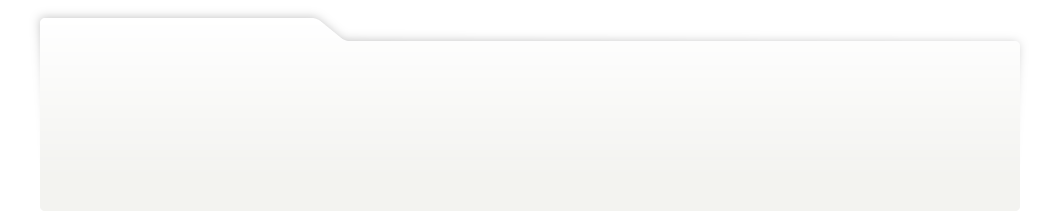
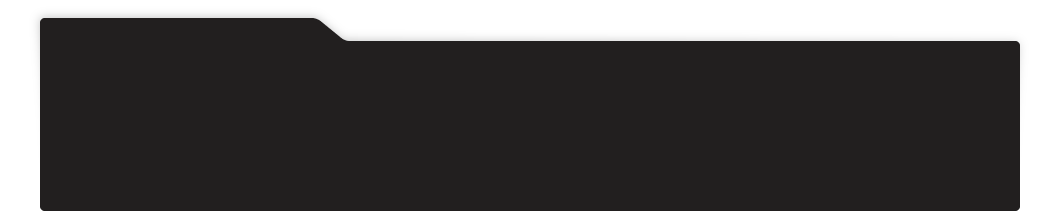
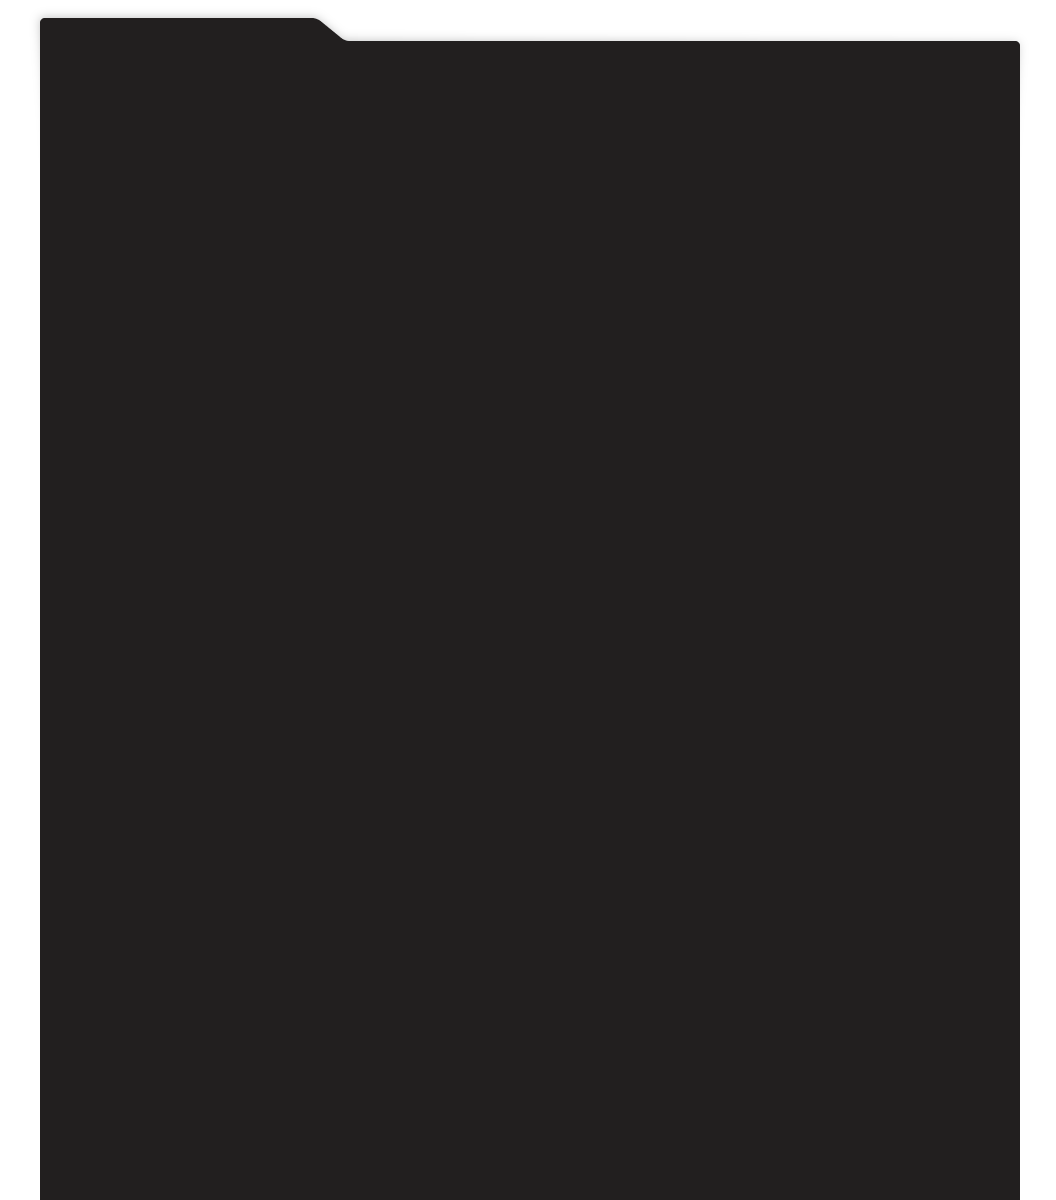
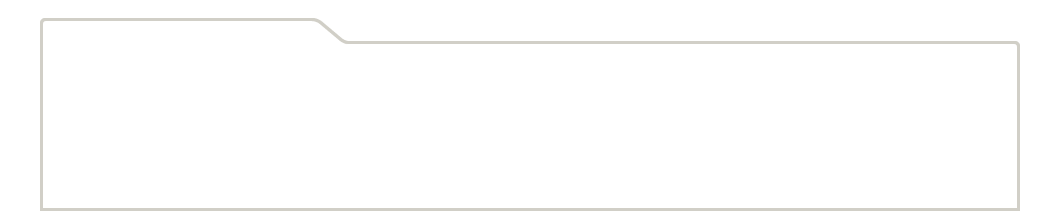
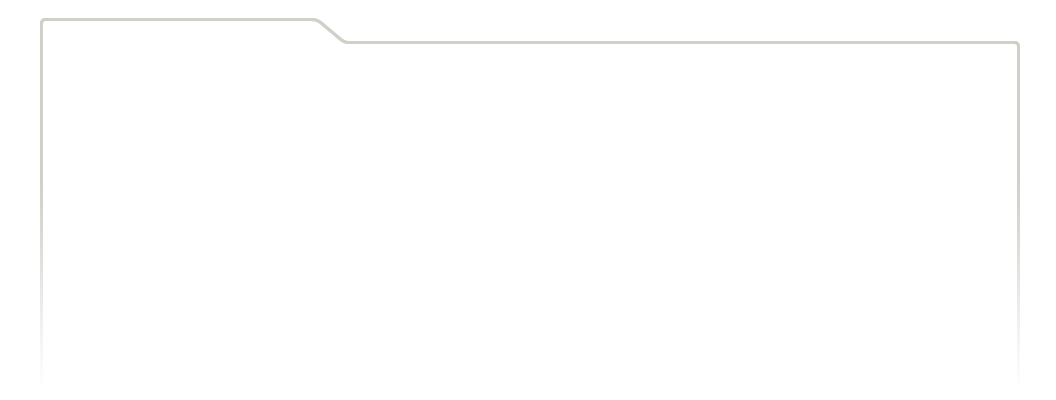
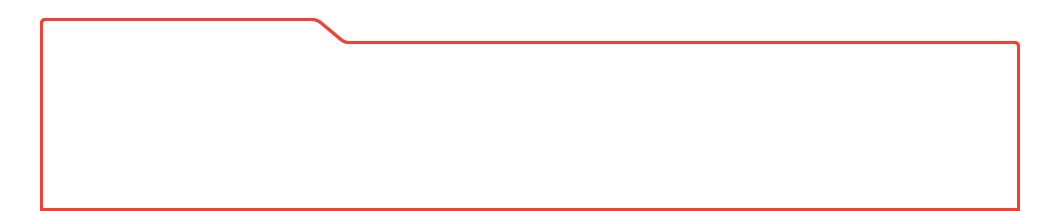
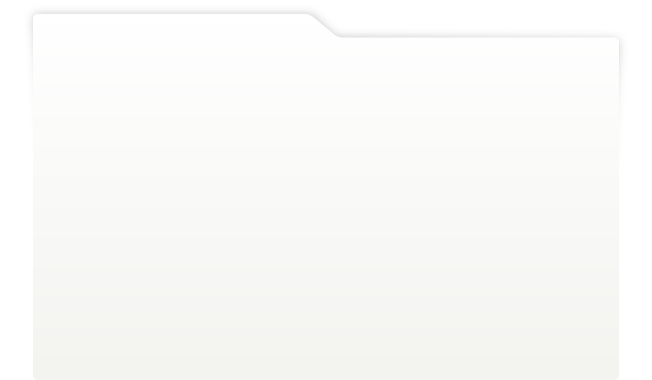
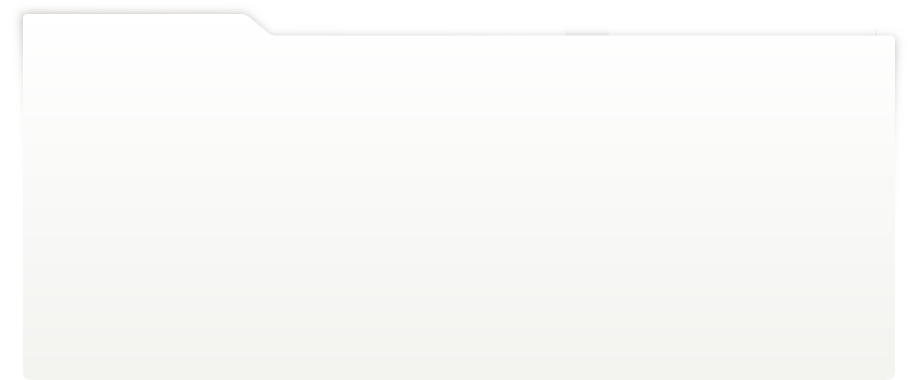
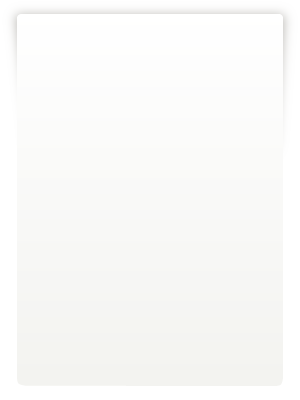
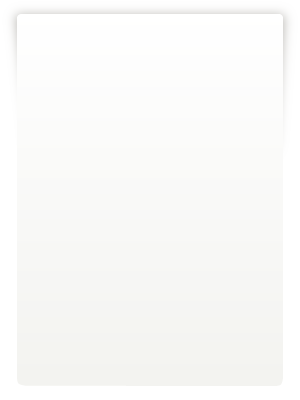
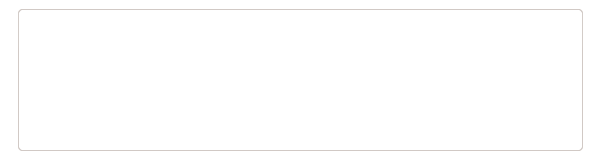
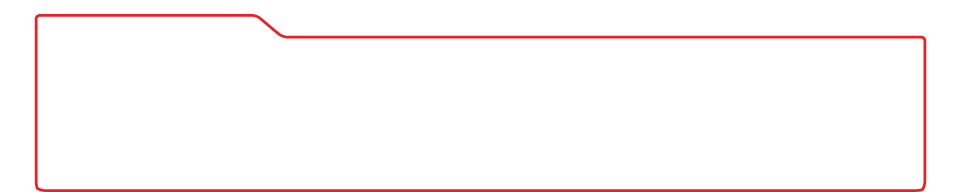
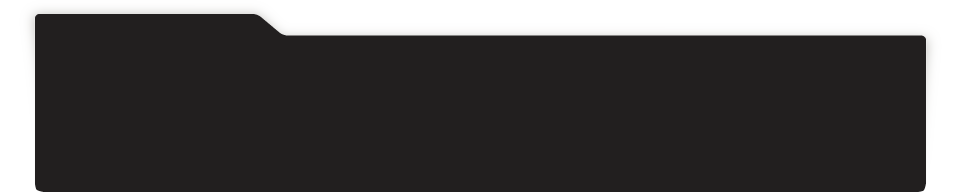
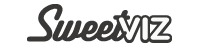
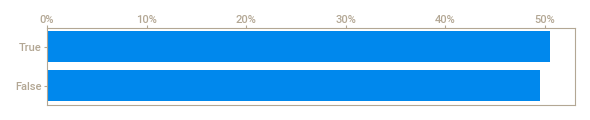
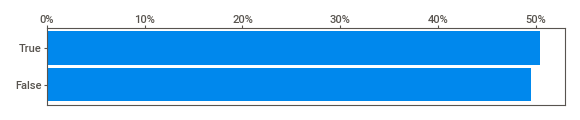
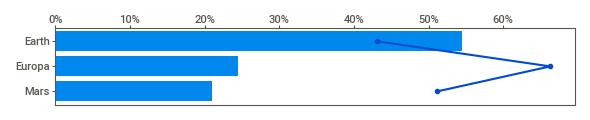
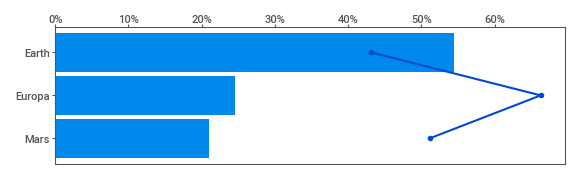
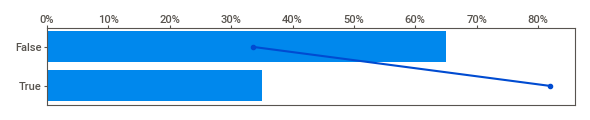
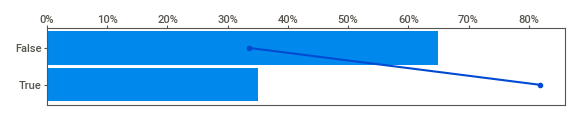
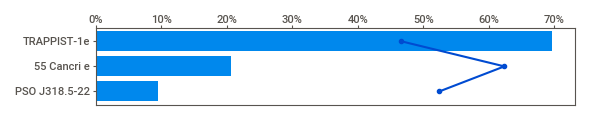
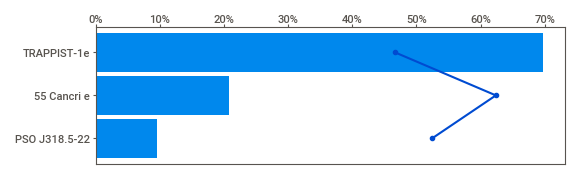
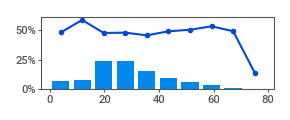
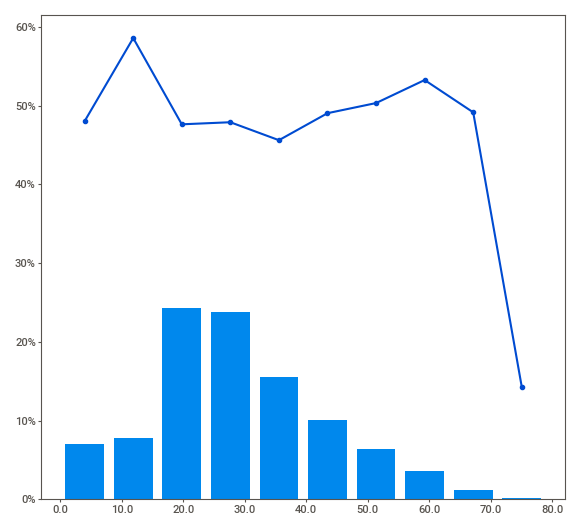
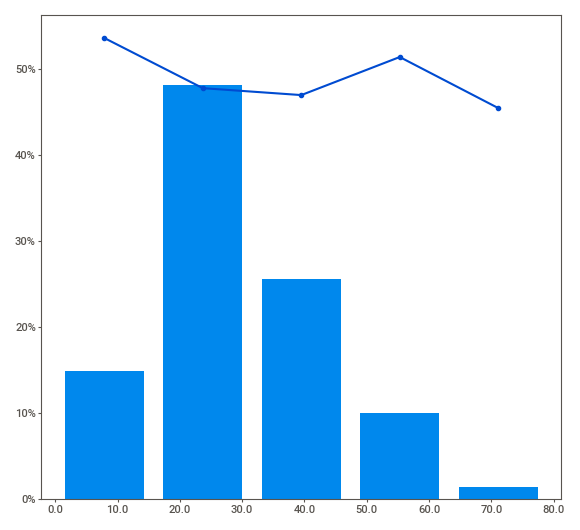
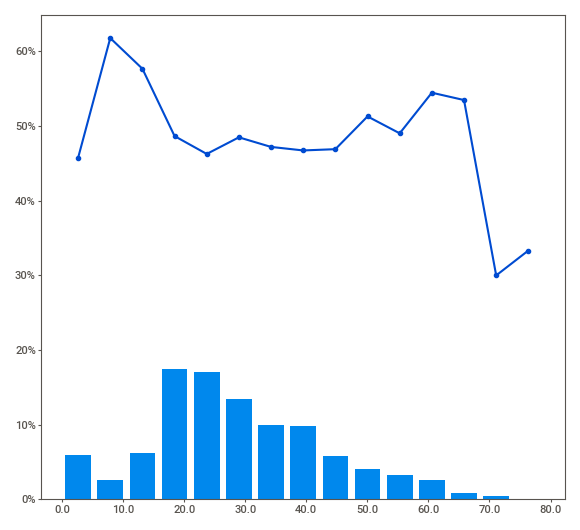
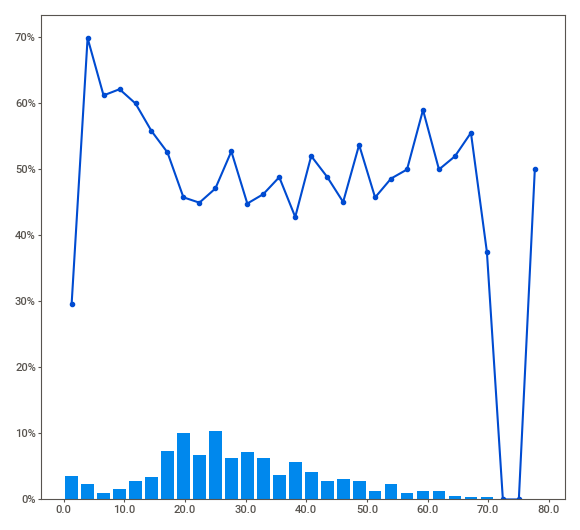
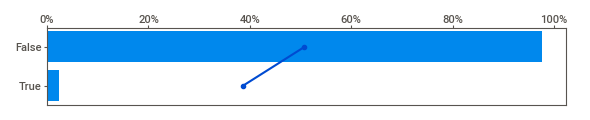
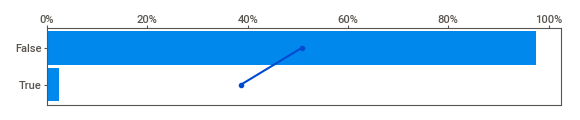
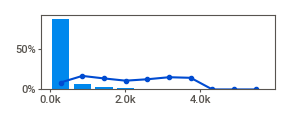
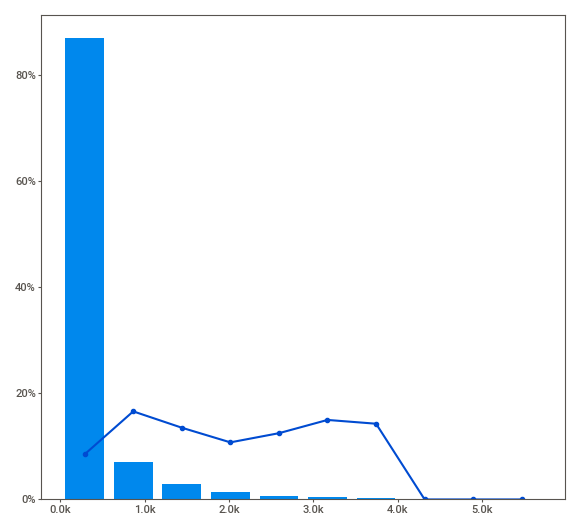
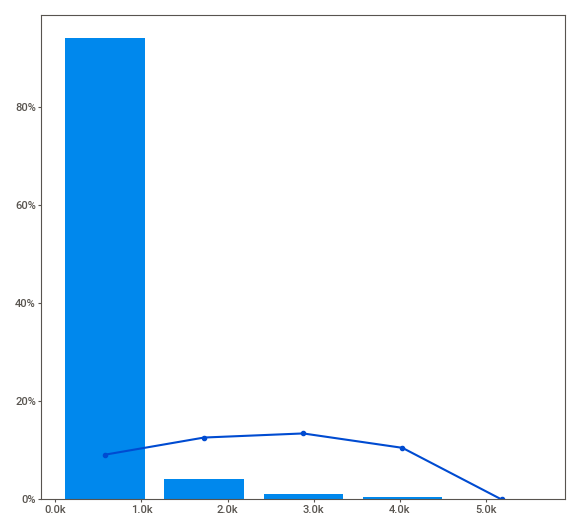
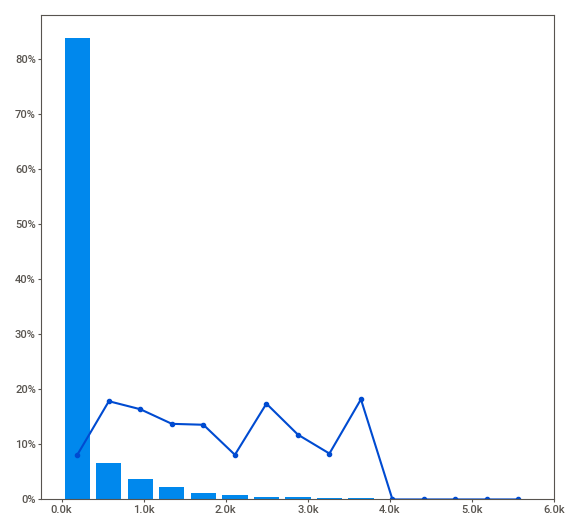
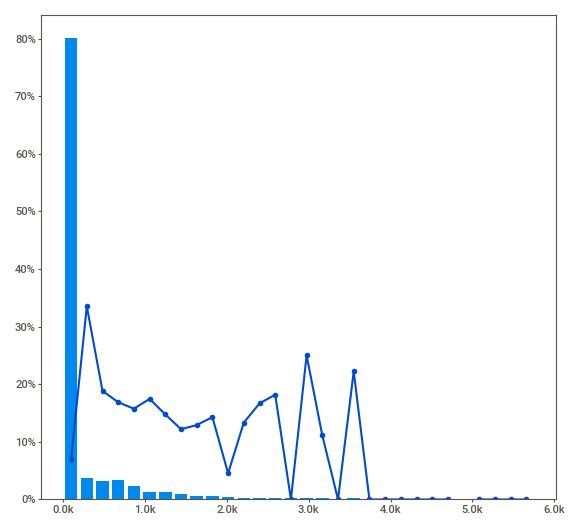
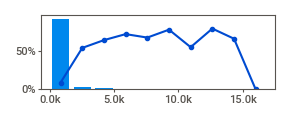
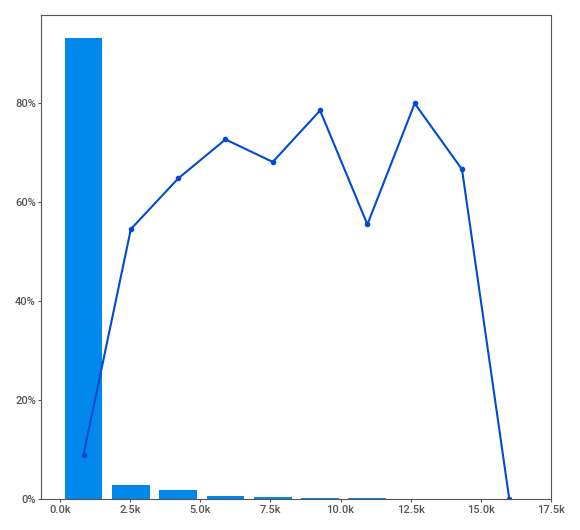
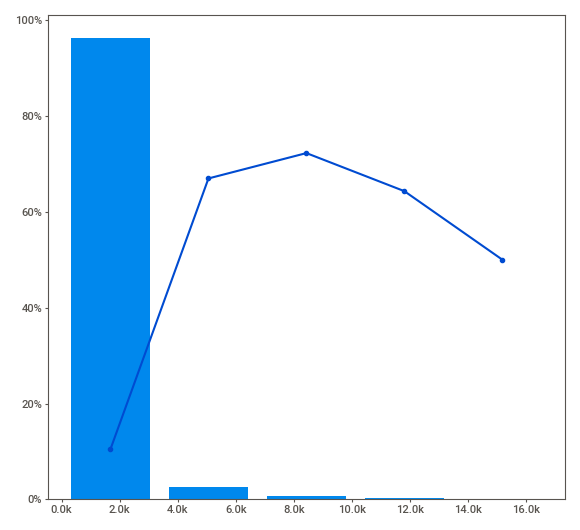
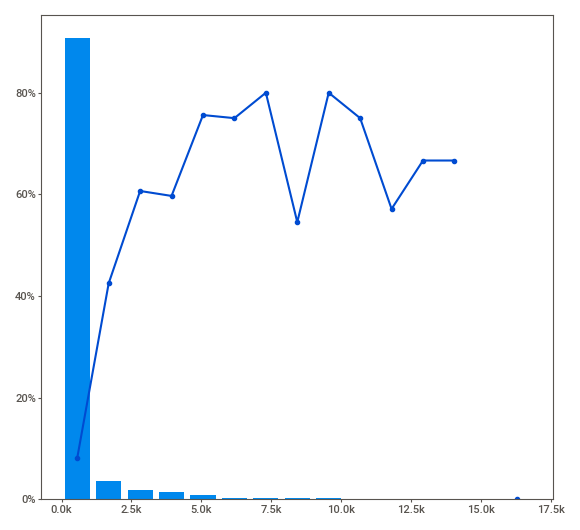
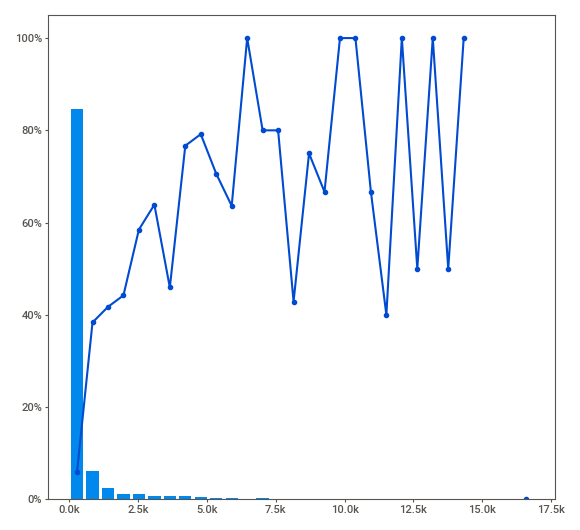
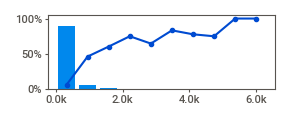
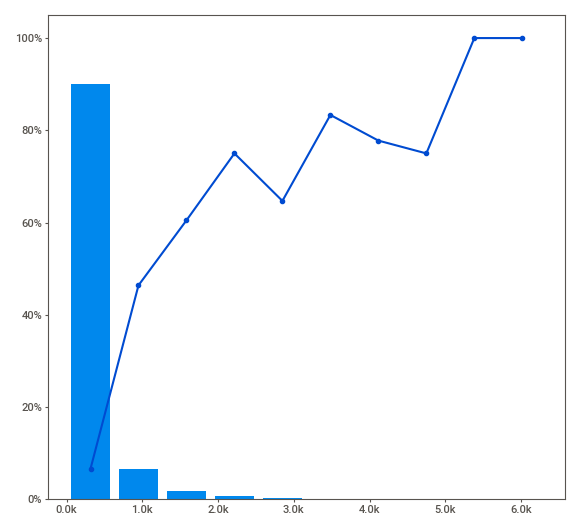
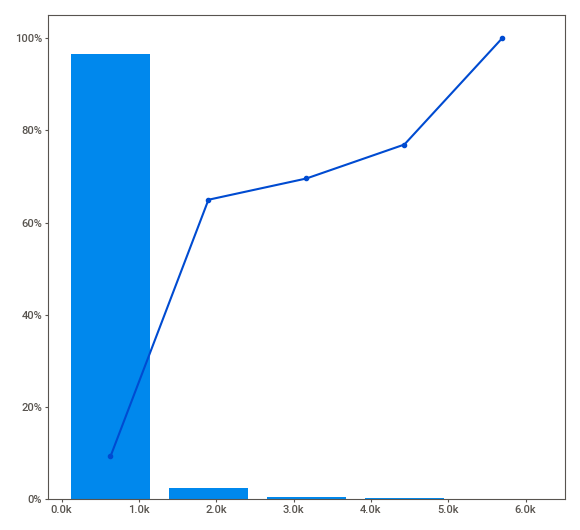
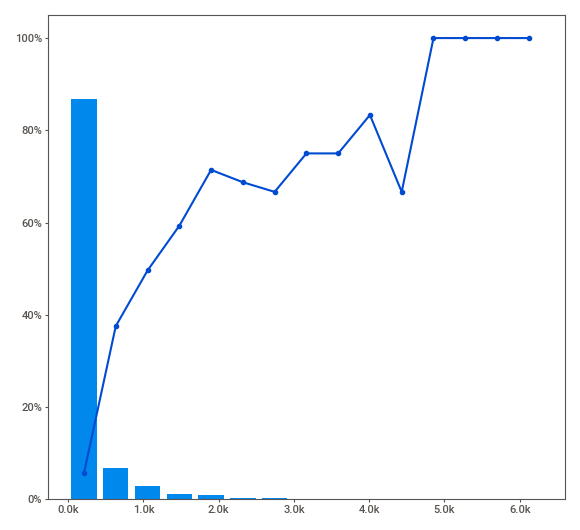
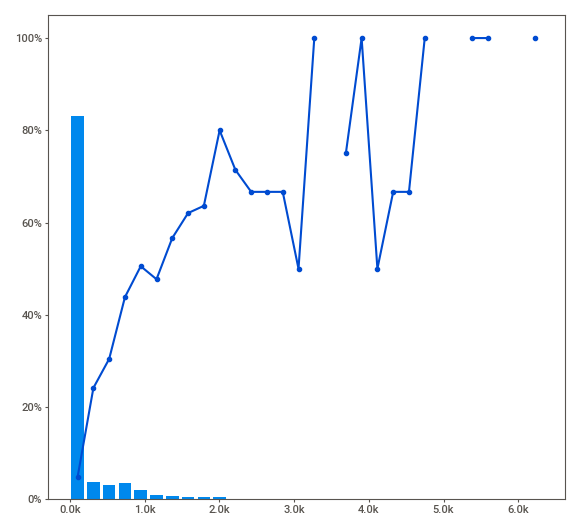
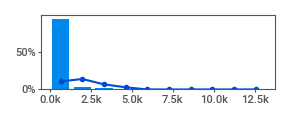
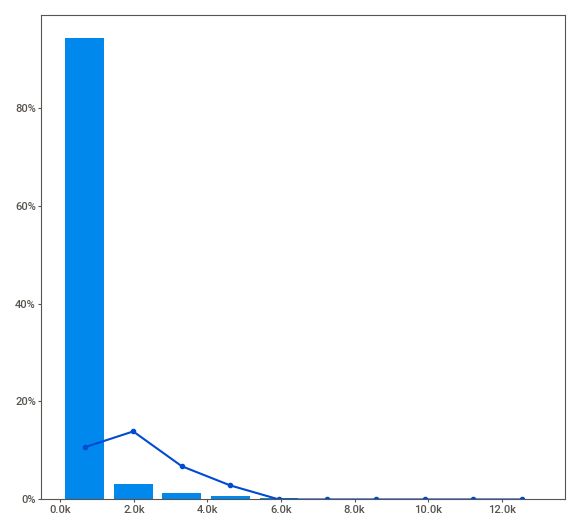
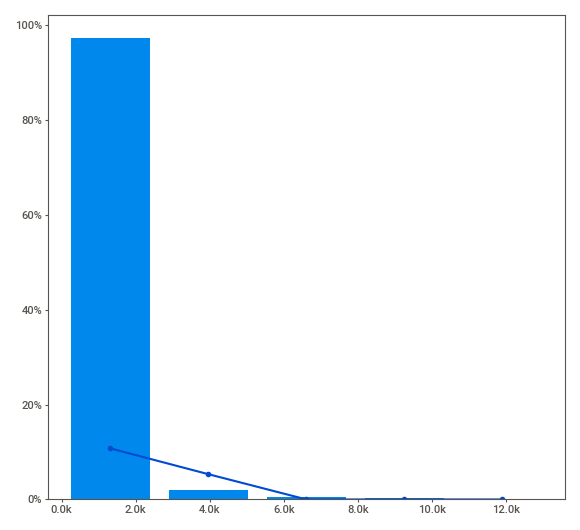
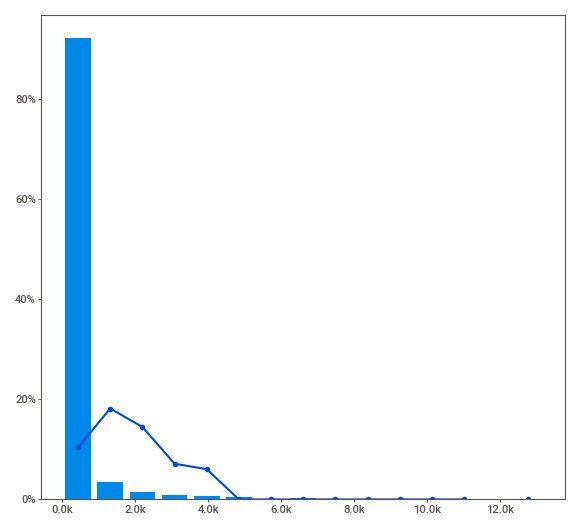
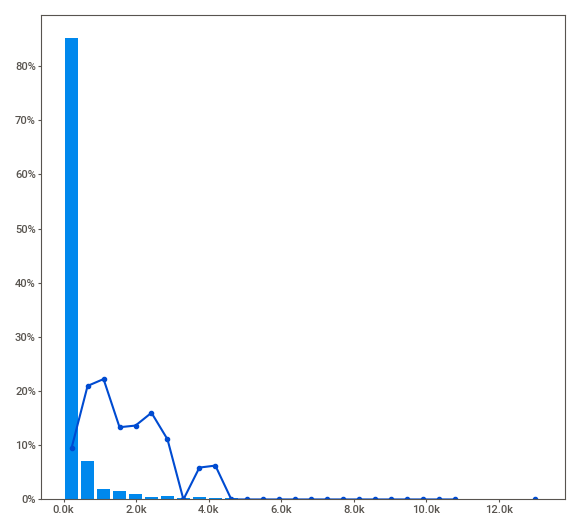
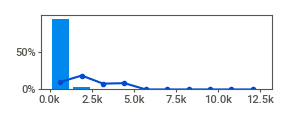
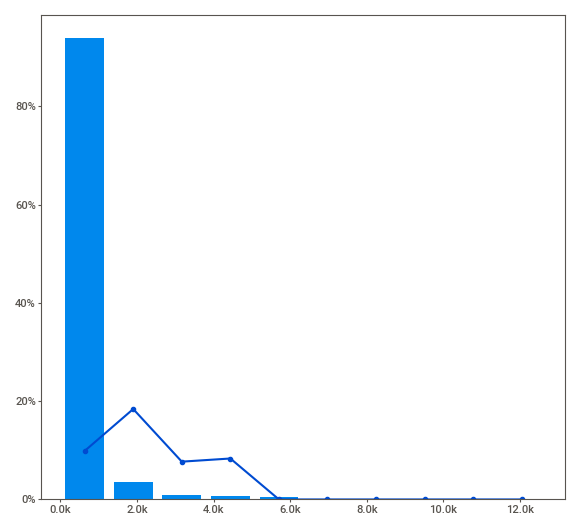
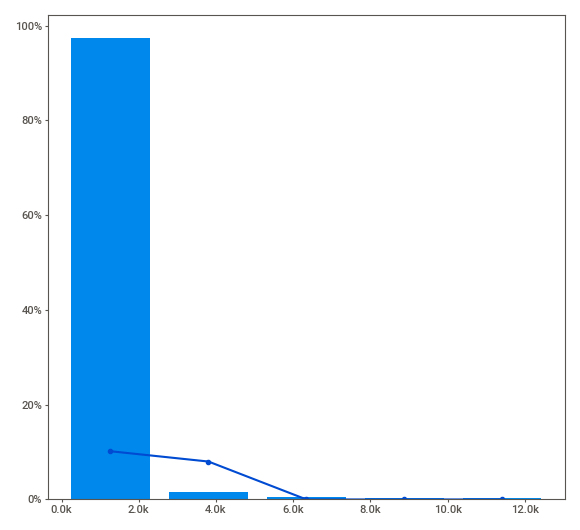
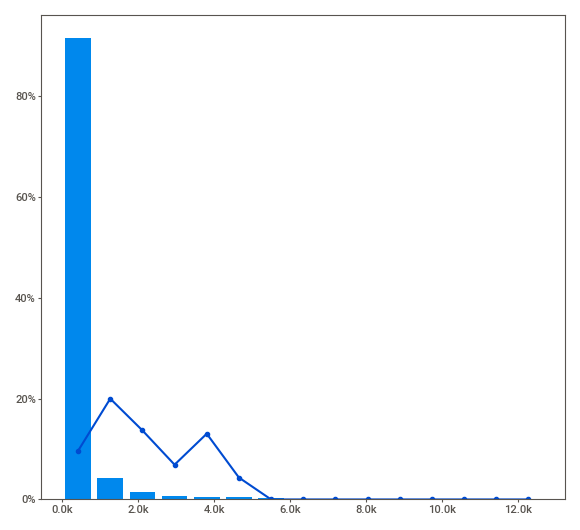
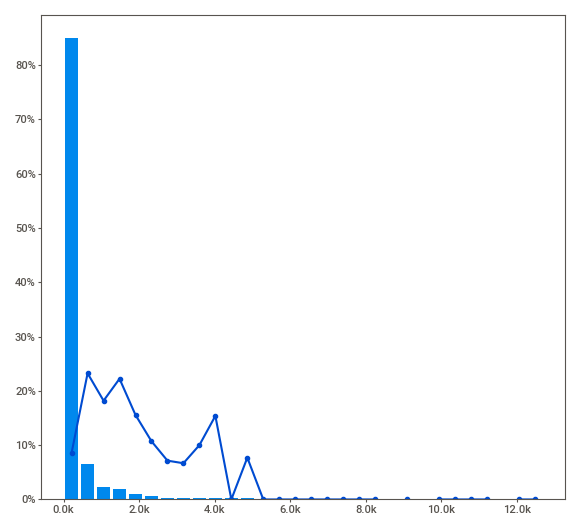
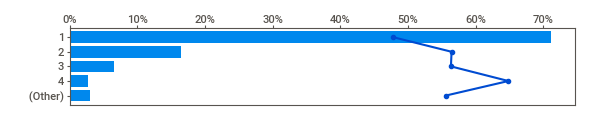
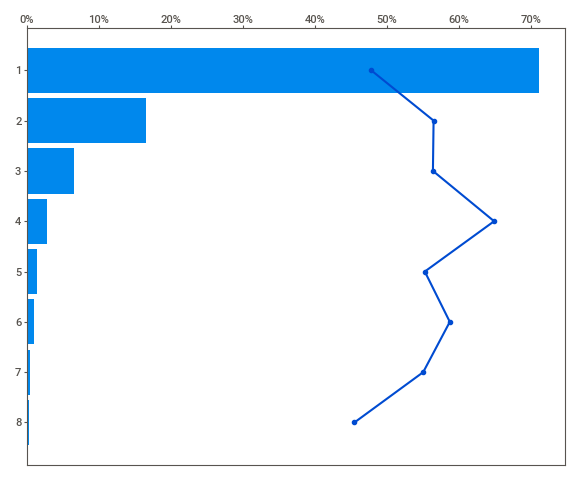
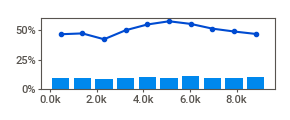
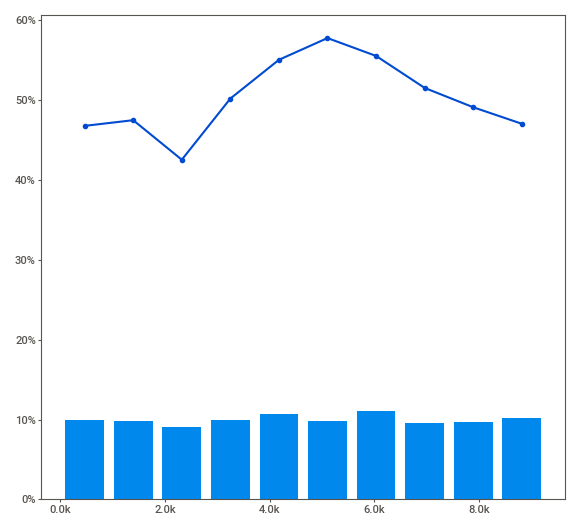
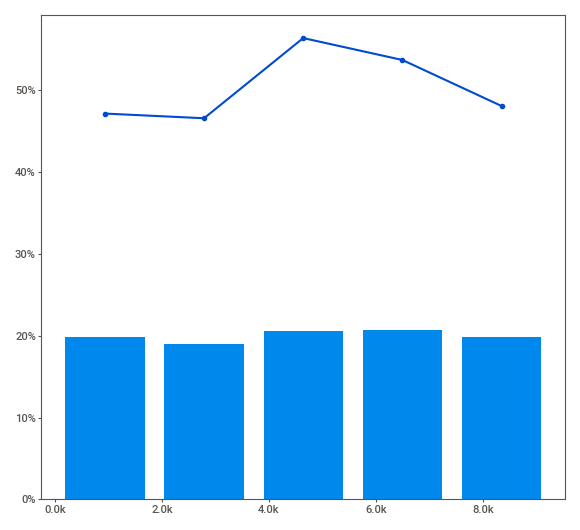
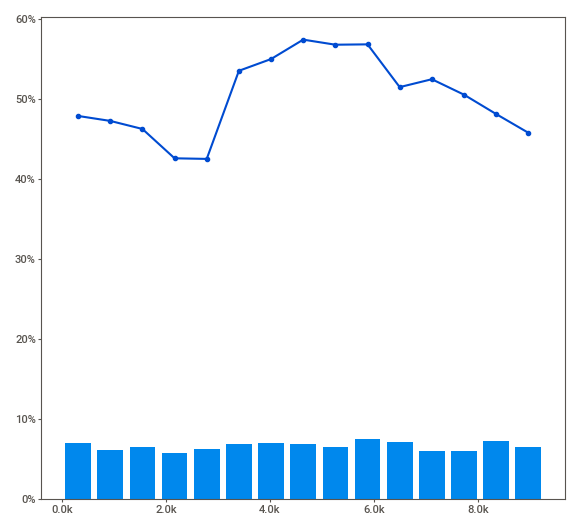
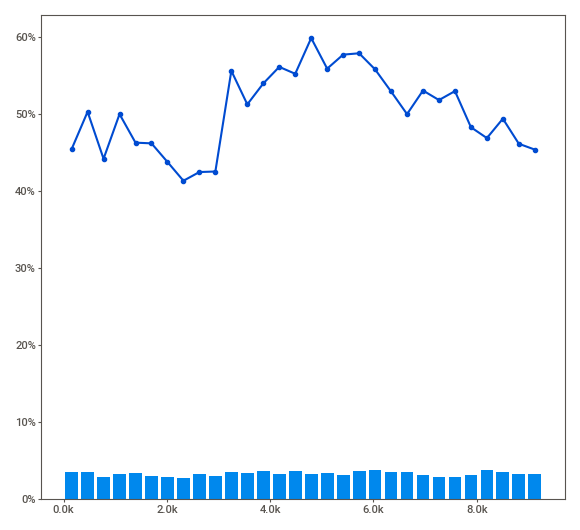
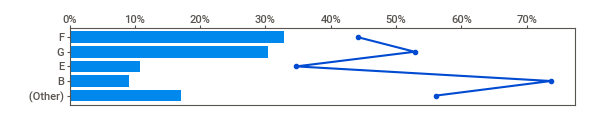
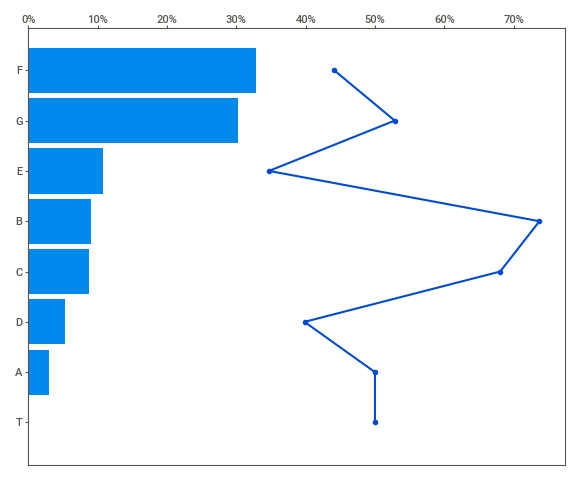
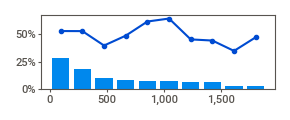
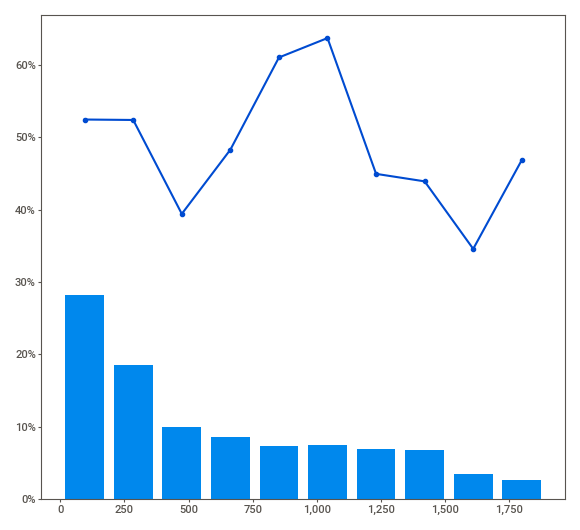
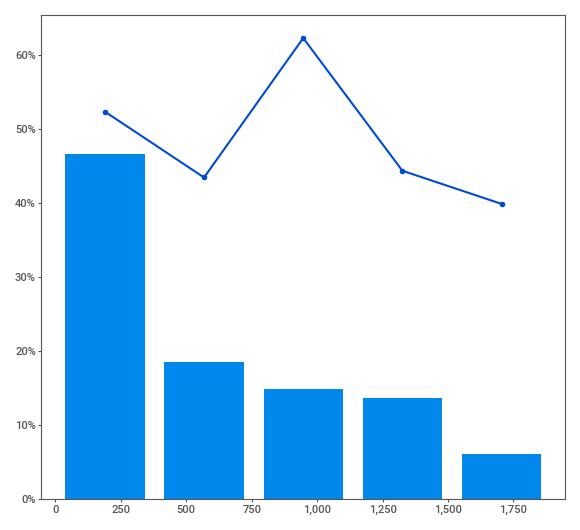
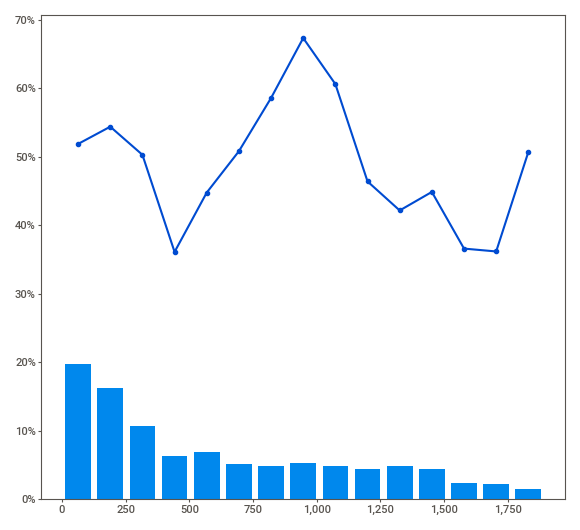
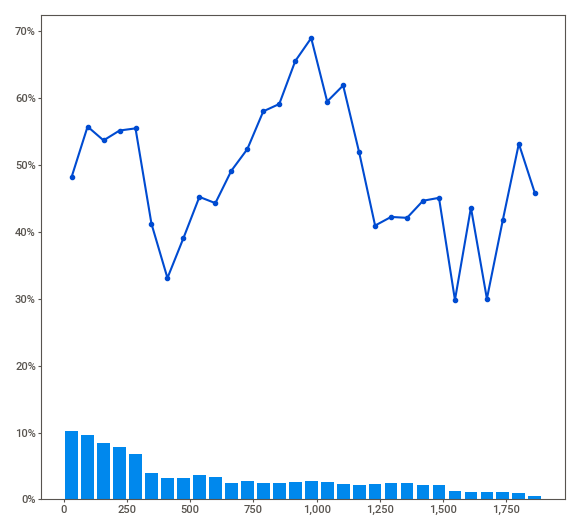
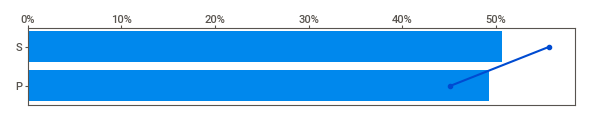
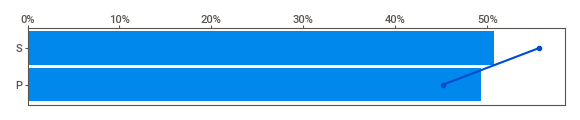
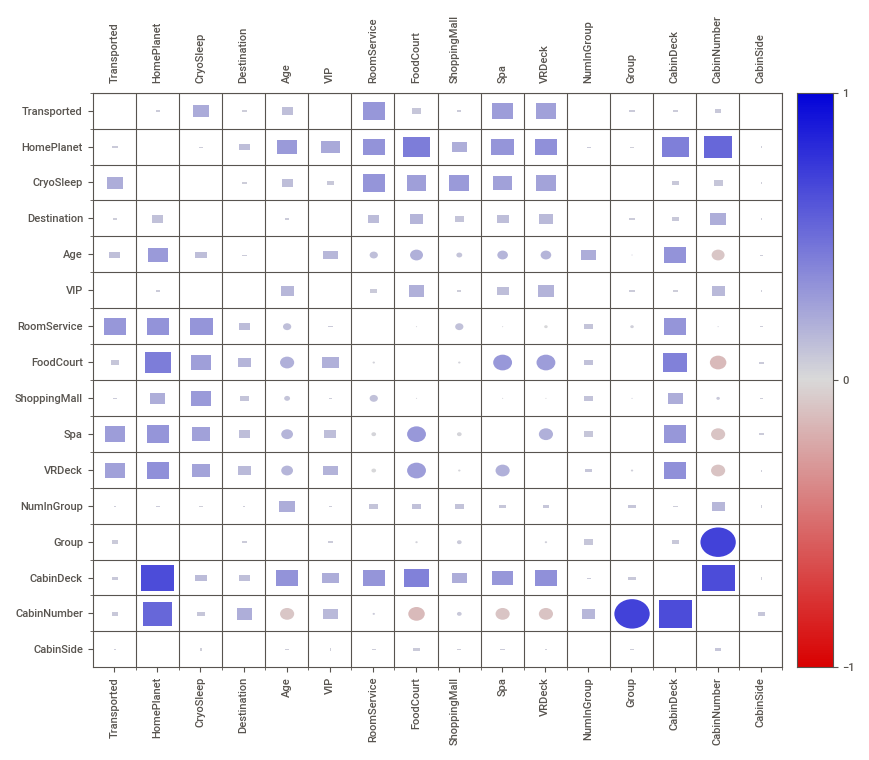
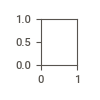

Report 'Report.html' was saved to storage.


In [8]:
#También podemos hacer lo anterior usando el método show_notebook
my_report.show_notebook(
    w=None, #Ancho en pixeles o en porcentajes
    h=None, #Altura en pixeles o en porcentajes
    scale=None, #valor entre 0 y 1
    layout='vertical', #vertical es mucho mejor para dispositivos con pantallas pequeñas
    filepath='Report.html')

## ¿Qué podemos decir acerca de estos resultados?
* A priori, de la gráfica de asociaciones podemos observar que las variables que más tienen relación con la variable objetivo son (en orden de importancia):
    * Categóricas (con un coeficiente de incertidumbre de):
        * `CryoSleep`: 0.16
        * `CabinDeck`: 0.03
        * `HomePlanet`: 0.03
        * `Destination`: 0.01
        * `NuminGroup`: 0.01
        * `CabinSide` : 0.01
    * Numéricas (con un coeficiente de correlación de):
        * `RoomService`:0.25
        * `Spa`:0.21
        * `VRDeck`:0.20
        * `Age`:0.07
        * `FoodCourt`:0.04
        * `CabinNumber`:0.03
        * `Group`:0.03
        * `ShoppingMall`:0.02

* Existen valores faltantes para la mayoría de variables.
* Observamos que con respecto a la característica `HomePlanet`:
    * Alguien que vive en la tierra tiene un 43% de probabilidades de ser transportado.
    * Alguien que vive en Europa tiene un 66% de probabilidades de ser transportado.
    * La información acerca de Marte es bastante equilibrada.
    * Las características que nos dan información sobre esta son:
        * `CabinDeck`:0.56
        * `Destination`:0.06
        * `NumInGroup`:0.02
        * `VIP`:0.02
        * `CryoSleep`:0.01
    * Las variables numéricas que tienen una gran correlación con esta son:
        * `CabinNumber`:0.49
        * `FoodCourt`:0.37
        * `VRDeck`:0.29
        * `Spa`:0.26
        * `RoomService`:0.25
        * `Age`:0.22
        * `ShoppingMall`:0.12
* Observamos que con respecto a la característica `CryoSleep`:
    * Si un pasajero no viaja en sueño criogénico, entonces tiene un 33% de probabilidades de ser transportado
    * Si un pasajero viaja en sueño criogénico, entonces tiene un 82% de ser transportado
    * Las características categoricas que nos dan información sobre esta son :
        * `CabinDeck`:0.08
        * `Destination`:0.01
        * `HomePlanet`: 0.01
        * `VIP`:0.01
    * Las variables numéricas que tienen una gran correlación con esta son:
        * `RoomService`:0.25
        * `FoodCourt`:0.22
        * `ShoppingMall`:0.21
        * `Spa`:0.19
        * `VRDeck`:0.19
        * `Age`:0.07
        * `CabinNumber`:0.05
* Observamos que con respecto a la característica `Destination`:
    * Un pasajero que viaja a 55 Canri e tiene un 62% de probabilidades de ser transportado.
    * Los otros destinos son bastante parejos.
    * Las características categoricas que nos dan información sobre esta son:
        * `HomePlanet`:0.08
        * `CabinDeck`:0.06
        * `CryoSleep`:0.01
    * Las características numéricas que nos dan información sobre esta son:
        * `CabinNumber`:0.16
        * `FoodCourt`:0.13
        * `VRDeck`:0.09
        * `Spa`:0.08
        * `RoomService`:0.07
        * `ShoppingMall`:0.04
        * `Age`:0.03
        * `Group`:0.02
* Observamos que con respecto a la característica `Edad`:
    * Si un pasajero tiene menos de 2.6 años, la probabilidad de que sea transportado es de alrededor del 30%
    * Un pasajero entre 2.6 años y 5.2 años tiene una probabilidad de ser transportado de más del 70%
    * Un pasajero entre los 5.2 y los 7.8 años tiene una probabilidad de ser transportado de más del 60%
    * Un pasajero entre los 71 y los 73.6 años tiene una probabilidad de ser transportado de menos del 30%, al igual que un pasajero mayor de 76 años
    * El resto de pasajeros tienen probabilidades entre el 40% y el 60%
* Observamos que con respecto a la característica `NuminGroup`:
    * Una persona en el grupo 3 o el grupo 4 tiene mayor probabilidad de ser transportado que el resto (cerca del 60%), aunque no es una diferencia significativa y todos están relativamente al rededor del 50%.
* Observamos que con respecto a la característica `CabinSide`:
    * Un pasajero en el lado S tiene un 56% de probabilidades de ser transportado, mientras que uno en el lado P tiene un 45%.
* Observamos que con respecto a la característica `CabinDeck`:
    * Un pasajero en la planta F tiene un 44% de probabilidades de ser transportado.
    * Un pasajero en la planta B tiene un 74% de probabilidades de ser transportado.
    * Un pasajero en la planta C tiene un 67% de probabilidades de ser transportado.
    * Un pasajero en la planta E tiene un 36% de probabilidades de ser transportado.
    * Un pasajero en la planta D tiene un 42% de probabilidades de ser transportado.
    * Un pasajero en cualquier otra planta tiene chances cercanas al 50% de ser transportado.
* Hay grupos en los que hay menor o mayor probabilidad de ser transportado, aunque se mantienen en el rango entre el 40 y el 60%.
* Ser VIP le da a un pasajero una probabilidad del 38% de ser transportado, mientras que no serlo tiene una probabilidad muy cercana al 50%.


Los reportes que hace Sweetviz son muy bonitos, ¿verdad? Pero no tenemos porqué quedarnos con una sola forma de hacer el análisis.

Ahora veamos qué tipo de resultados obtenemos de la información mutua. Para esto, debemos limpiar los datos de los valores faltantes. Para simplificar el análisis, simplemente nos desharemos.

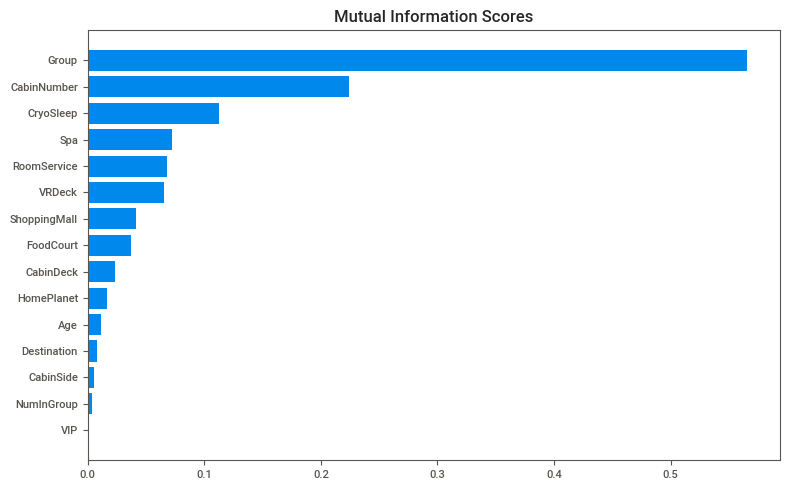

In [9]:
X_train_mi=train_df.copy()
X_train_mi.dropna(axis=0,inplace=True)
y_train_mi=X_train_mi.pop('Transported')
mi_scores=make_mi_scores_classification(X_train_mi,y_train_mi)
plot_mi_scores(mi_scores)

De lo anterior, podemos notar que para la información mutua, el número de grupo y el número de cabina son las que contienen más información acerca de la variable objetivo. Esto contrasta mucho con lo dado por Sweetviz y no es de extrañar puesto que los valores diferentes de Group y CabinNumber son bastantes. No obstante las características que le siguen son CryoSleep y los servicios de lujo, que sí aparecen dentro del análisis de Sweetviz, por lo que se habrá de poner especial atención a estos. Podríamos tener la tentación de quere eliminar la característica VIP, pero vimos con el análisis de Sweetviz que hay un patrón descrito por esta característica. De las demás características también encontramos patrones.

De lo anterior, podemos decir que no es conveniente eliminar ninguna de las columnas que tenemos, pero sí es necesario ayudar al modelo a encontrar los patrones necesarios agregando nuevas características.

---

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Modelamiento
from  sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

# Ajustamos la semilla

# Definimos diferentes características y la transformer pipeline
categorical_features= ["HomePlanet","Destination","CabinDeck","CabinSide"]
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant",fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


VIP_feature = ["VIP"]
VIP_transformer = Pipeline (steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=True)),
    #("onehot", OneHotEncoder(handle_unknown="ignore"))
    ('label', OrdinalEncoder())
])

CryoSleep_feature = ["CryoSleep"]
CryoSleep_transformer = Pipeline (steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=True)),
    #("onehot",OneHotEncoder(handle_unknown="ignore"))
    ('label', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
                transformers=[
                    ("cat", categorical_transformer, categorical_features),
                    ("vip", VIP_transformer, VIP_feature),
                    ("cryo", CryoSleep_transformer, CryoSleep_feature),
                    #("num", numeric_transformer, numeric_features),
                ])
X_train_trans=pd.DataFrame(preprocessor.fit_transform(X_train_mi),index=X_train_mi.index,columns=['Earth','Europa','Mars','Cancri','PSO','TRAPPIST','Cabin A','Cabin B','Cabin C','Cabin D','Cabin E','Cabin F', 'Cabin G','Cabin T','Babor','Estribor','VIP','CryoSleep'])
X_train_mi

HomePlanet CryoSleep    Destination   Age    VIP  RoomService  FoodCourt  \
7362      Earth     False  PSO J318.5-22   7.0  False          0.0        0.0   
731       Earth      True  PSO J318.5-22  10.0  False          0.0        0.0   
2338     Europa      True    55 Cancri e  28.0  False          0.0        0.0   
2213      Earth     False    TRAPPIST-1e  30.0  False          3.0        0.0   
8186       Mars     False    TRAPPIST-1e  35.0  False       2758.0        0.0   
...         ...       ...            ...   ...    ...          ...        ...   
5237      Earth     False    TRAPPIST-1e  26.0  False          0.0      786.0   
167       Earth     False    TRAPPIST-1e   8.0  False          0.0        0.0   
4832     Europa      True    55 Cancri e  21.0  False          0.0        0.0   
7832     Europa     False    55 Cancri e  25.0  False          0.0     1673.0   
2283       Mars      True    TRAPPIST-1e  27.0  False          0.0        0.0   

      ShoppingMall    Spa  VRDeck  NumInGroup  Group CabinDeck  CabinNumber  \
7362           0.0    0.0     0.0           6   7872         G         1267   
731            0.0    0.0     0.0           4    770         G          117   
2338           0.0    0.0     0.0           2   2518         C           87   
2213         880.0    0.0    40.0           1   2369         F          484   
8186           1.0    0.0     0.0           1   8752         D          272   
...            ...    ...     ...         ...    ...       ...          ...   
5237           0.0   11.0    83.0           1   5589         F         1160   
167            0.0    0.0     0.0           2    192         G           29   
4832           0.0    0.0     0.0           1   5156         B          200   
7832           0.0  642.0   612.0           1   8363         A          101   
2283           0.0    0.0     0.0           1   2453         E          147   

     CabinSide  
7362         P  
731          S  
2338         P  
2213         P  
8186         P  
...        ...  
5237         P  
167          P  
4832         S  
7832         S  
2283         P  

[4750 rows x 15 columns]

In [11]:
X_train_trans

Earth  Europa  Mars  Cancri  PSO  TRAPPIST  Cabin A  Cabin B  Cabin C  \
7362    1.0     0.0   0.0     0.0  1.0       0.0      0.0      0.0      0.0   
731     1.0     0.0   0.0     0.0  1.0       0.0      0.0      0.0      0.0   
2338    0.0     1.0   0.0     1.0  0.0       0.0      0.0      0.0      1.0   
2213    1.0     0.0   0.0     0.0  0.0       1.0      0.0      0.0      0.0   
8186    0.0     0.0   1.0     0.0  0.0       1.0      0.0      0.0      0.0   
...     ...     ...   ...     ...  ...       ...      ...      ...      ...   
5237    1.0     0.0   0.0     0.0  0.0       1.0      0.0      0.0      0.0   
167     1.0     0.0   0.0     0.0  0.0       1.0      0.0      0.0      0.0   
4832    0.0     1.0   0.0     1.0  0.0       0.0      0.0      1.0      0.0   
7832    0.0     1.0   0.0     1.0  0.0       0.0      1.0      0.0      0.0   
2283    0.0     0.0   1.0     0.0  0.0       1.0      0.0      0.0      0.0   

      Cabin D  Cabin E  Cabin F  Cabin G  Cabin T  Babor  Estribor  VIP  \
7362      0.0      0.0      0.0      1.0      0.0    1.0       0.0  0.0   
731       0.0      0.0      0.0      1.0      0.0    0.0       1.0  0.0   
2338      0.0      0.0      0.0      0.0      0.0    1.0       0.0  0.0   
2213      0.0      0.0      1.0      0.0      0.0    1.0       0.0  0.0   
8186      1.0      0.0      0.0      0.0      0.0    1.0       0.0  0.0   
...       ...      ...      ...      ...      ...    ...       ...  ...   
5237      0.0      0.0      1.0      0.0      0.0    1.0       0.0  0.0   
167       0.0      0.0      0.0      1.0      0.0    1.0       0.0  0.0   
4832      0.0      0.0      0.0      0.0      0.0    0.0       1.0  0.0   
7832      0.0      0.0      0.0      0.0      0.0    0.0       1.0  0.0   
2283      0.0      1.0      0.0      0.0      0.0    1.0       0.0  0.0   

      CryoSleep  
7362        0.0  
731         1.0  
2338        1.0  
2213        0.0  
8186        0.0  
...         ...  
5237        0.0  
167         0.0  
4832        1.0  
7832        0.0  
2283        1.0  

[4750 rows x 18 columns]

# Nuevas características
Para comenzar, hagamos el análisis de componentes principales.

In [12]:
#num_features=list(X_train_mi.select_dtypes(["float64",'int64']).columns)
#pca, X_pca, loadings = apply_pca(X_train_trans[num_features])
new_df=X_train_mi.select_dtypes(["float64",'int64']).join(X_train_trans).drop(['Mars','PSO','Cabin A','Cabin G','Cabin T'],axis=1)
new_df['Group']=pd.cut(new_df.Group, bins=15)
new_df['CabinNumber']=pd.cut(new_df.CabinNumber, bins=15)
new_df['Age']=pd.cut(new_df.Age, bins=8)


La variable `loadings` es la que nos muestra la relación entre las componentes principales y las características numéricas, así que es buena idea visualizarla tanto numéricamente como gráficamente.

In [13]:
pca, X_pca, loadings = apply_pca(new_df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].reset_index().drop(['index'],axis=1))
loadings

PC1       PC2       PC3       PC4       PC5
RoomService  -0.045096  0.706433 -0.684078 -0.175919 -0.002866
FoodCourt     0.622369  0.005241 -0.056753  0.069528  0.777544
ShoppingMall -0.011447  0.692395  0.718956 -0.013316  0.058163
Spa           0.562134  0.130193 -0.063281  0.633125 -0.512058
VRDeck        0.542677 -0.067561  0.088956 -0.750462 -0.360320

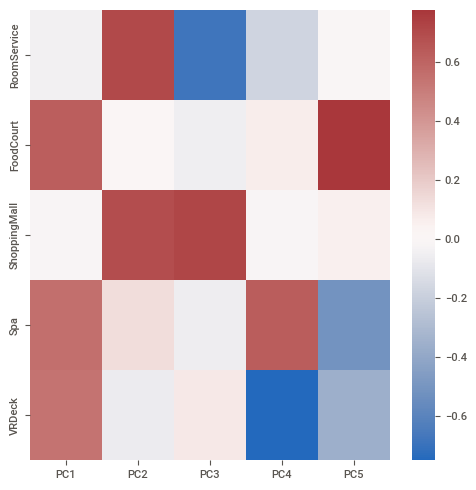

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(loadings,cmap="vlag", ax=ax);

Se agregarán las columnas de `X_pca` al conjunto de datos de entrenamiento para entrenar el modelo. Además de eso

In [15]:
X_pca

PC1       PC2       PC3       PC4       PC5
0    -0.457690 -0.473311  0.034394  0.076047 -0.012000
1    -0.457690 -0.473311  0.034394  0.076047 -0.012000
2    -0.457690 -0.473311  0.034394  0.076047 -0.012000
3    -0.456576  0.535394  1.080376  0.030967  0.060687
4    -0.653419  2.593633 -2.933202 -0.687435 -0.024341
...        ...       ...       ...       ...       ...
4745 -0.099674 -0.474087  0.011155  0.065583  0.352553
4746 -0.457690 -0.473311  0.034394  0.076047 -0.012000
4747 -0.457690 -0.473311  0.034394  0.076047 -0.012000
4748  0.794871 -0.431058 -0.016169  0.115101  0.365462
4749 -0.457690 -0.473311  0.034394  0.076047 -0.012000

[4750 rows x 5 columns]

In [16]:
new_df= new_df.reset_index().join(X_pca,how='left').set_index('index')
new_df.shape

(4750, 27)

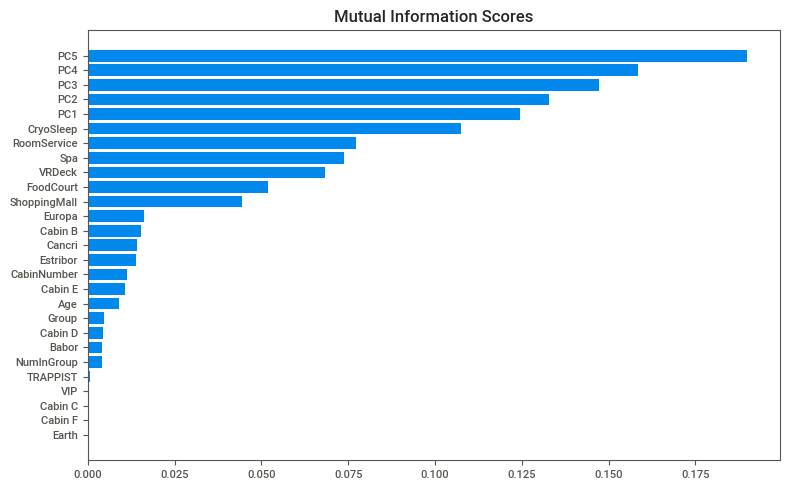

In [17]:
mi_scores=make_mi_scores_classification(new_df,y_train_mi)
plot_mi_scores(mi_scores)

                                             |          | [  0%]   00:00 -> (? left)

/usr/local/lib/python3.10/dist-packages/sweetviz/graph.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figure.savefig(as_raw_bytes, format='png', transparent=True)



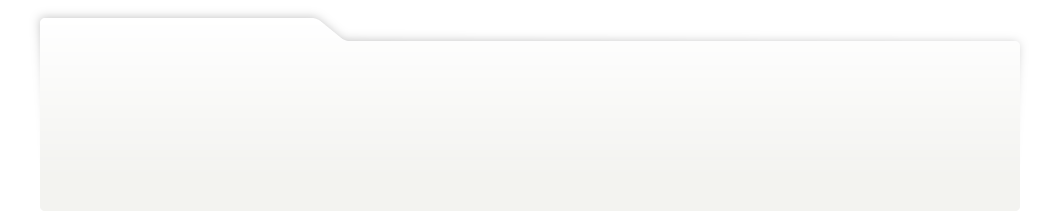
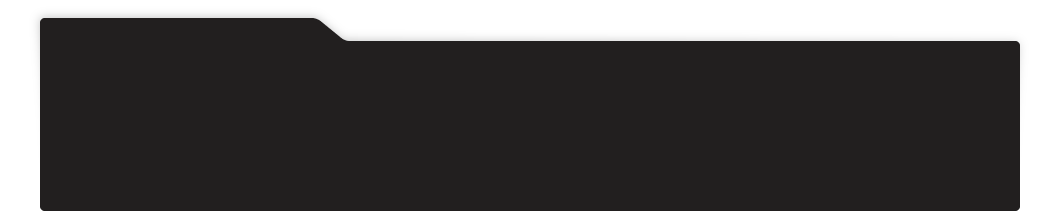
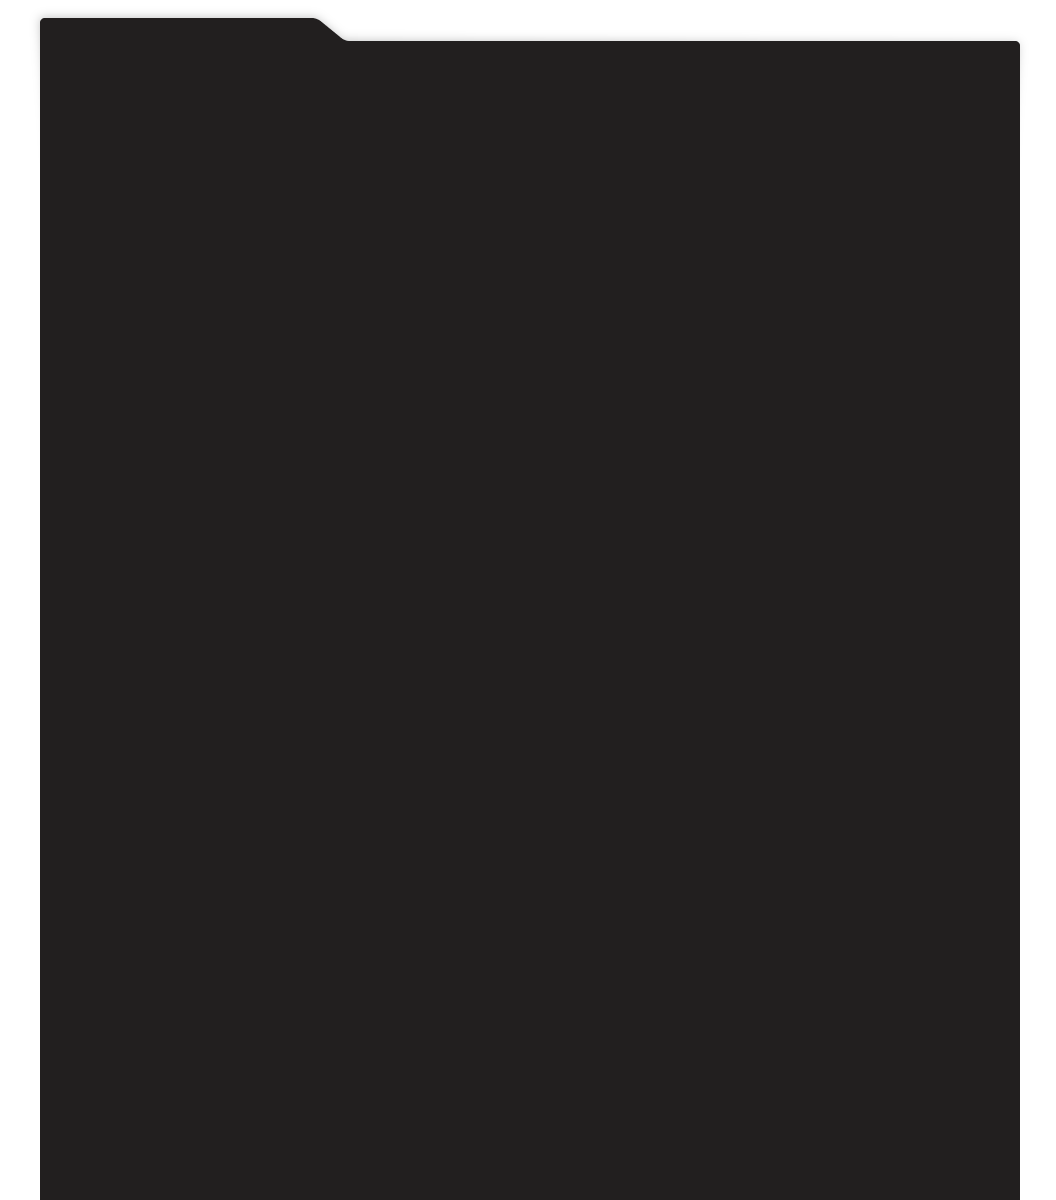
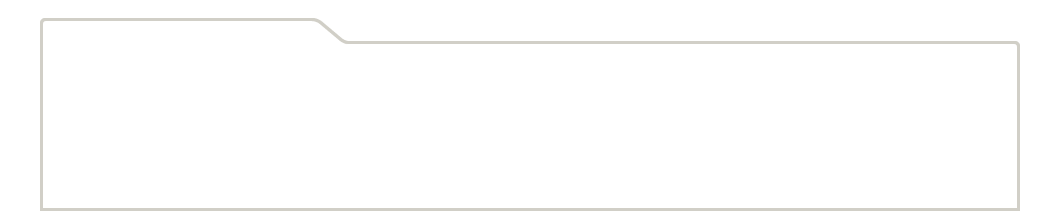
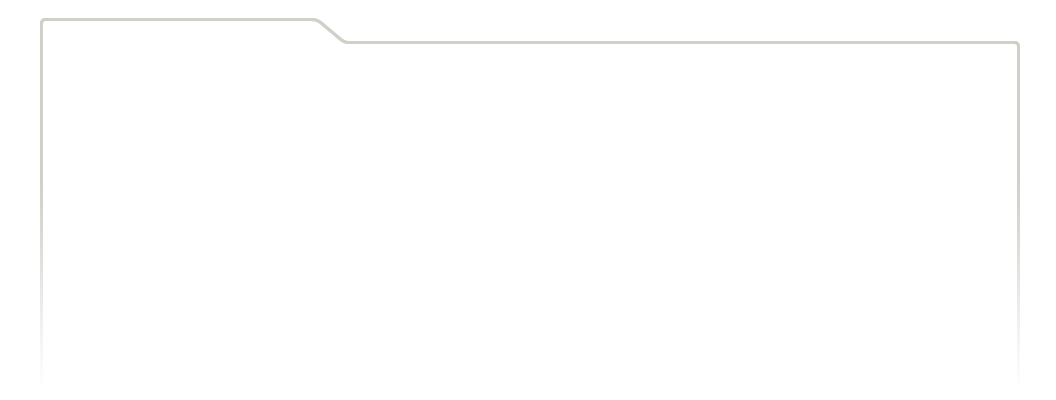
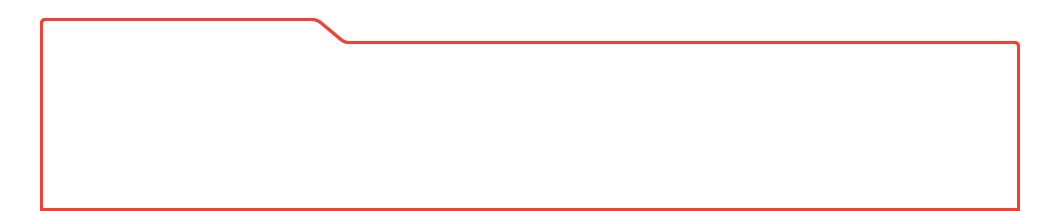
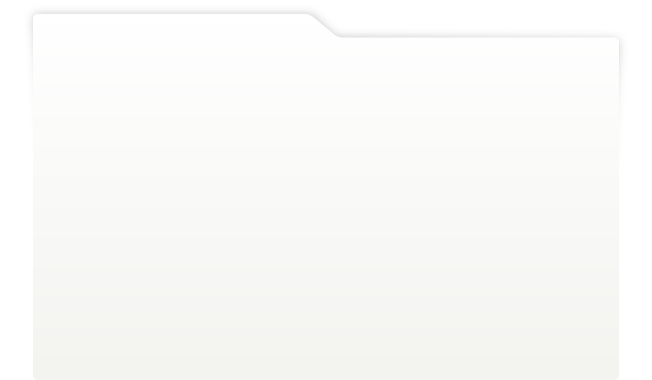
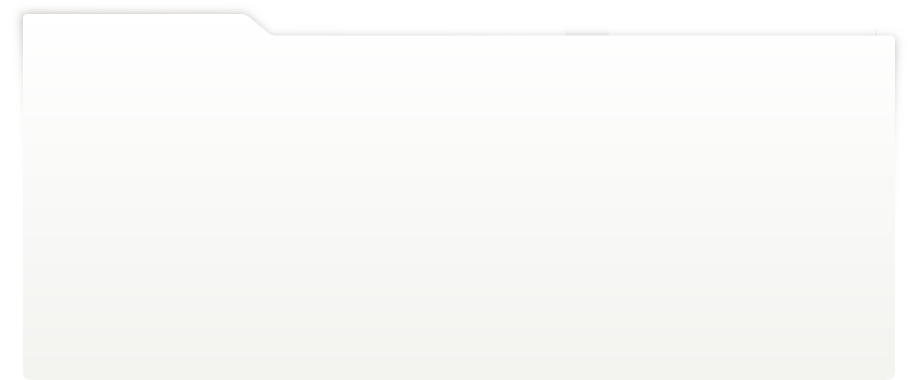
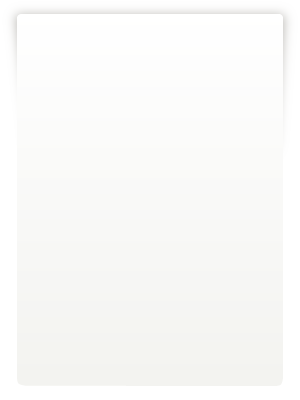
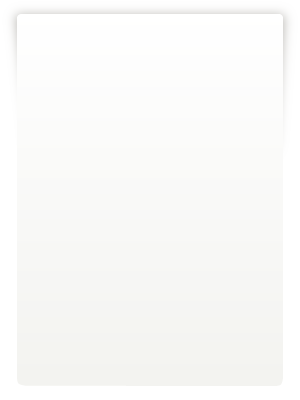
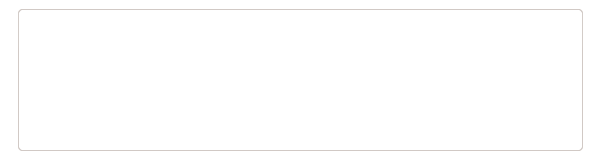
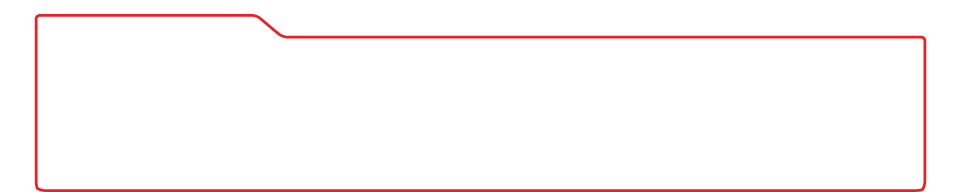
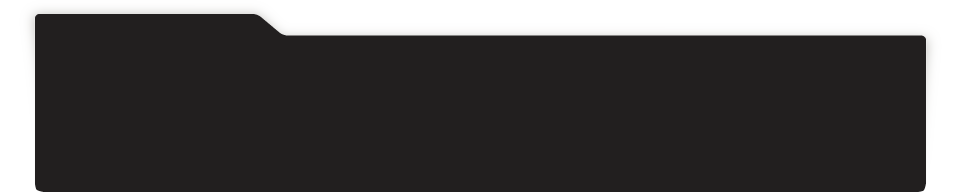
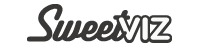
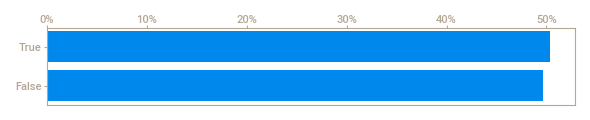
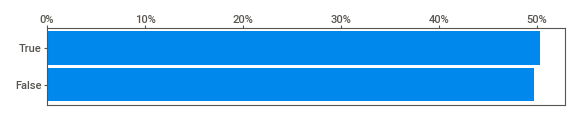
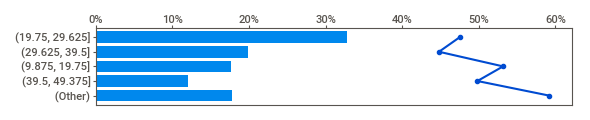
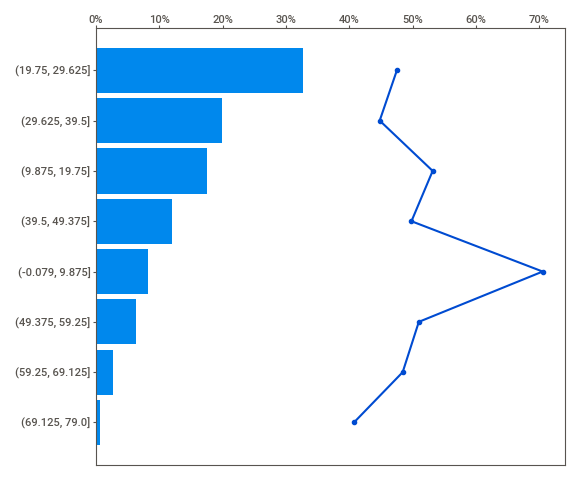
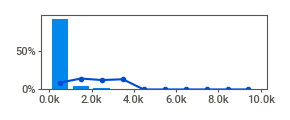
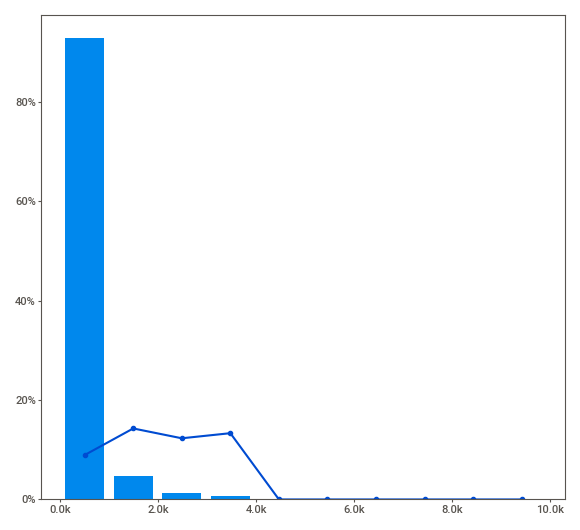
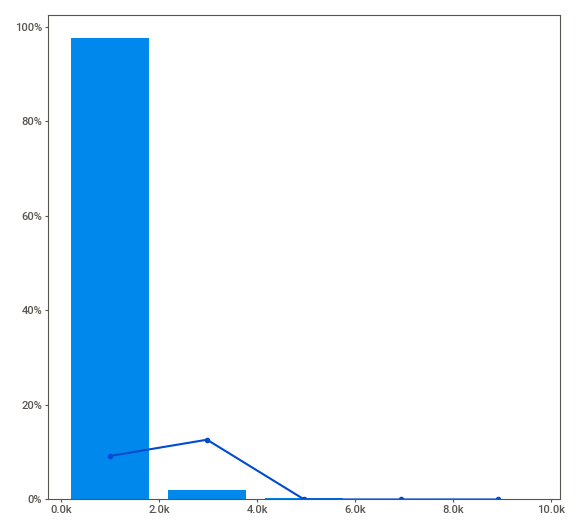
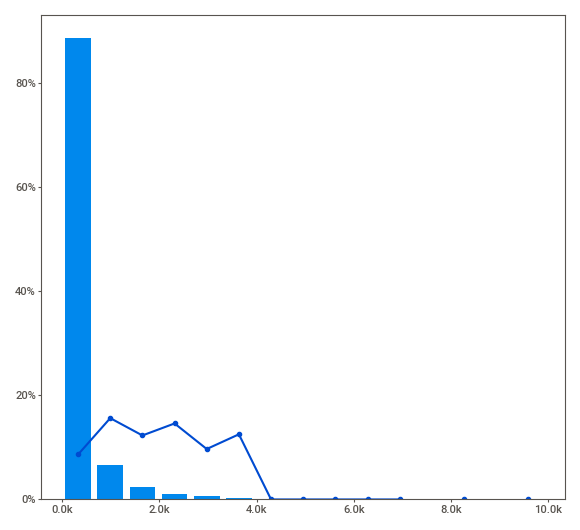
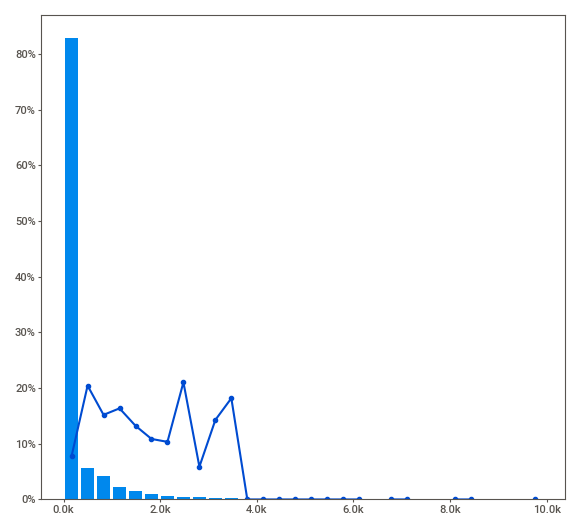
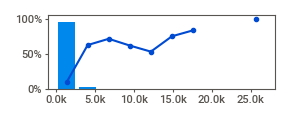
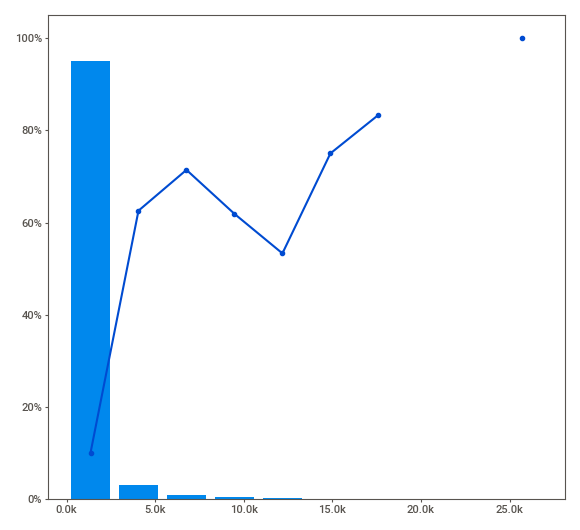
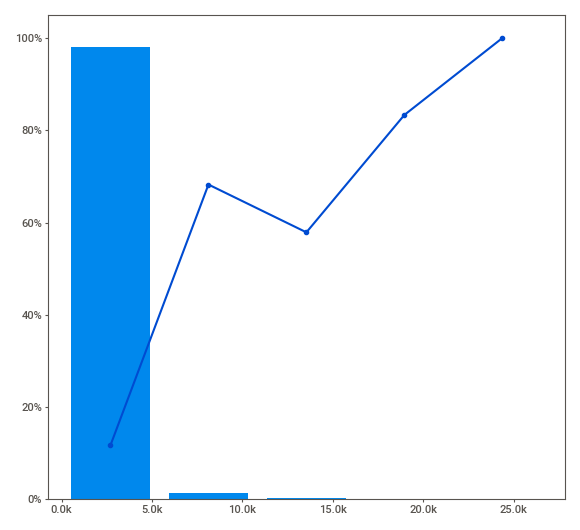
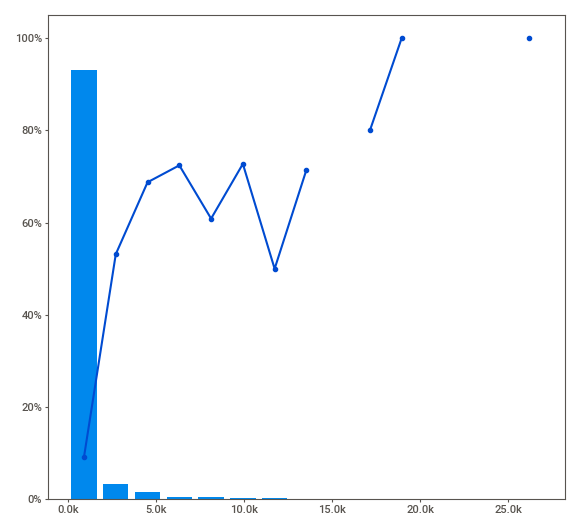
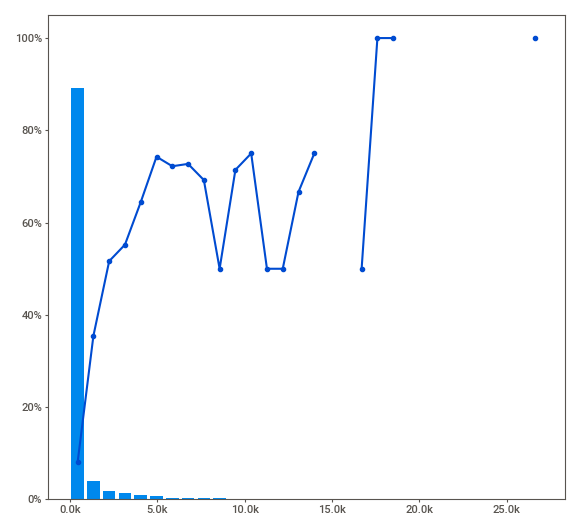
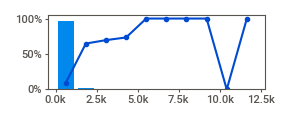
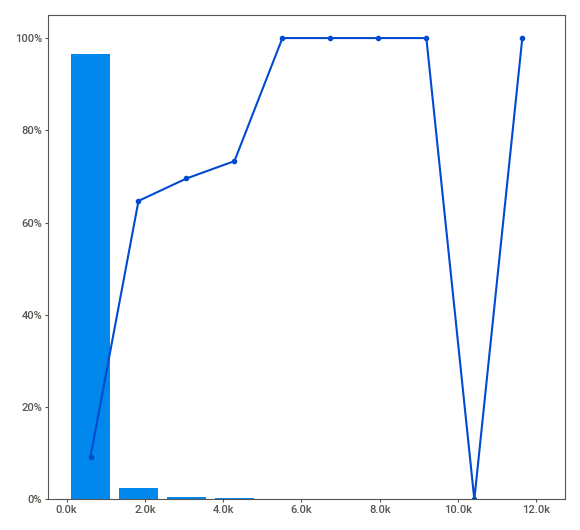
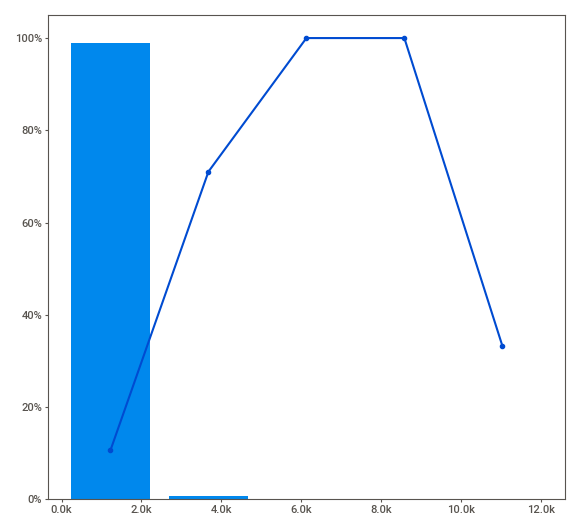
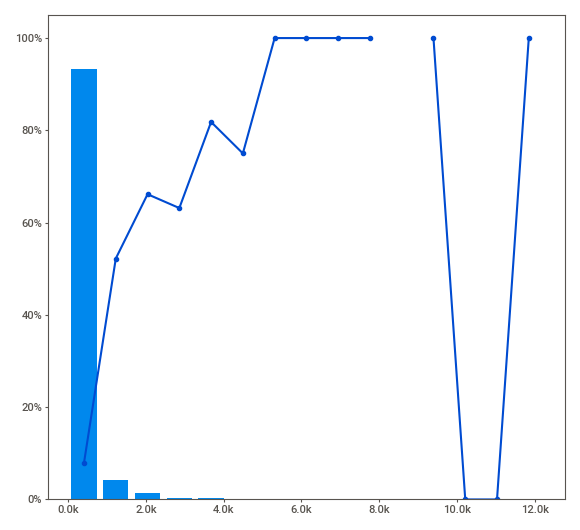
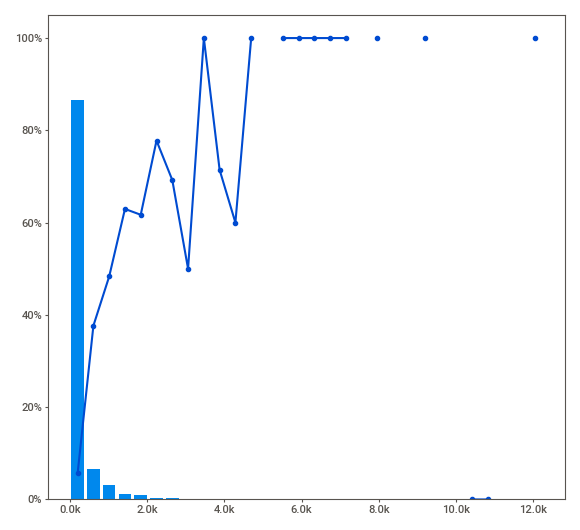
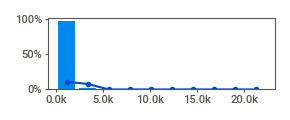
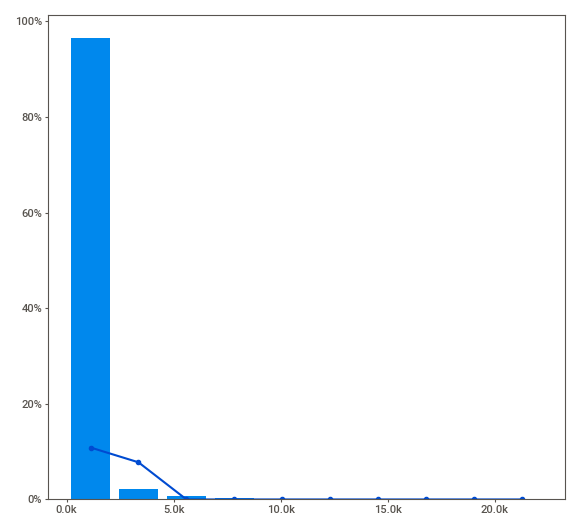
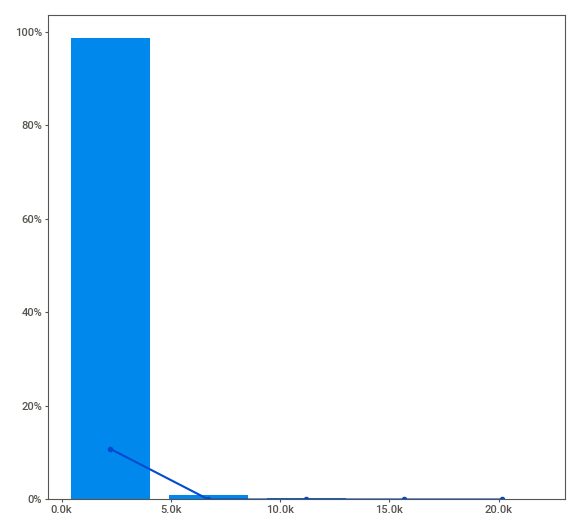
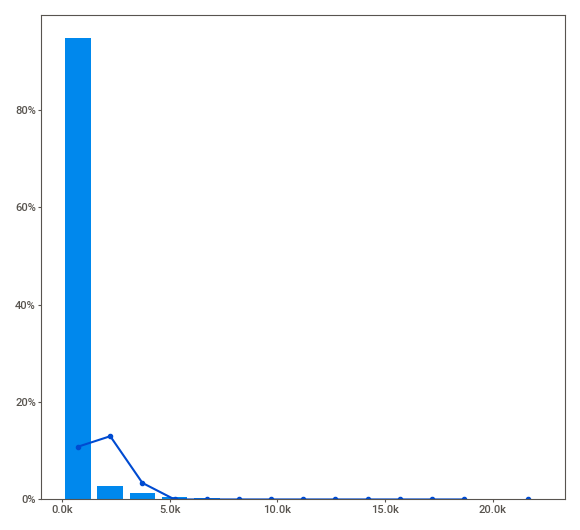
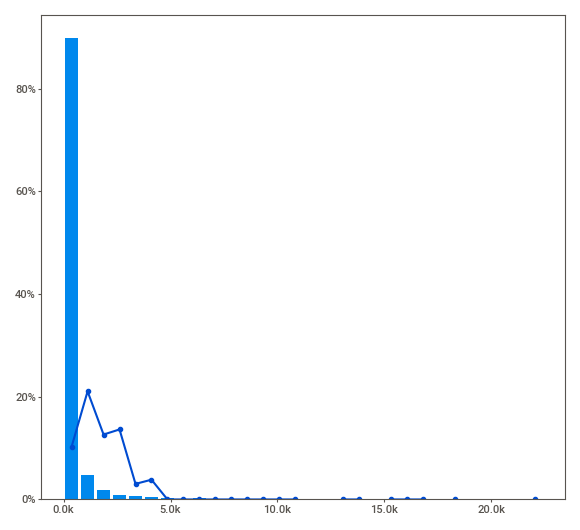
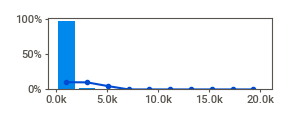
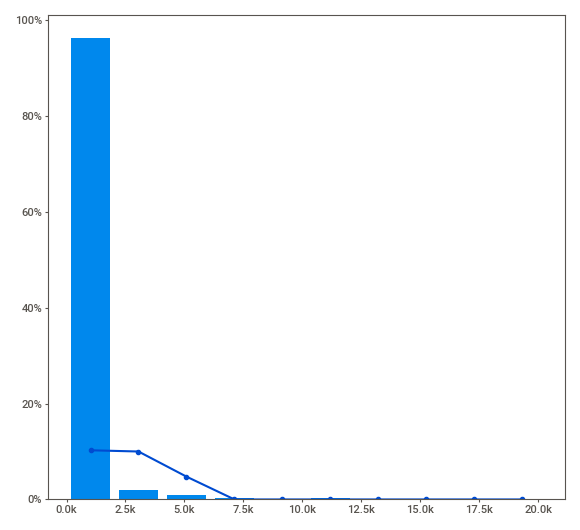
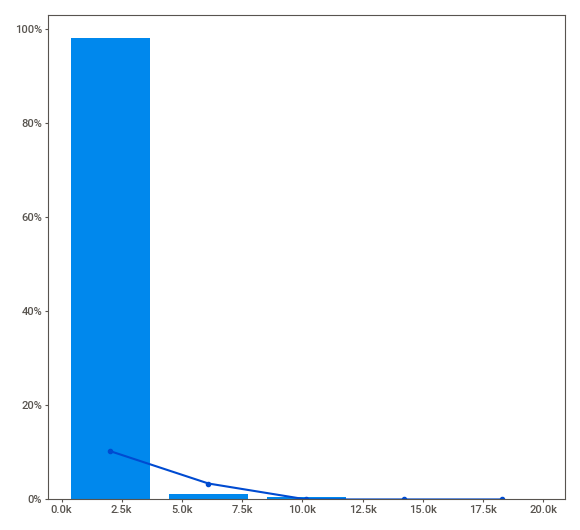
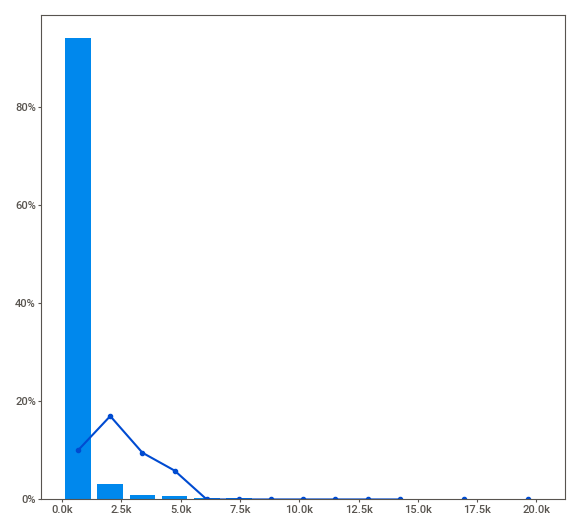
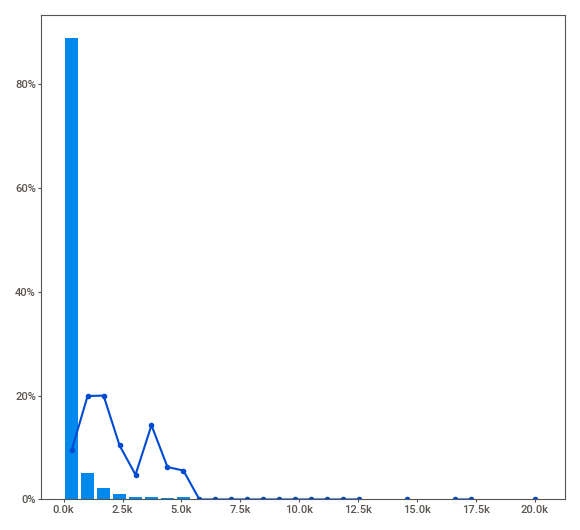
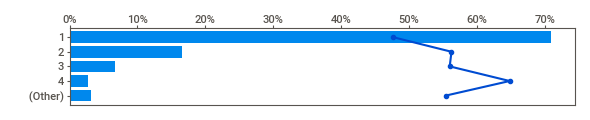
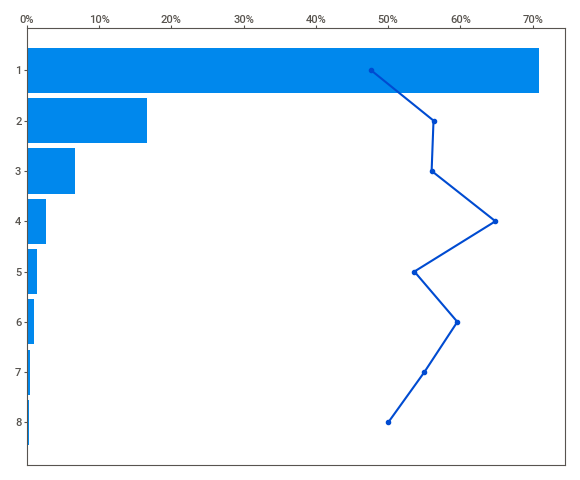
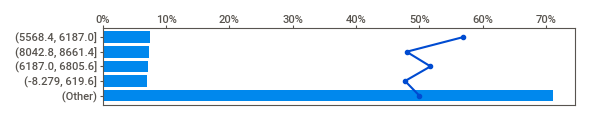
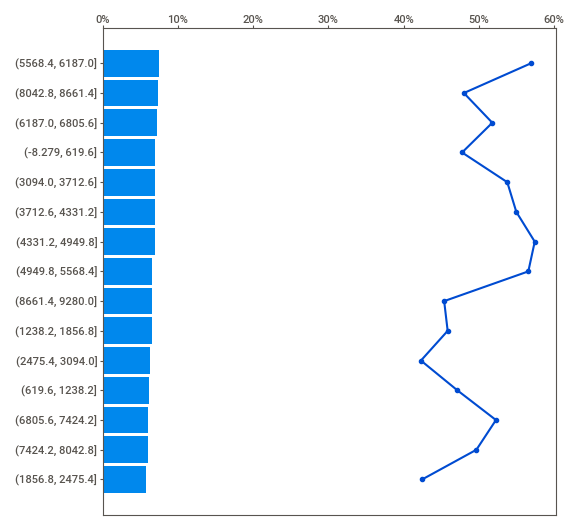
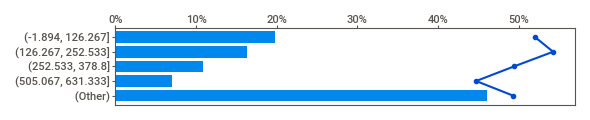
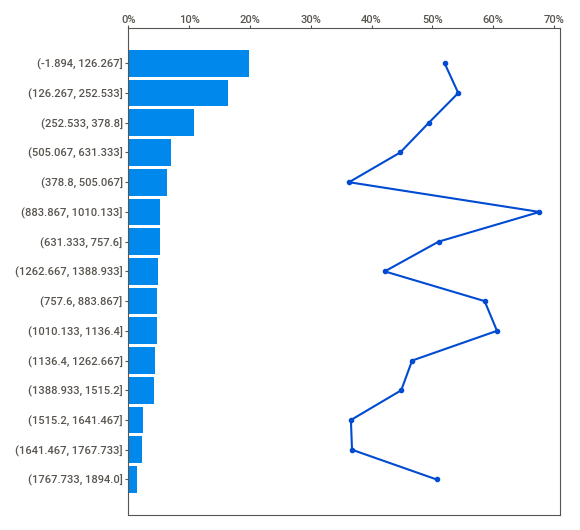
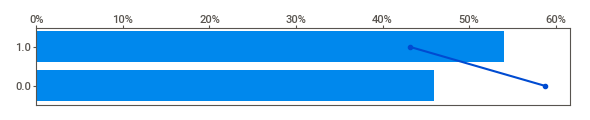
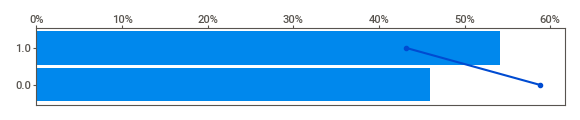
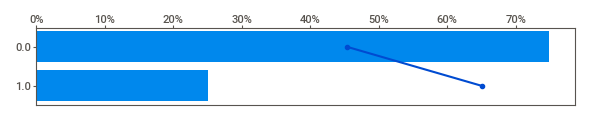
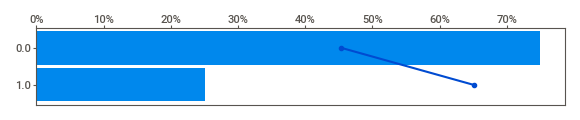
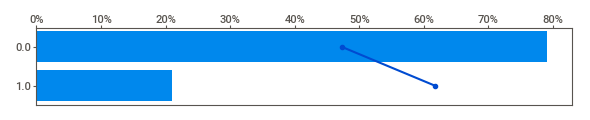
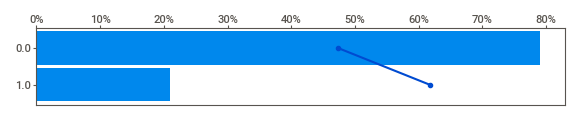
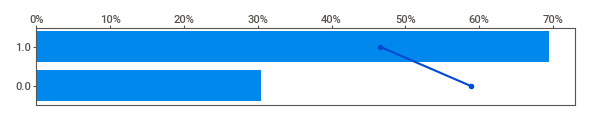
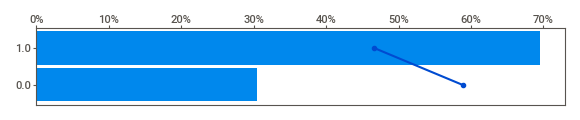
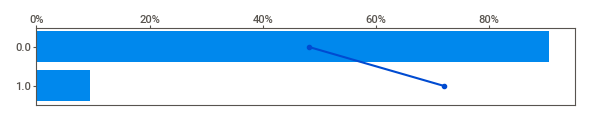
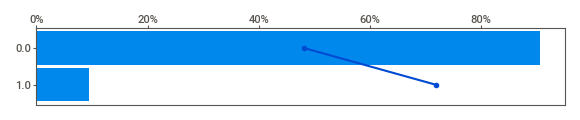
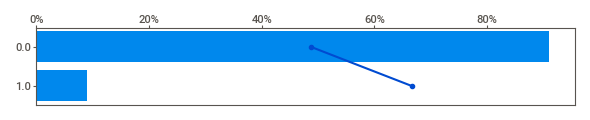
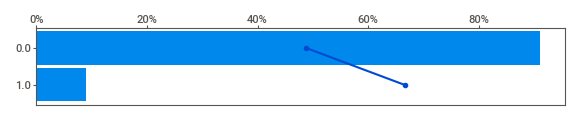
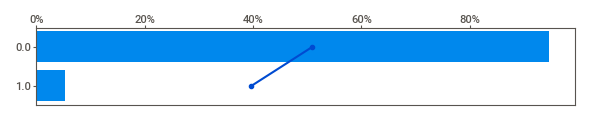
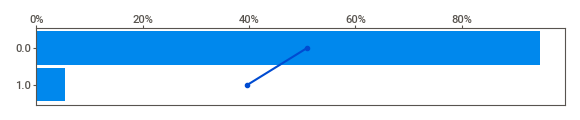
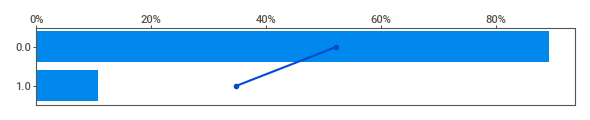
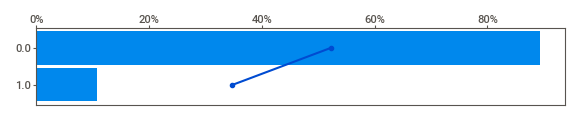
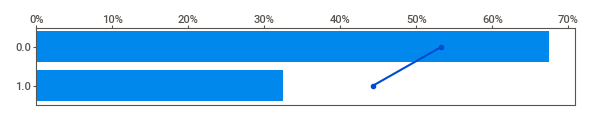
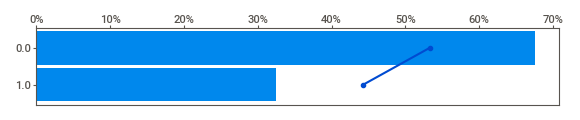
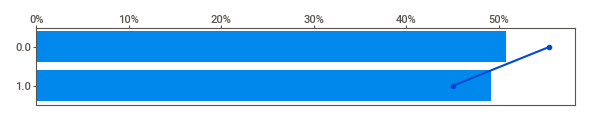
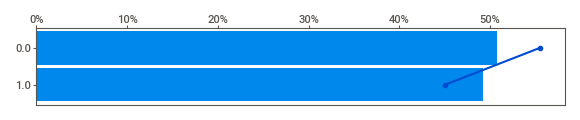
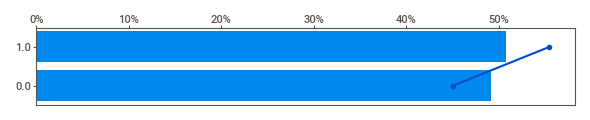
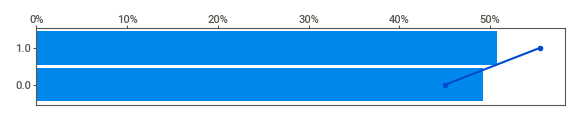
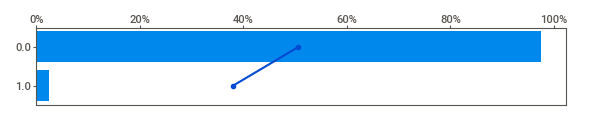
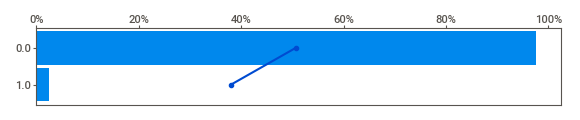
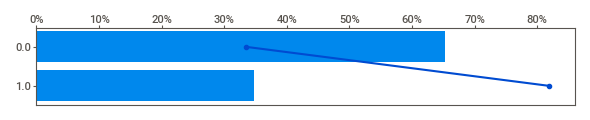
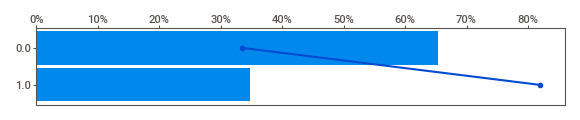
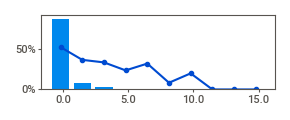
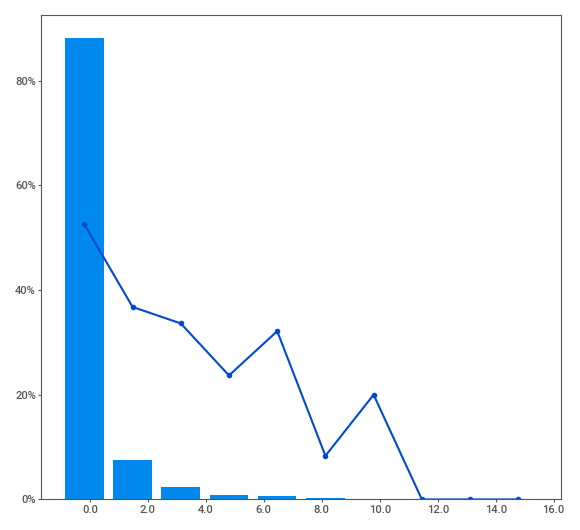
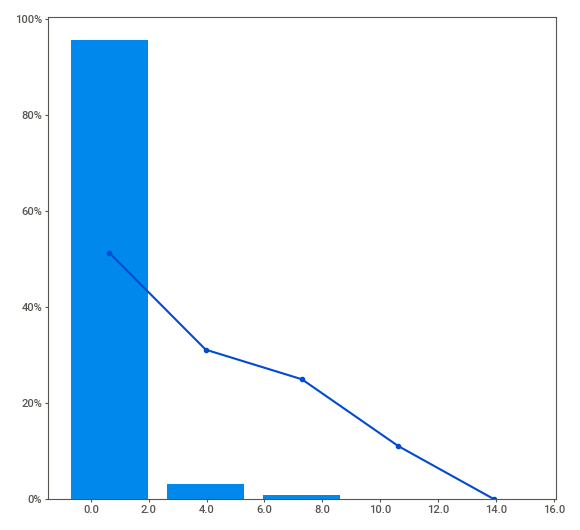
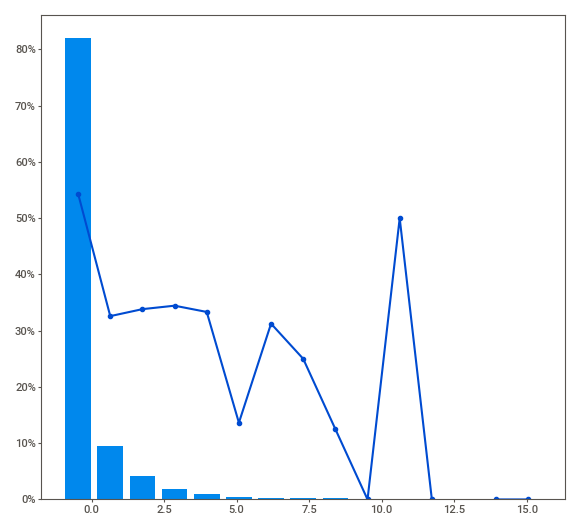
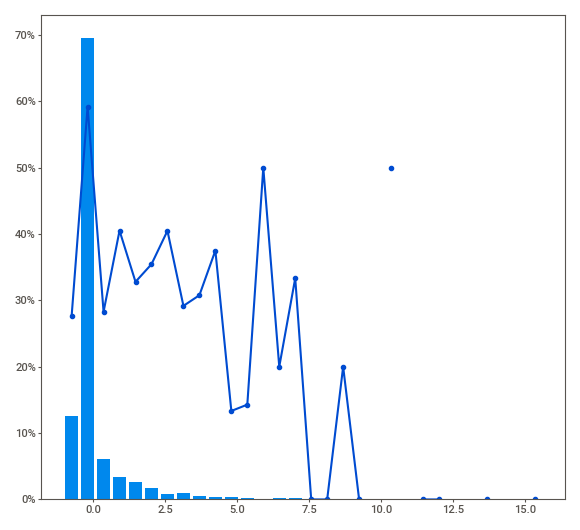
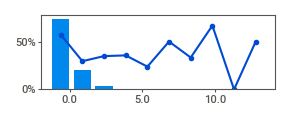
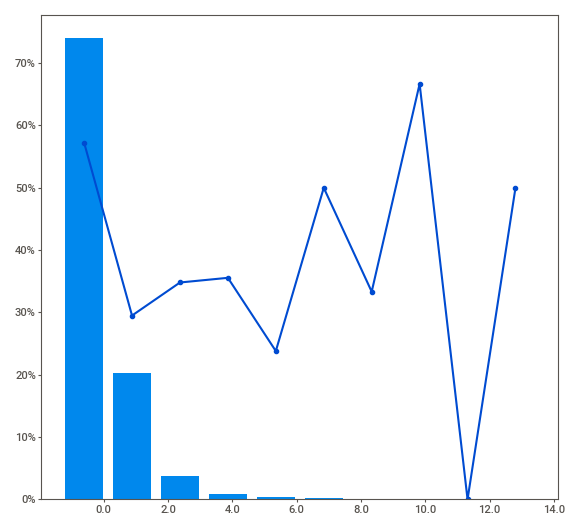
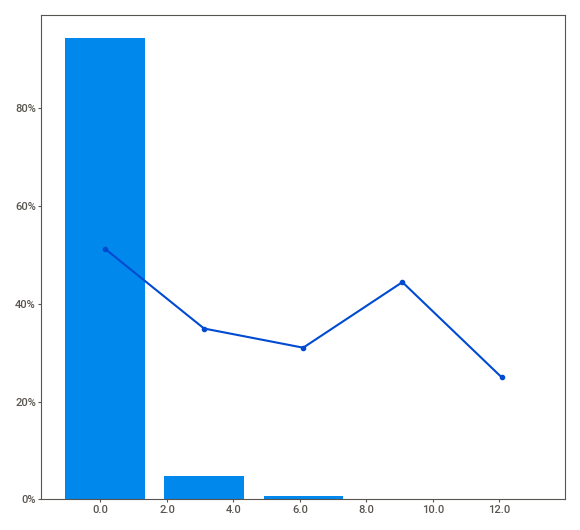
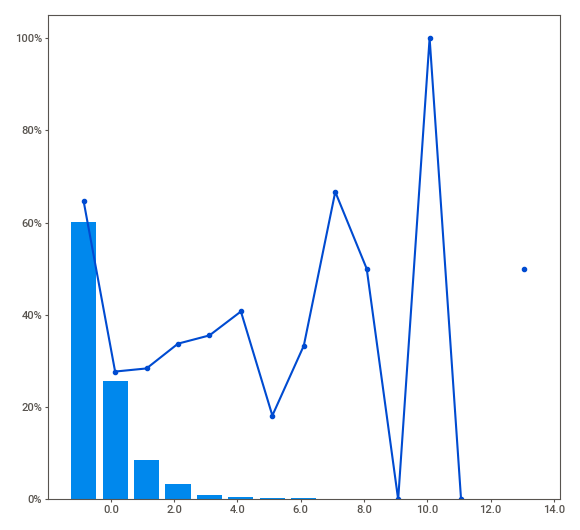
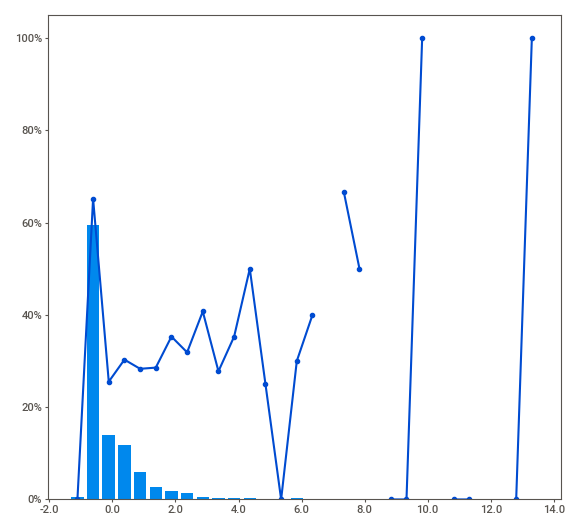
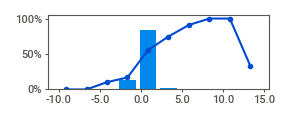
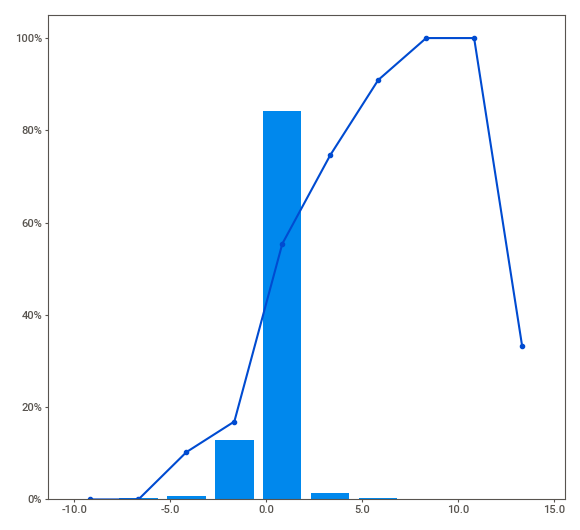
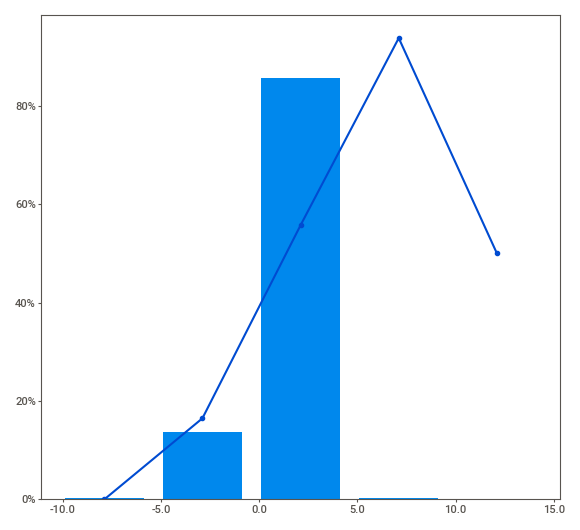
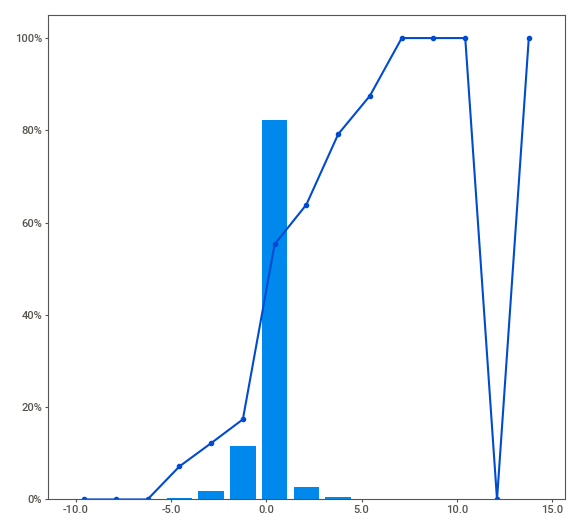
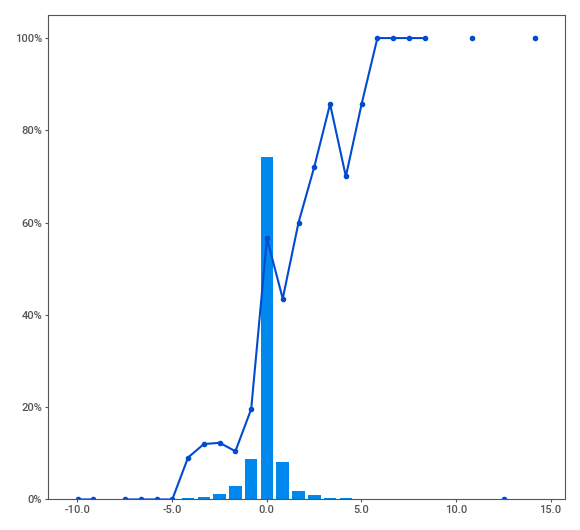
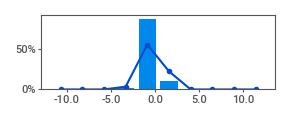
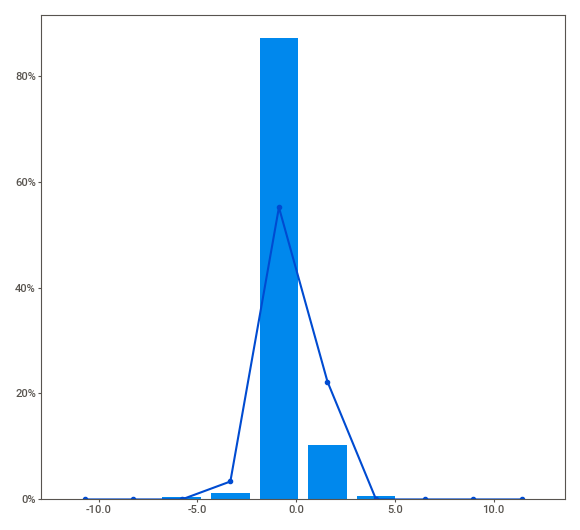
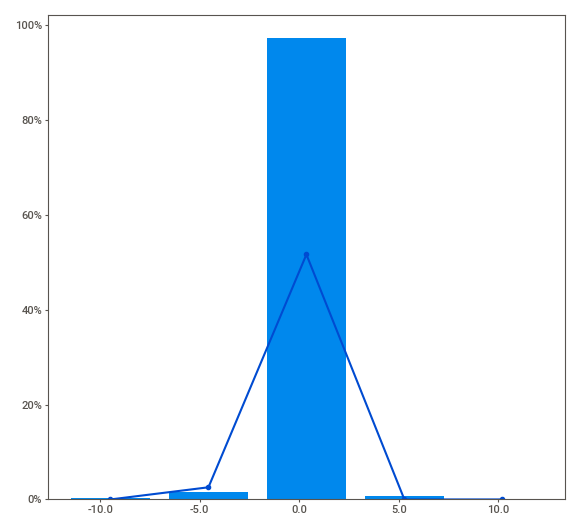
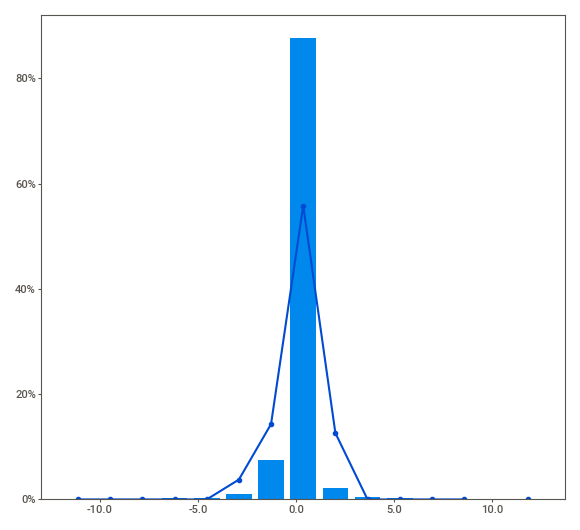
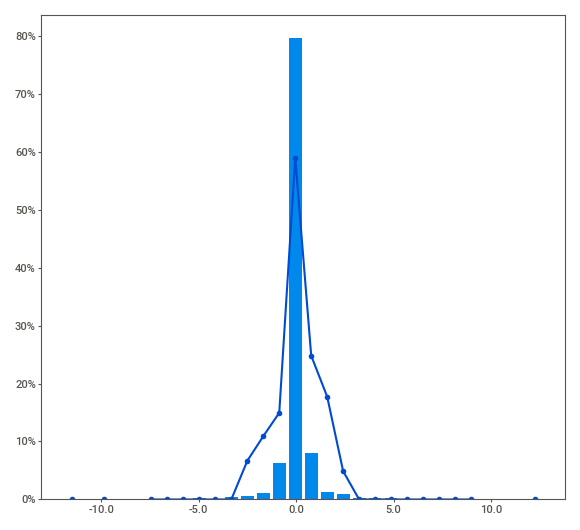
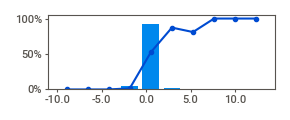
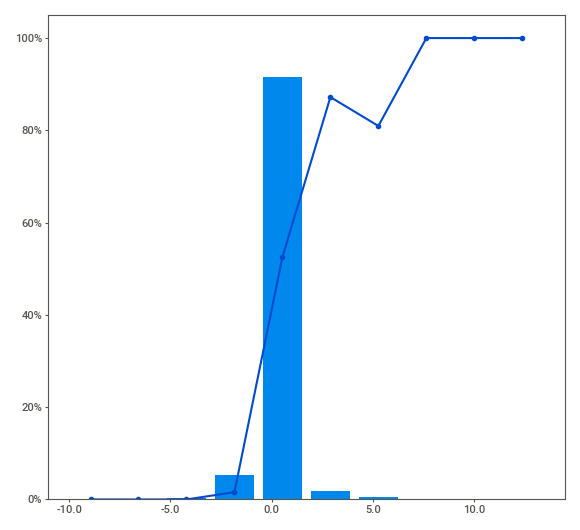
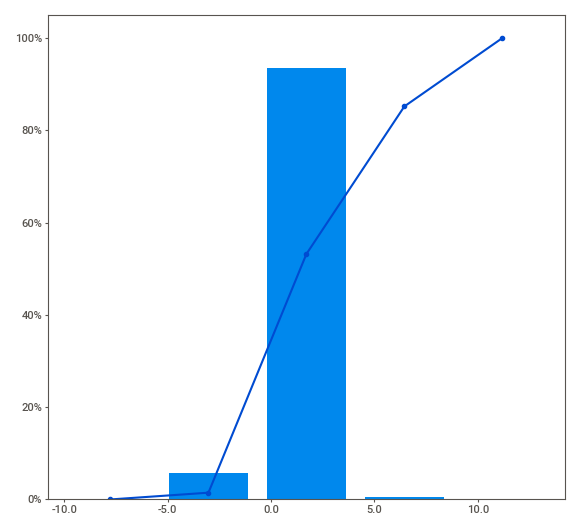
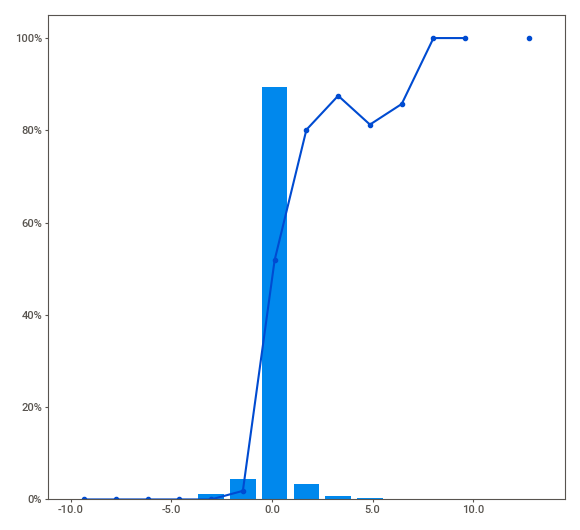
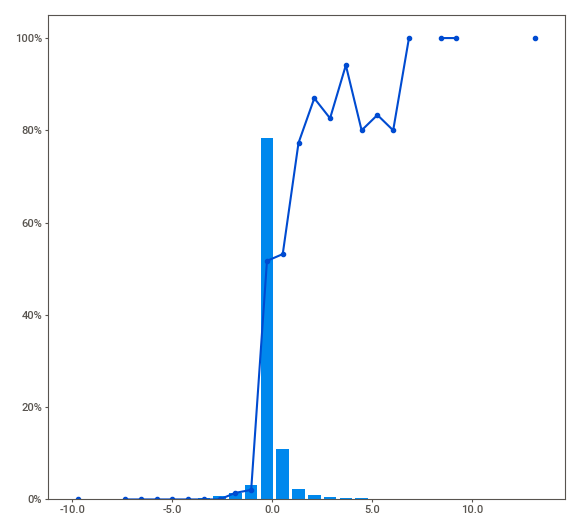
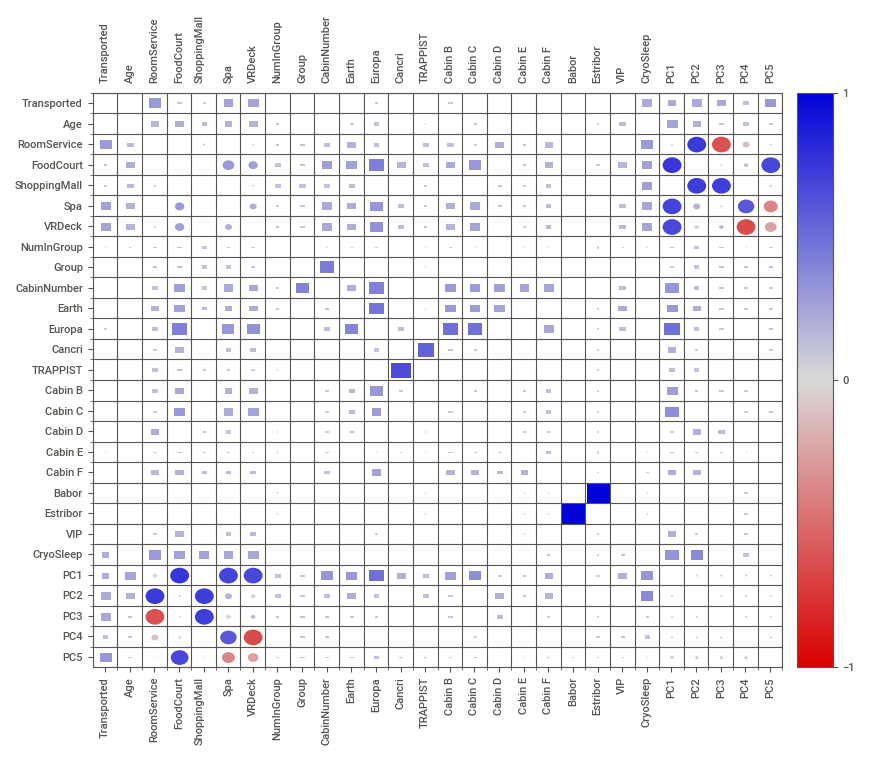
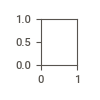

Report 'Report2.html' was saved to storage.


In [18]:
train_mi=new_df.join(y_train_mi)
my_report2 = sweetviz.analyze([train_mi, "Train"], "Transported")
#También podemos hacer lo anterior usando el método show_notebook
my_report2.show_notebook(
    w=None, #Ancho en pixeles o en porcentajes
    h=None, #Altura en pixeles o en porcentajes
    scale=None, #valor entre 0 y 1
    layout='vertical', #vertical es mucho mejor para dispositivos con pantallas pequeñas
    filepath='Report2.html')

---
Después de haber experimentado, definamos la Pipeline a seguir:

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Modelamiento
from  sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

# Definimos la transformación de agrupar Por edad

class agruparPorEdadTransformer():
    def __init__(self):
        pass

    def transform(self,X,y=None):
        X['GroupedAge']=pd.cut(X.Age, bins=8)
        return X

    def fit(self, X, y=None):
        return self

class agruparPorGrupoTransformer():
    def __init__(self):
        pass

    def transform(self,X,y=None):
        X['GroupedGroup']=pd.cut(X.Group, bins=30)
        return X

    def fit(self, X, y=None):
        return self

class agruparPorCabinNumberTransformer():
    def __init__(self):
        pass

    def transform(self,X,y=None):
        X['GroupedCabinNumber']=pd.cut(X.CabinNumber, bins=8)
        return X

    def fit(self, X, y=None):
        return self

class agregarClustersTransformer():
    def __init__(self):
        pass

    def transform(self,X,y=None,names=None):
        kmeans=KMeans(n_clusters=10, max_iter=1000, n_init=10)
        X['Cluster1']= kmeans.fit_predict(X[['VRDeck','FoodCourt','Spa']])
        X['Cluster2']= kmeans.fit_predict(X[['RoomService','ShoppingMall','Spa']])
        X['Cluster3']= kmeans.fit_predict(X[['RoomService','ShoppingMall']])
        X['Cluster4']= kmeans.fit_predict(X[['VRDeck','RoomService','Spa']])
        return X

    def fit(self, X, y=None):
        return self

class agregarPCATransformer():
    def __init__(self):
        pass

    def transform(self,X,y=None):
        pca=PCA()
        X_pca= pca.fit_transform(X[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']])
        res=X.join(pd.DataFrame(X_pca, columns=['PC1','PC2','PC3','PC4','PC5']))
        #return X.reset_index().join(X_pca,how='left').set_index('index')
        return res

    def fit(self, X, y=None):
        return self

class transformarDatosTransformer():
    def __init__(self):
        pass

    def transform(self,X,y=None):
        return transformacion_inicial_datos(X)

    def fit(self, X, y=None):
        return self

class agregarNombresColumnas():
    def __init__(self):
        pass

    def transform(self,X,y=None,new_cols=[]):
        nombres=numeric_features+grouped_features+['Earth','Europa','Mars','Cancri','PSO','TRAPPIST','Cabin A','Cabin B','Cabin C','Cabin D','Cabin E','Cabin F', 'Cabin G','Cabin T','Age<10','Age<20','Age<30','Age<40','Age<50','Age<60','Age<70','Age<80']+VIP_feature+CryoSleep_feature
        return pd.DataFrame(X,columns=nombres)

    def fit(self, X, y=None):
        return self
class eliminarColumnas():
    def __init__(self):
        pass

    def transform(self,X,y=None,):

        return X.drop(['Mars','PSO','Cabin A','Cabin G','Cabin T', 'Age<20','Age<30','Age<40','Age<50','Age<60','Age<70','CabinNumber','Age'],axis=1)

    def fit(self, X, y=None):
        return self

# Definimos diferentes características y la transformer pipeline
categorical_features= ["HomePlanet","Destination","CabinDeck",'GroupedAge']
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])

grouped_features = ["CabinSide",'GroupedGroup','GroupedCabinNumber']
grouped_transformer= Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ])

VIP_feature = ["VIP"]
VIP_transformer = Pipeline (steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ])

CryoSleep_feature = ["CryoSleep"]
CryoSleep_transformer = Pipeline (steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])


numeric_features = ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck","CabinNumber"]
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ])

# Ajustar los pasos de preprocesamiento: llenar los valores faltantes y luego convertir todos los datos a números
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("group", grouped_transformer, grouped_features),
    ("cat", categorical_transformer, categorical_features),
    ("vip", VIP_transformer, VIP_feature),
    ("cryo", CryoSleep_transformer, CryoSleep_feature),
    ])

from catboost import CatBoostClassifier
pipeline1=Pipeline(steps=[
                      ('tra', transformarDatosTransformer()),
                      ('grpAge', agruparPorEdadTransformer()),
                      ('groupedGroup', agruparPorGrupoTransformer()),
                      ('groupedCabinNumber',agruparPorCabinNumberTransformer()),
                      ("preprocessor", preprocessor),
                      ('std', StandardScaler()),
                      ('agregarNombres',agregarNombresColumnas()),
                      ('agregarCluster',agregarClustersTransformer()),
                      ('agregarPCA',agregarPCATransformer()),
                      #('eli', eliminarColumnas()),
                      #("model", CatBoostClassifier(
                      #    iterations=300,
                      #    eval_metric='Accuracy',
                      #    verbose=0
                      #)),
])





In [32]:
train = pd.read_csv("/content/drive/MyDrive/Ciencia de datos/Proyectos de ciencias de datos/Titanic espacial/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Ciencia de datos/Proyectos de ciencias de datos/Titanic espacial/test.csv")
X= train.copy().dropna(axis=0)
y= X['Transported']
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.25, random_state=6)

In [33]:
X_train_trans=pipeline1.fit_transform(X_train)
X_train_trans.shape

#X_trans=pipeline1.fit_transform(X)

(4954, 43)

In [34]:
y_train=y_train.reset_index().drop(['index'],axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


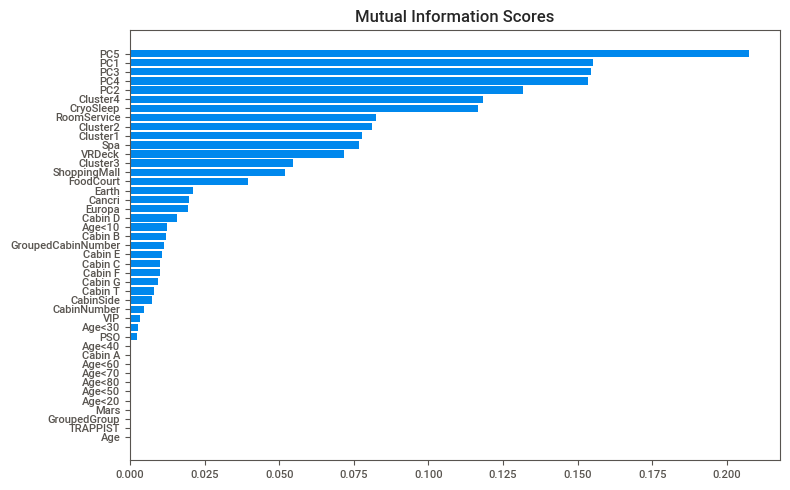

In [35]:
mi_scores=make_mi_scores_classification(X_train_trans,y_train)
plot_mi_scores(mi_scores)

                                             |          | [  0%]   00:00 -> (? left)

/usr/local/lib/python3.10/dist-packages/sweetviz/graph.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figure.savefig(as_raw_bytes, format='png', transparent=True)



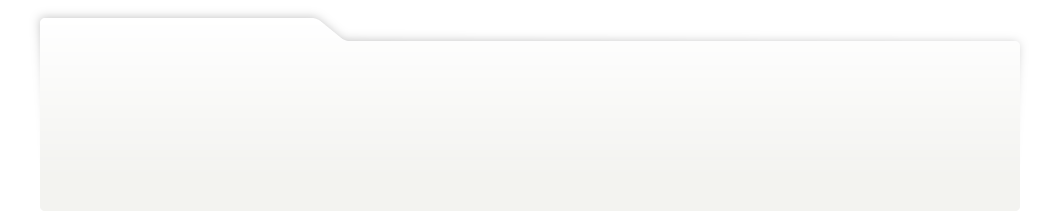
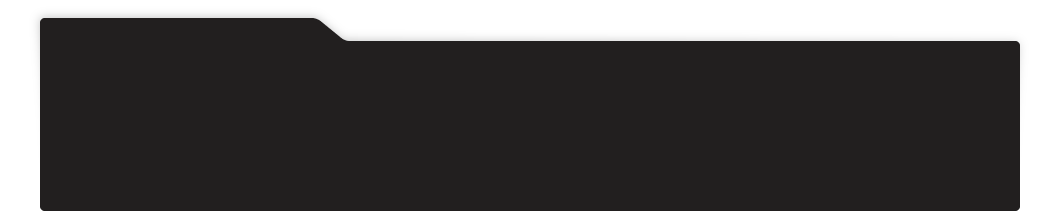
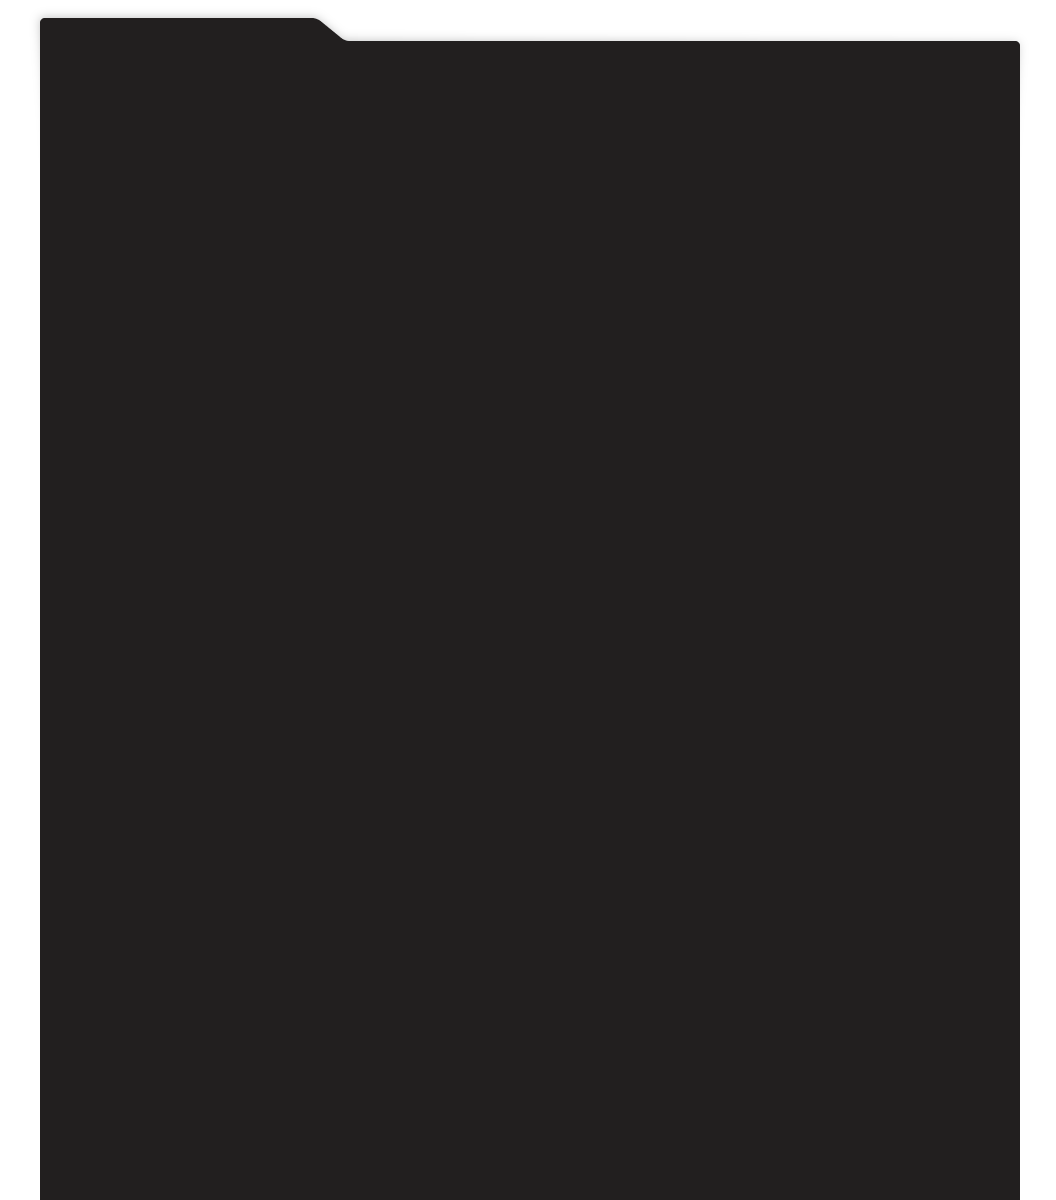
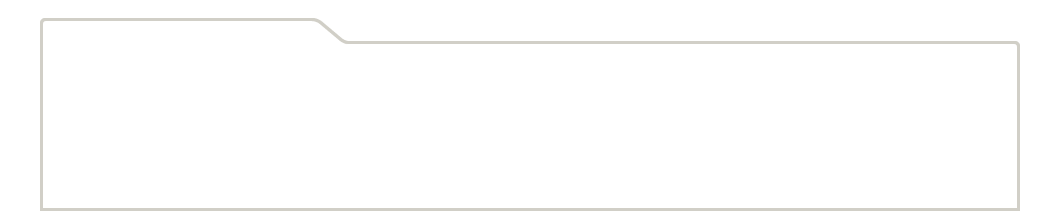
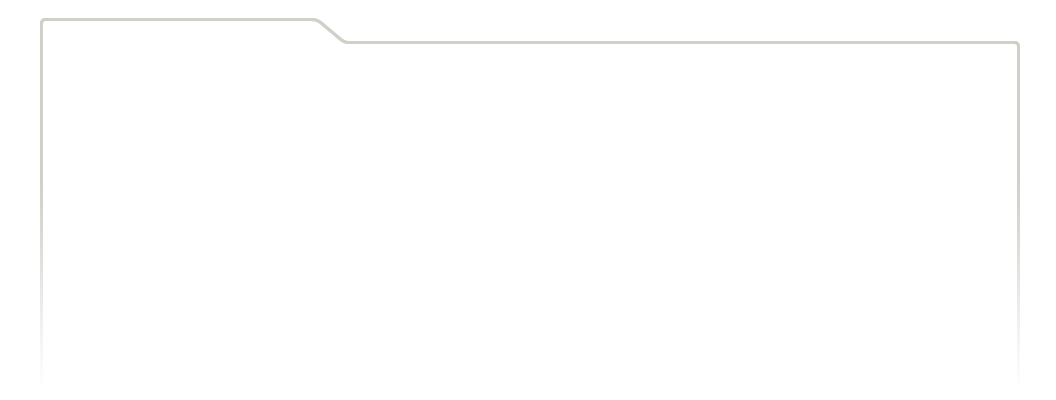
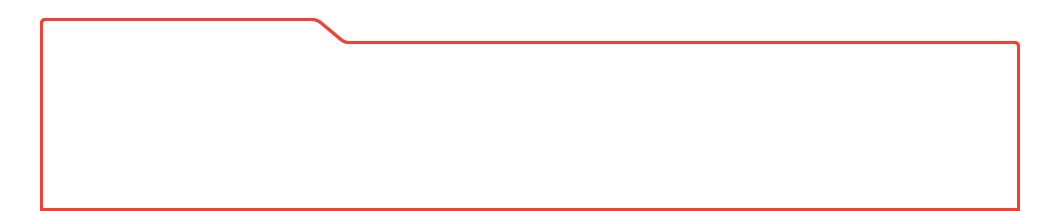
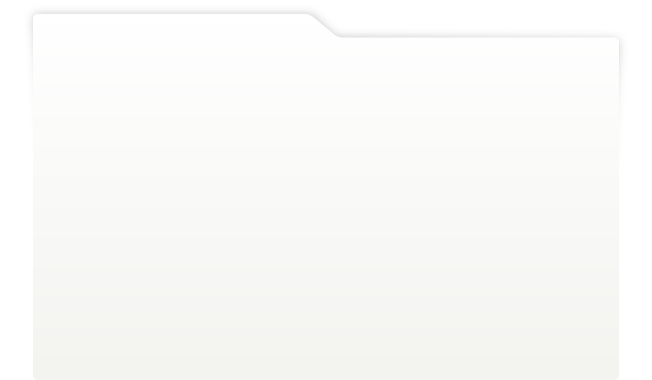
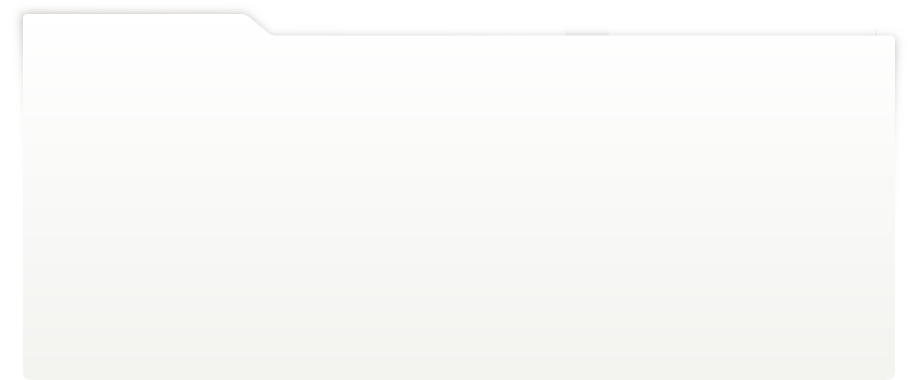
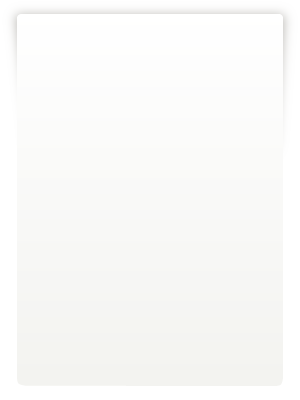
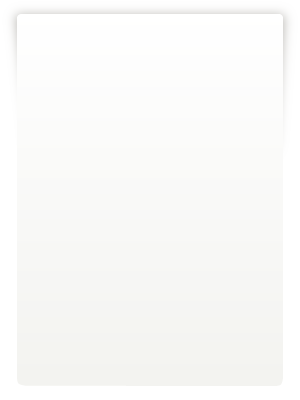
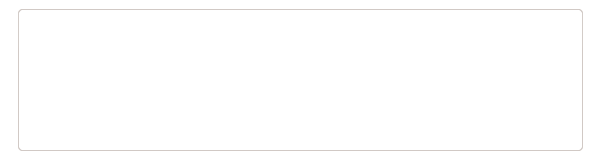
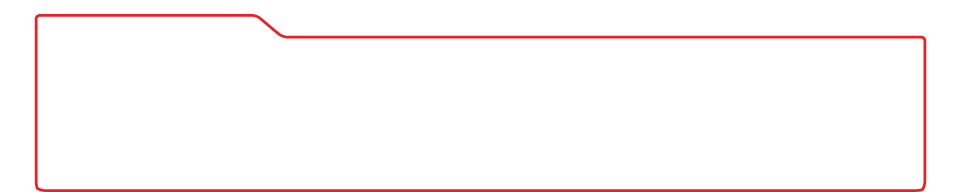
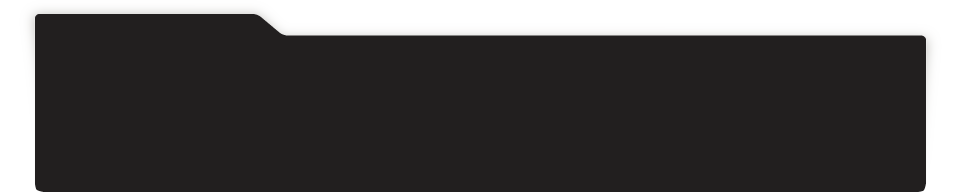
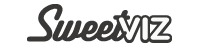
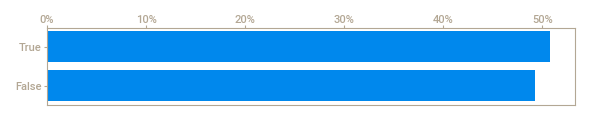
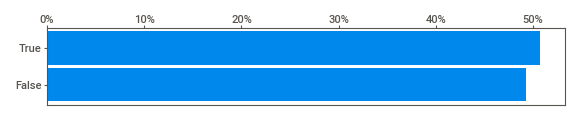
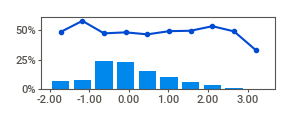
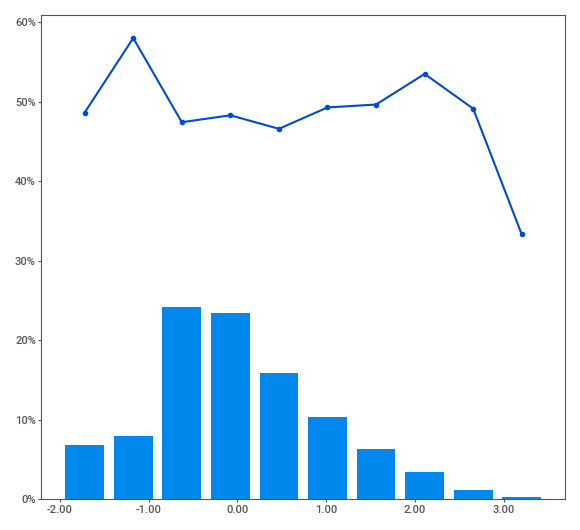
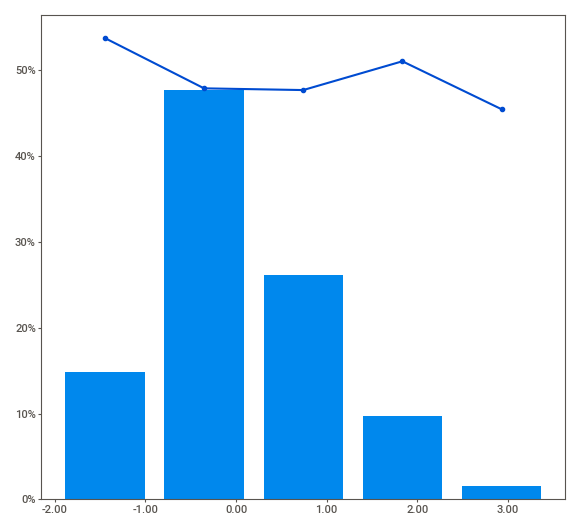
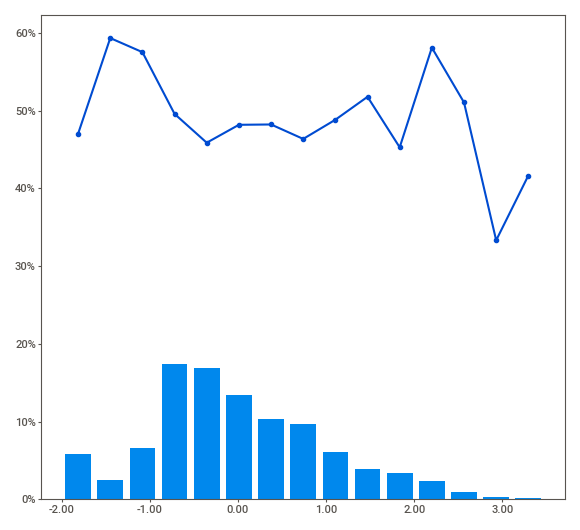
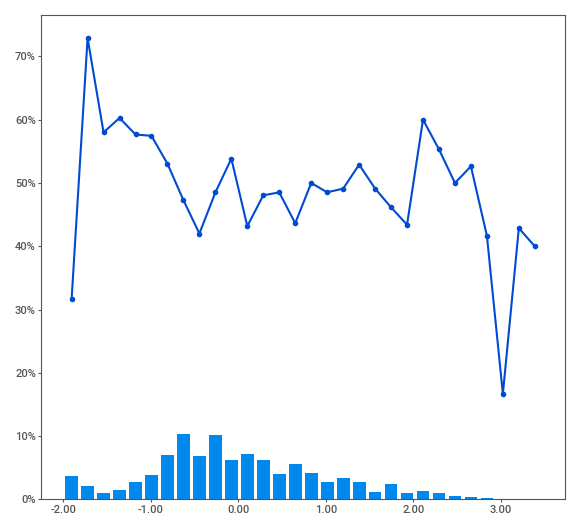
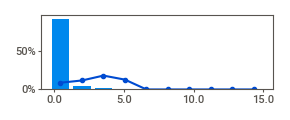
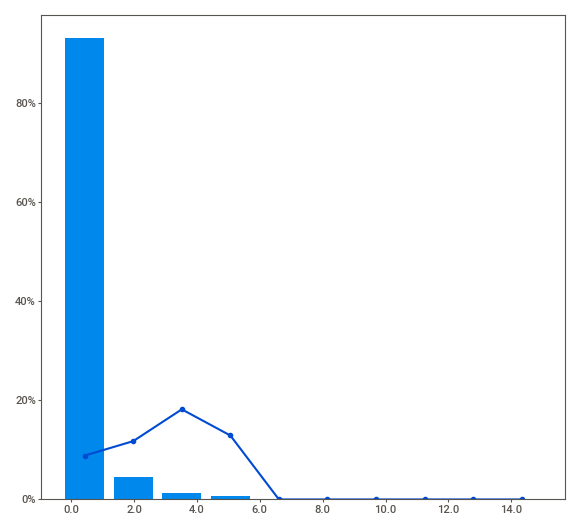
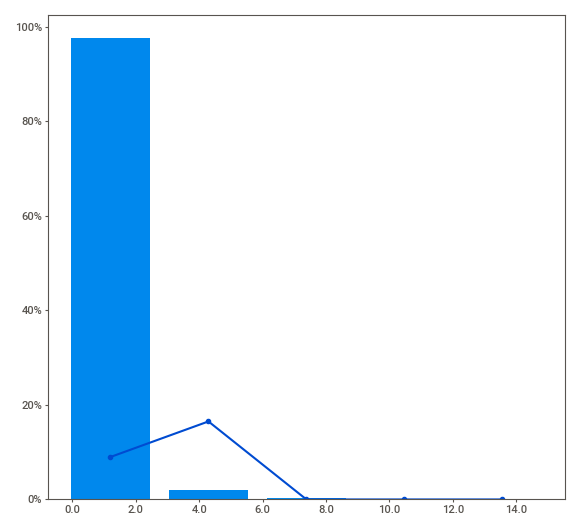
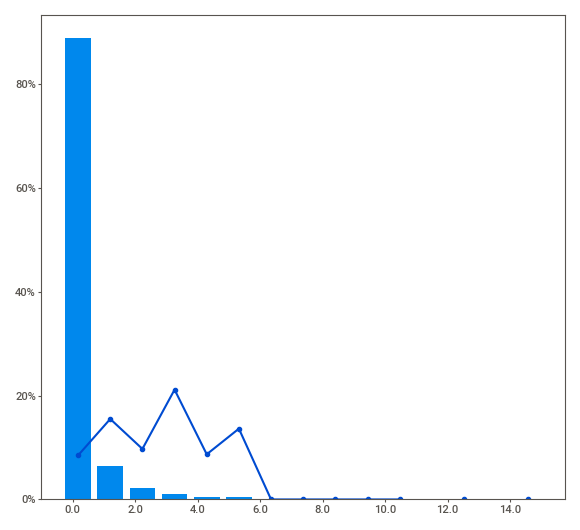
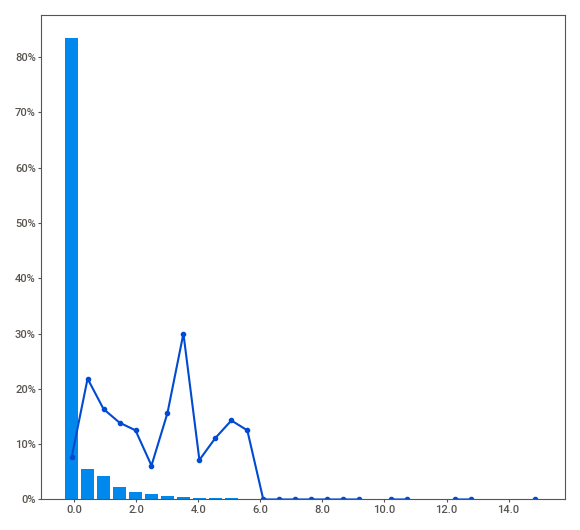
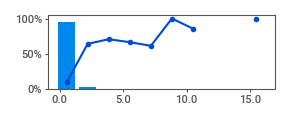
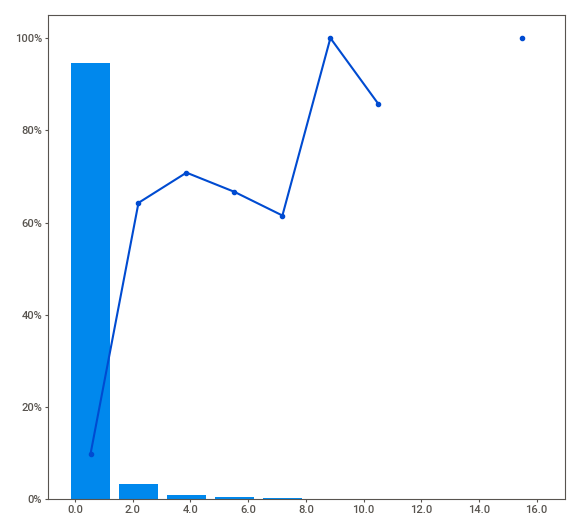
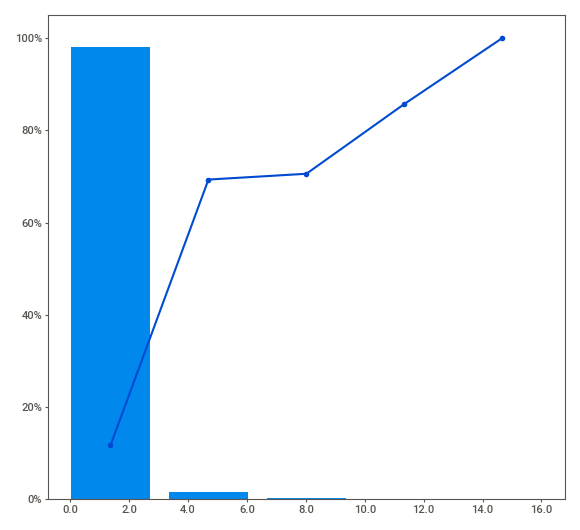
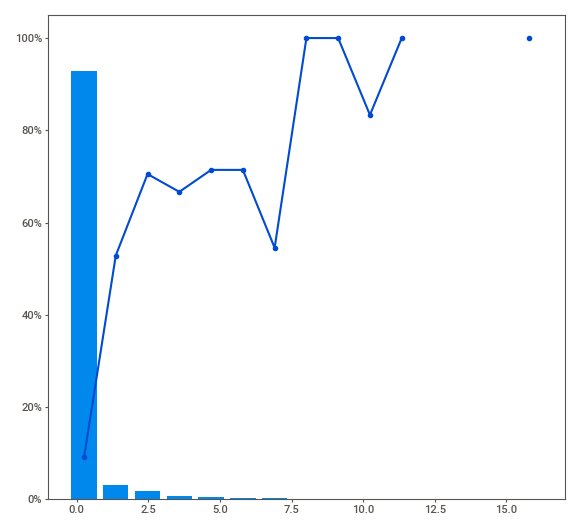
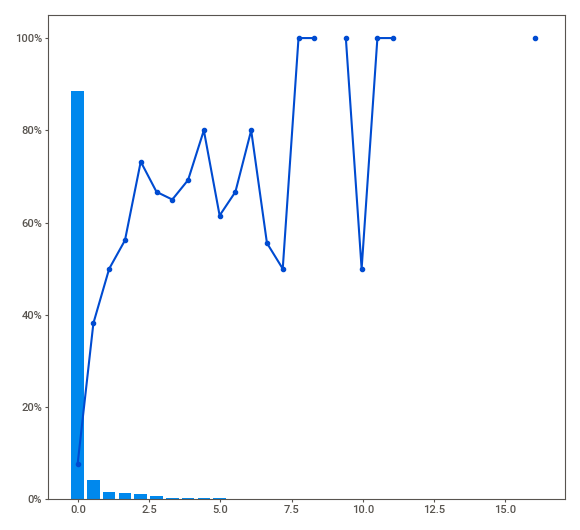
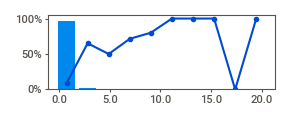
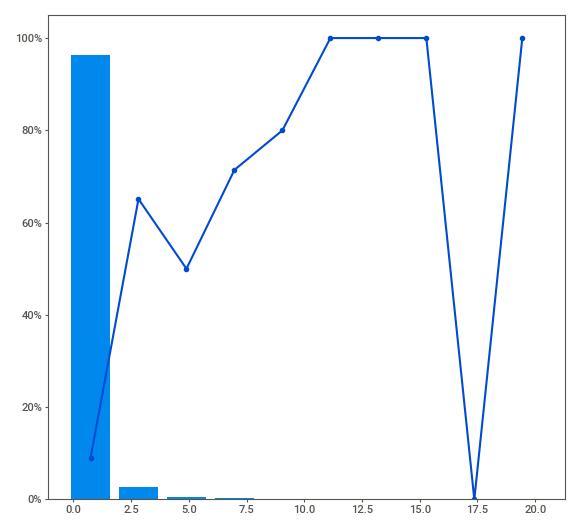
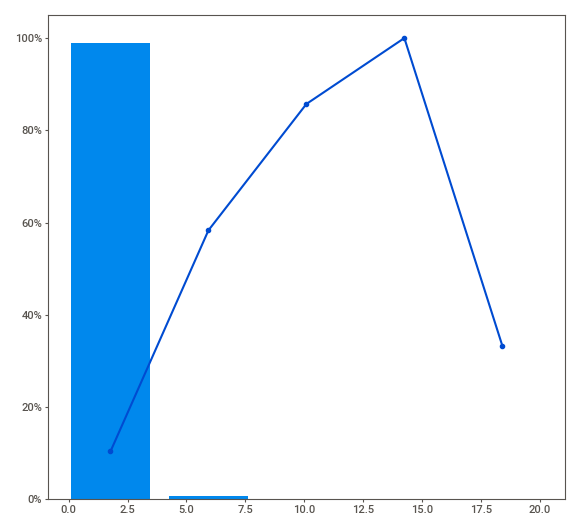
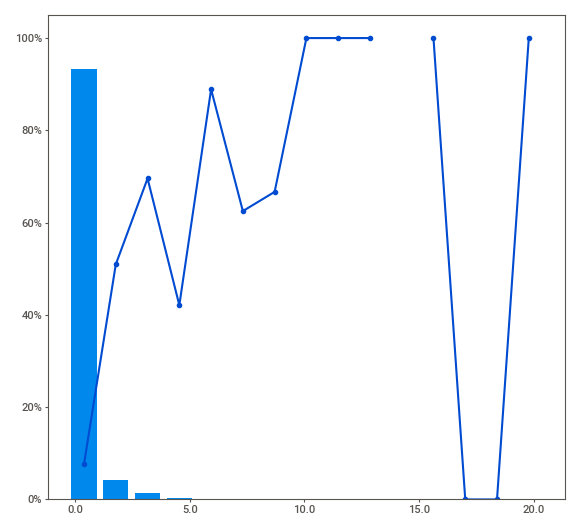
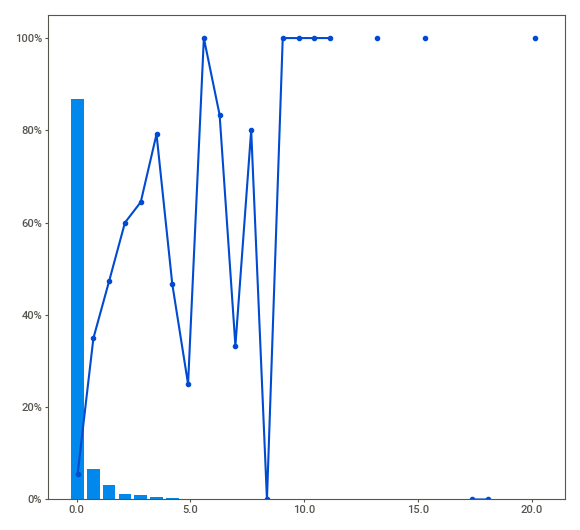
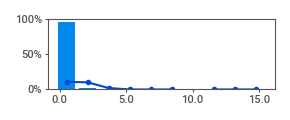
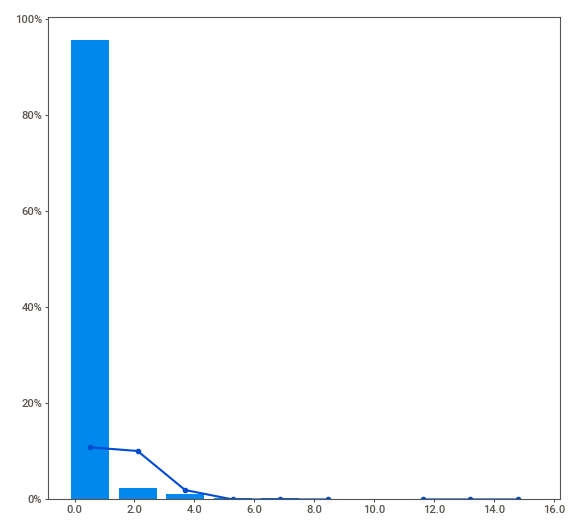
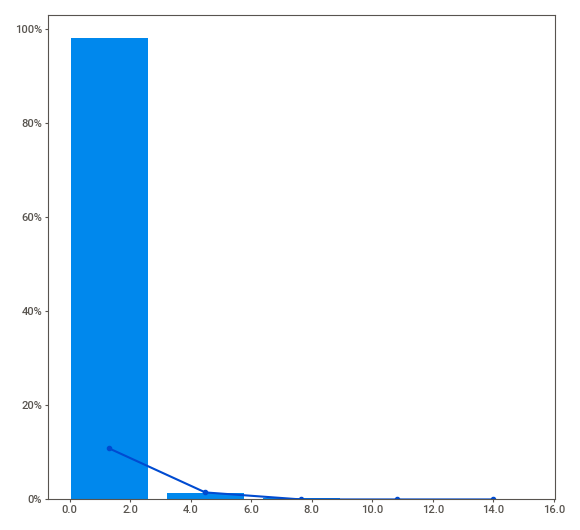
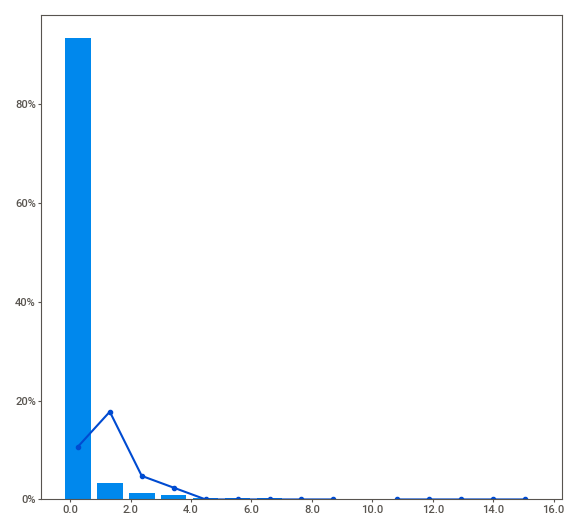
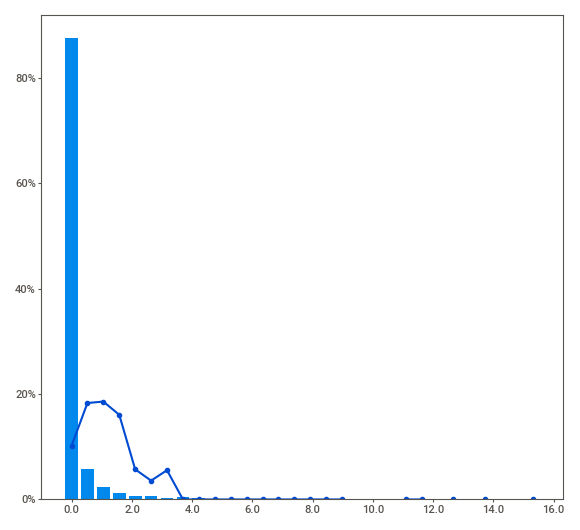
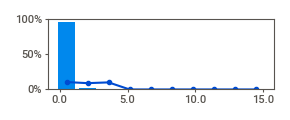
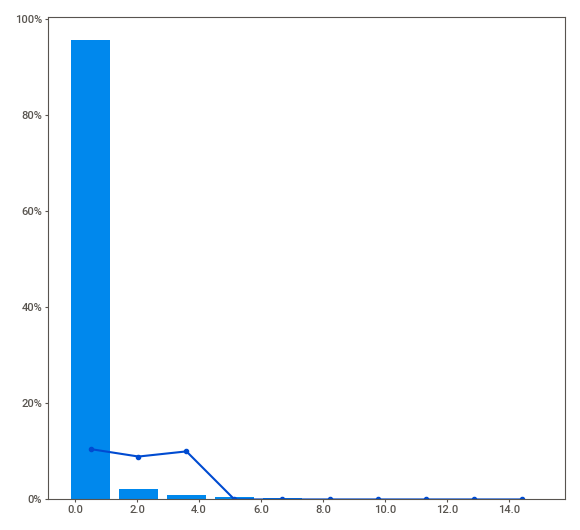
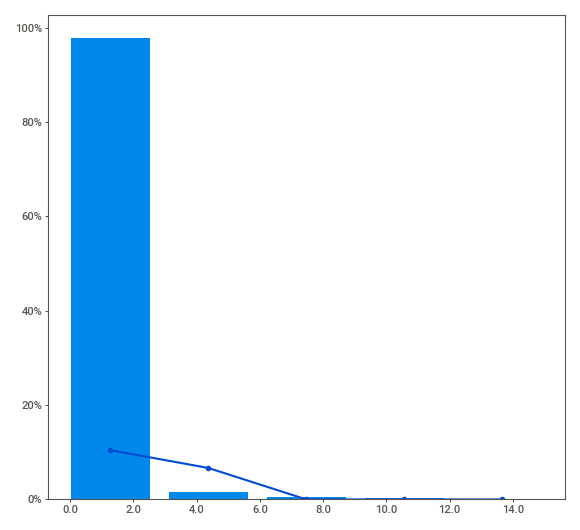
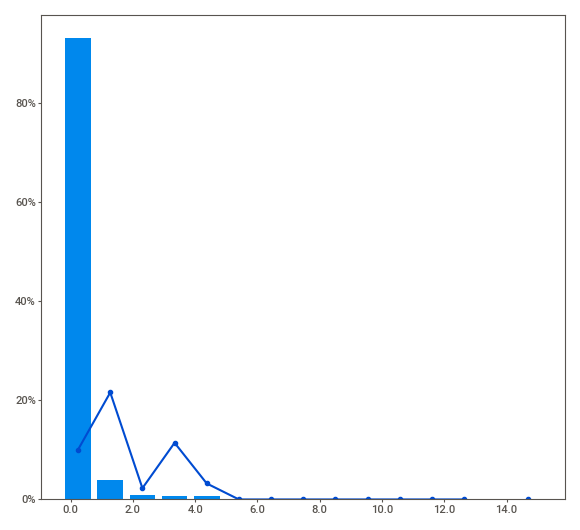
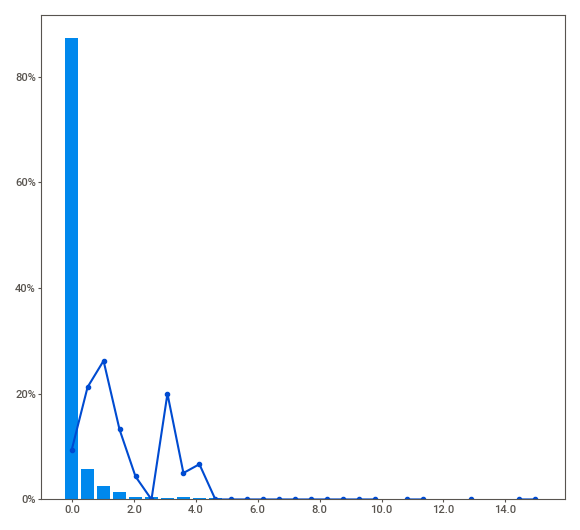
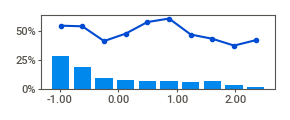
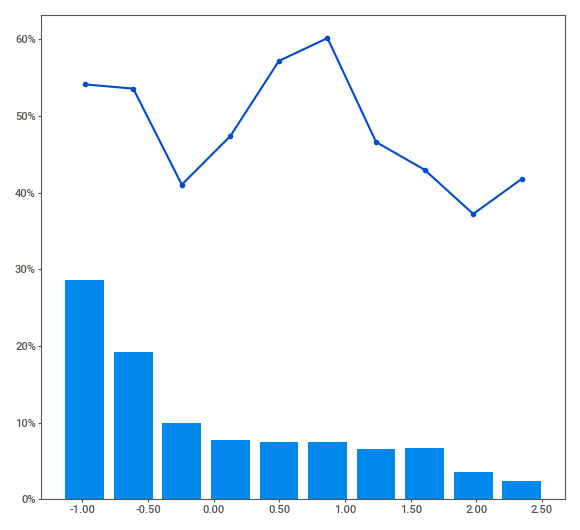
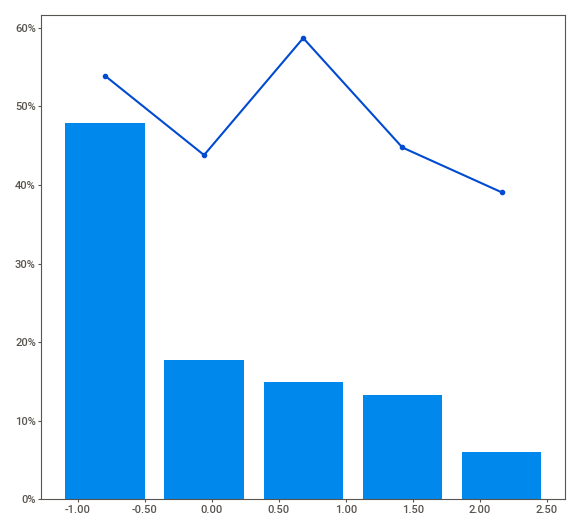
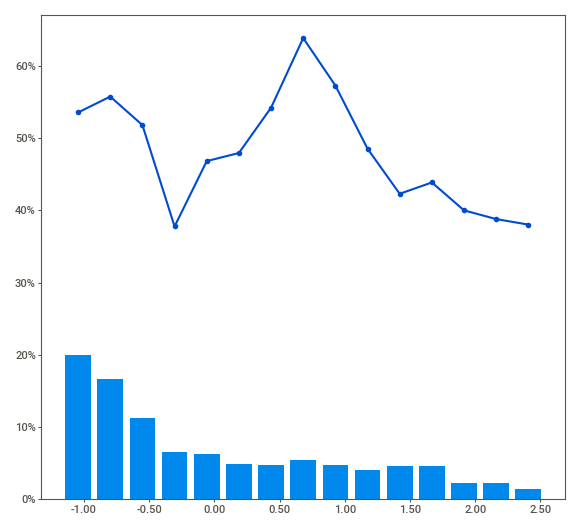
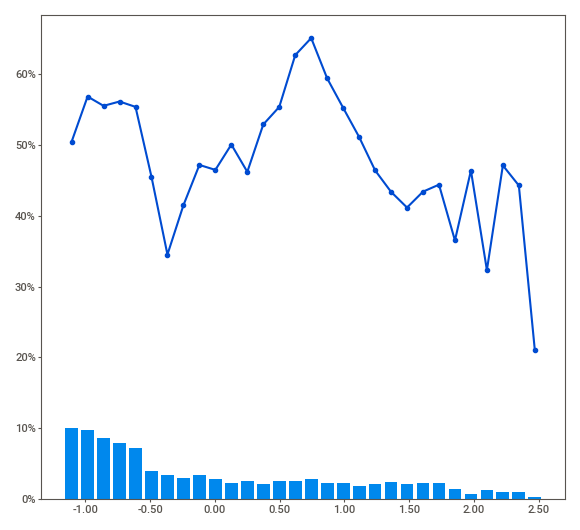
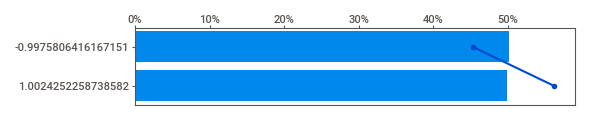
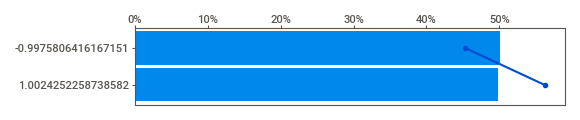
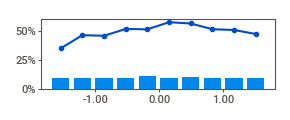
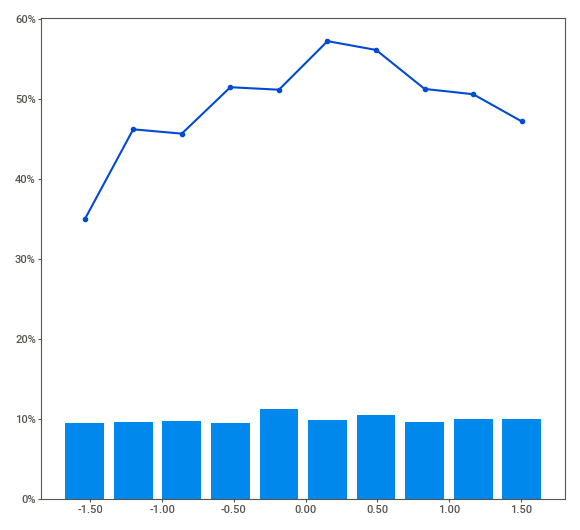
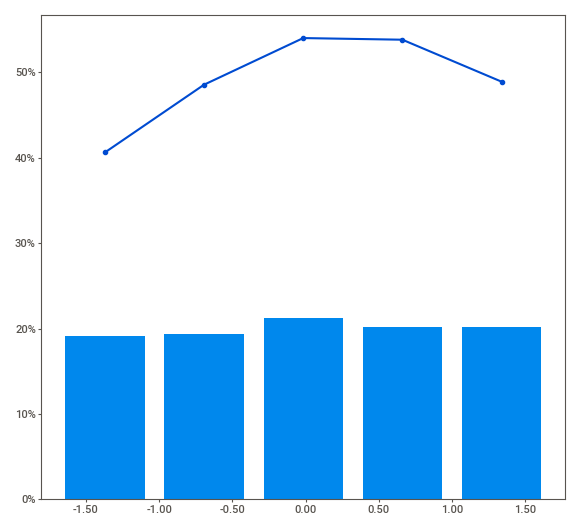
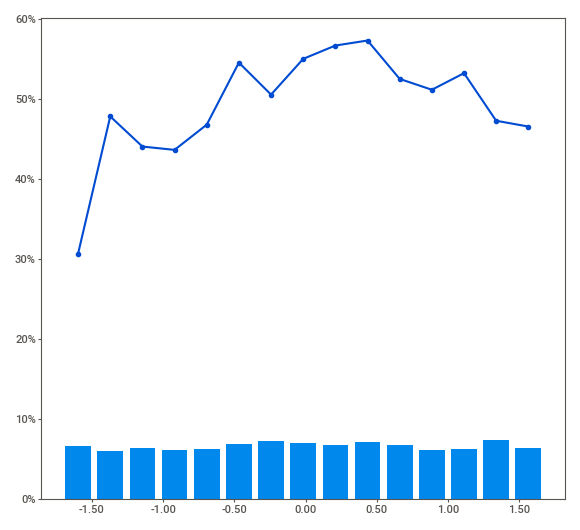
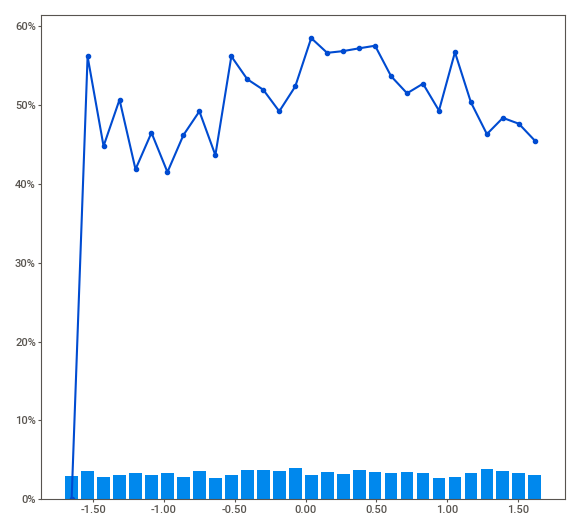
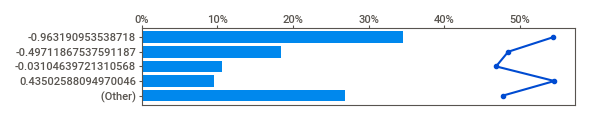
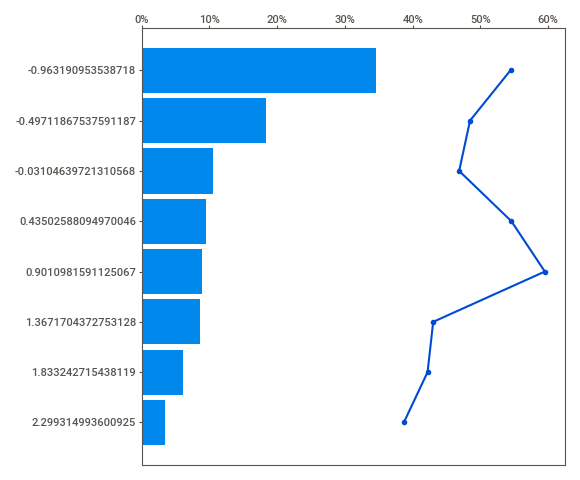
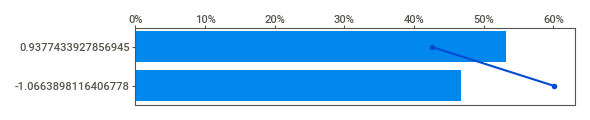
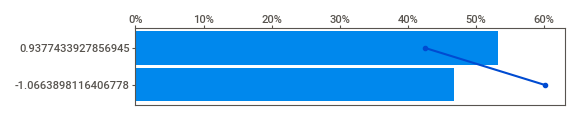
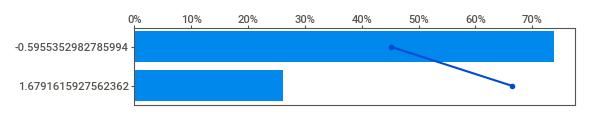
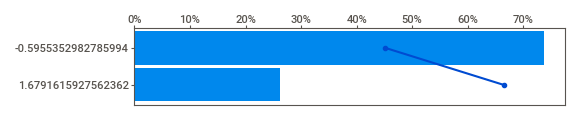
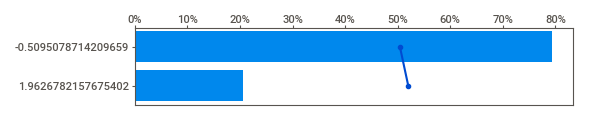
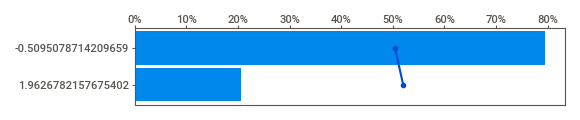
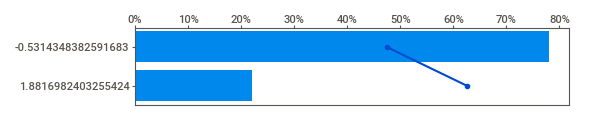
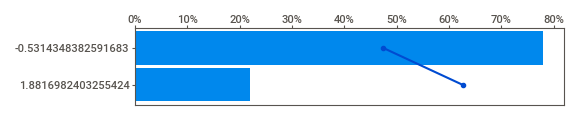
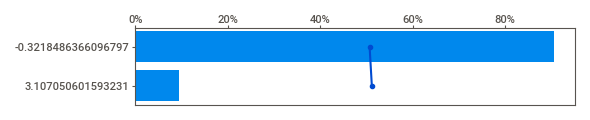
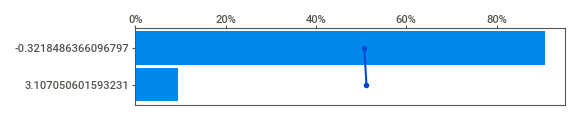
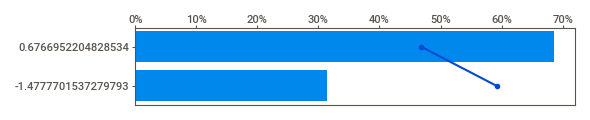
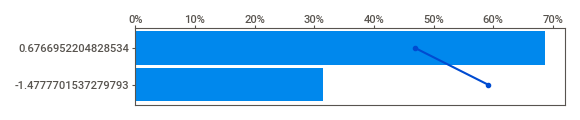
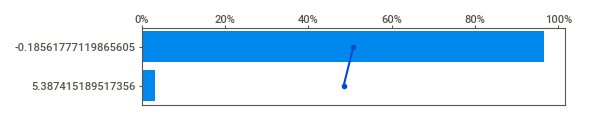
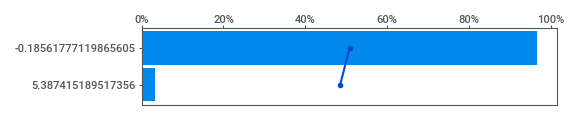
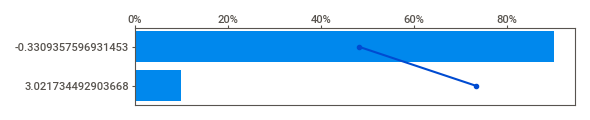
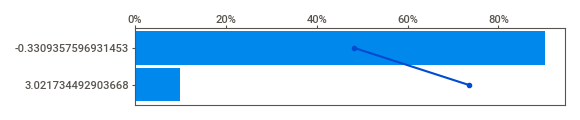
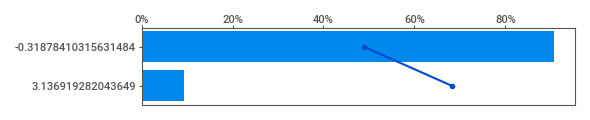
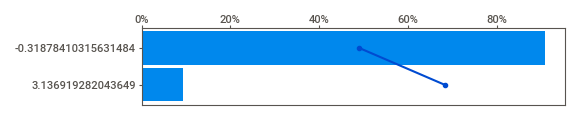
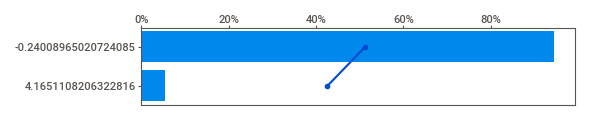
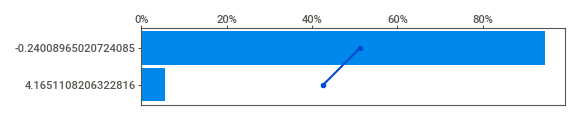
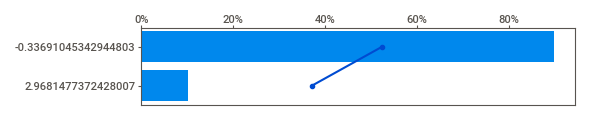
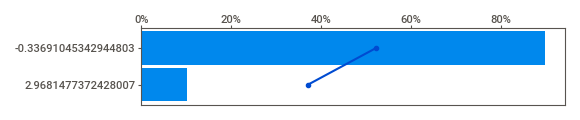
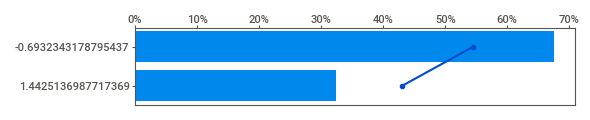
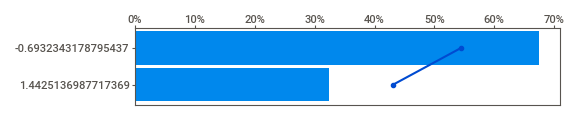
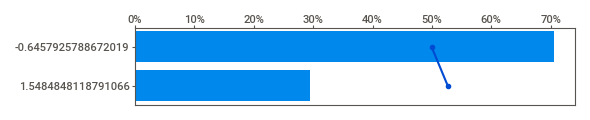
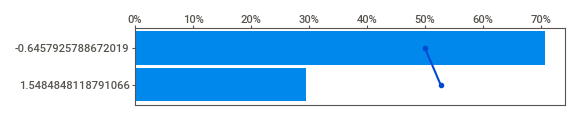
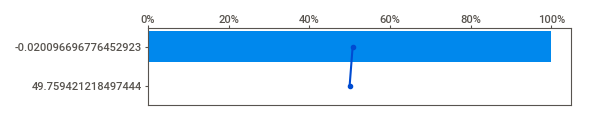
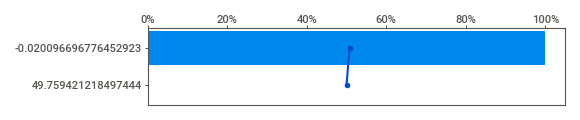
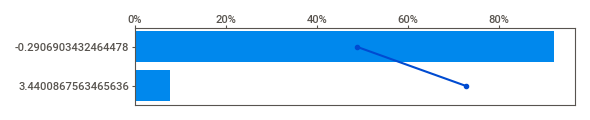
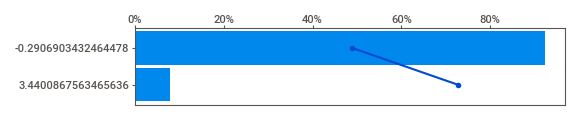
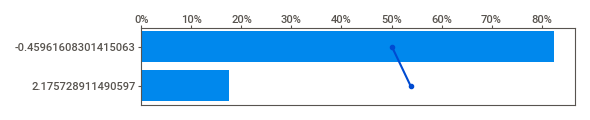
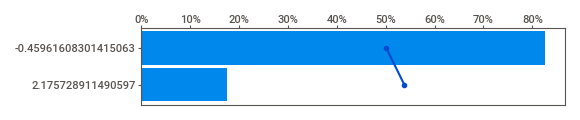
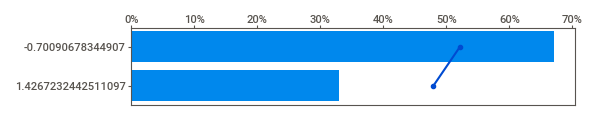
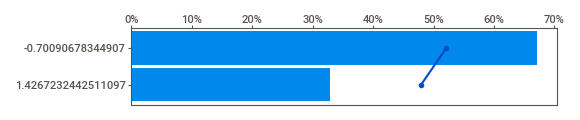
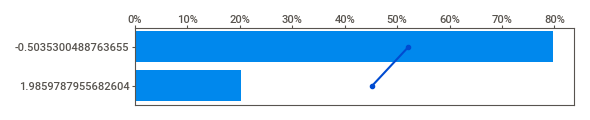
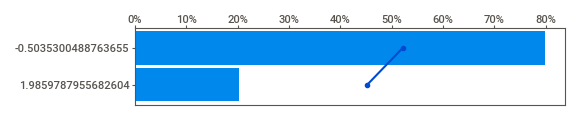
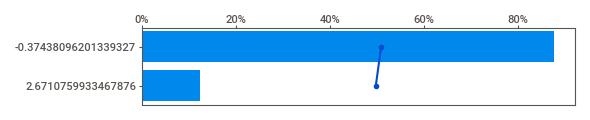
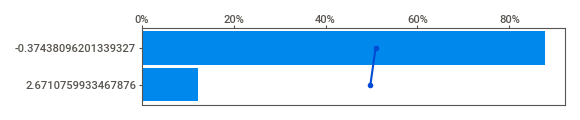
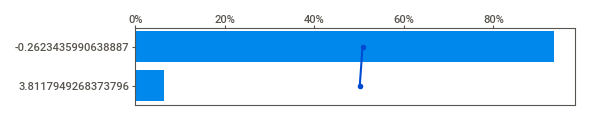
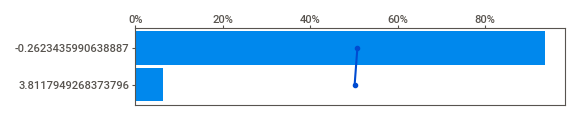
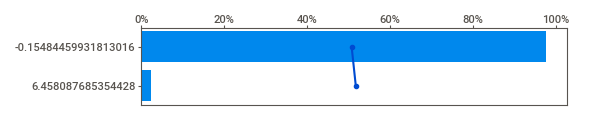
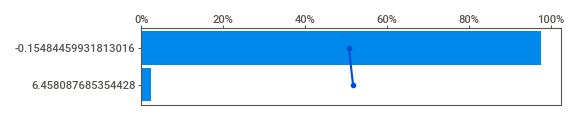
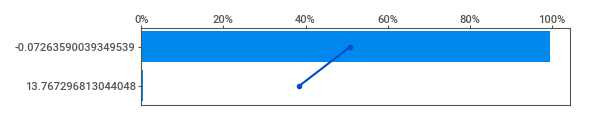
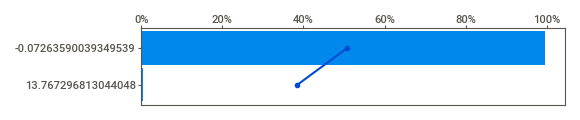
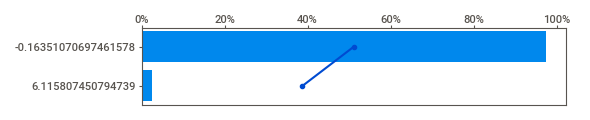
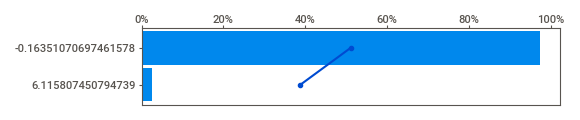
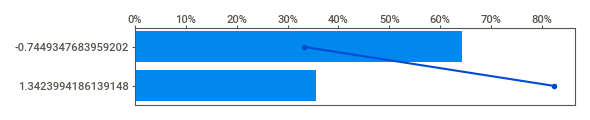
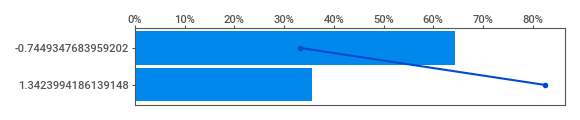
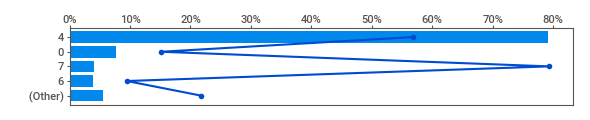
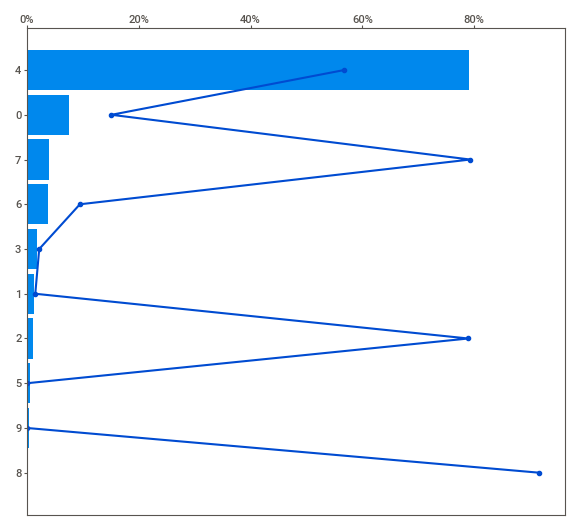
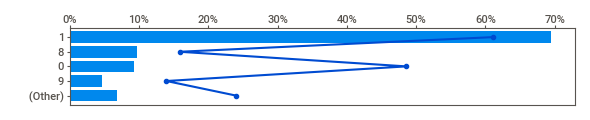
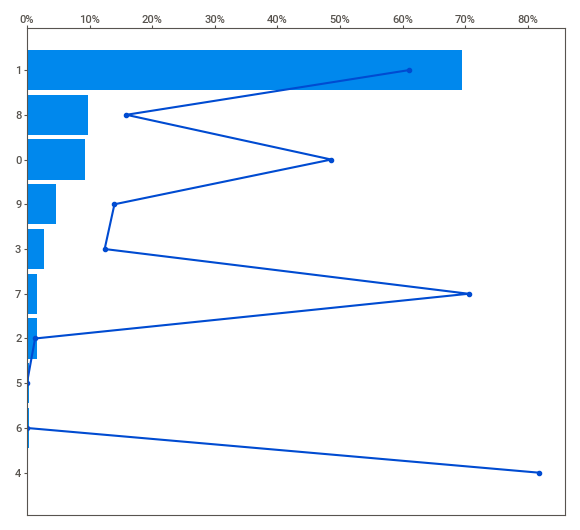
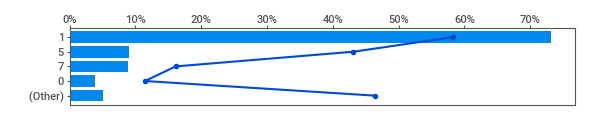
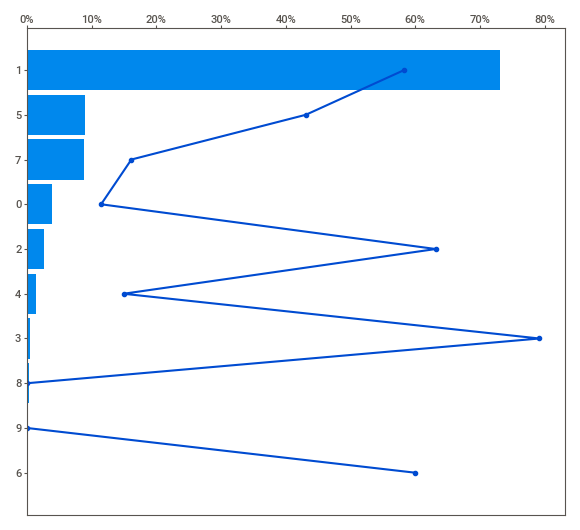
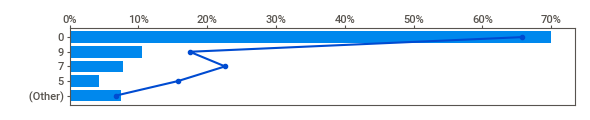
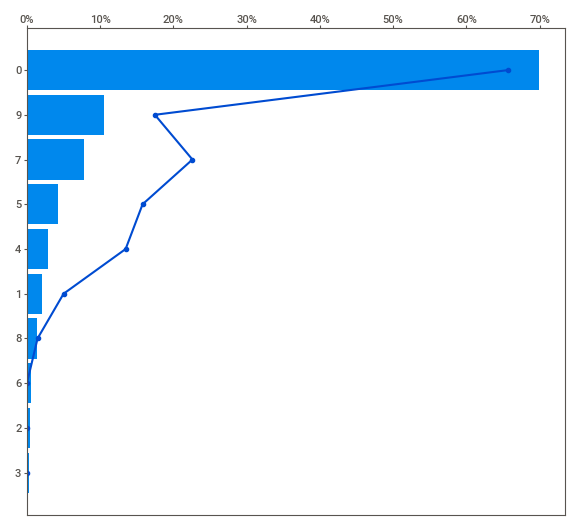
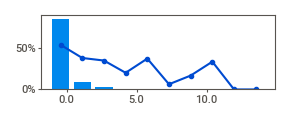
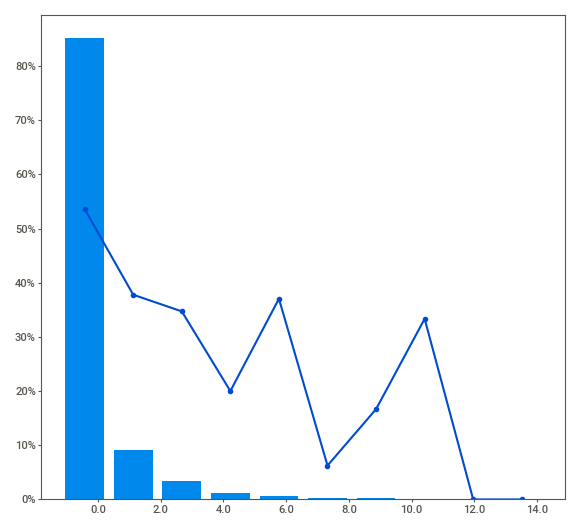
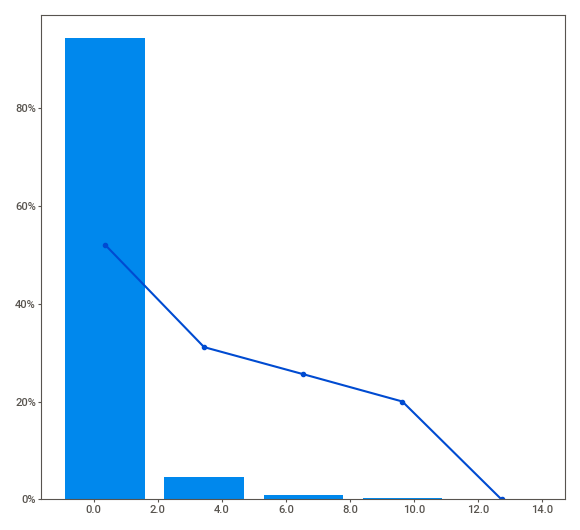
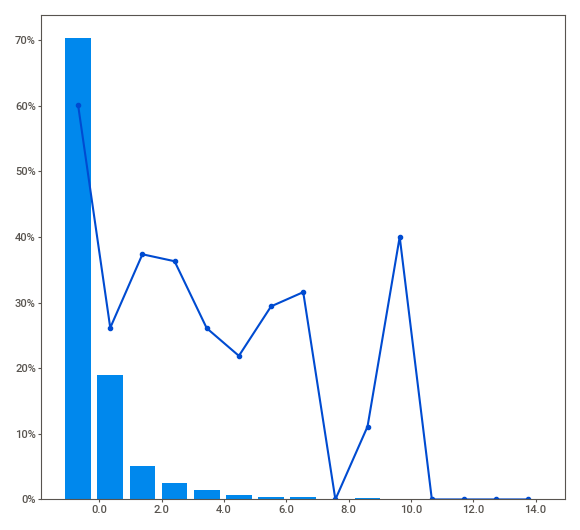
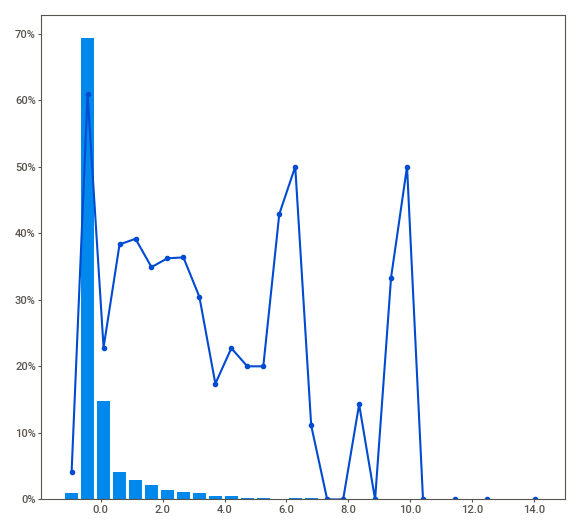
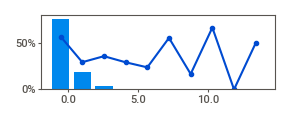
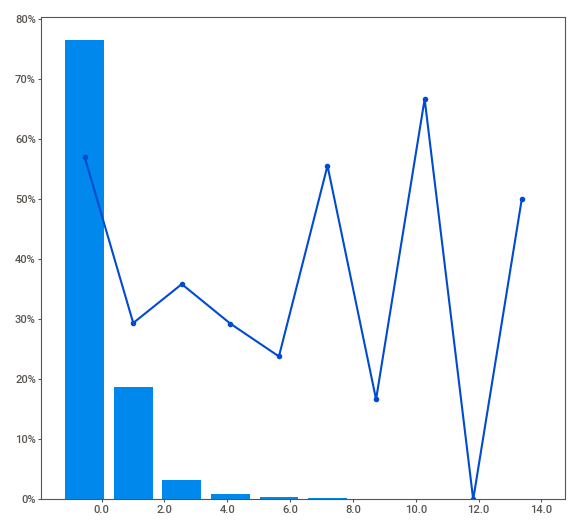
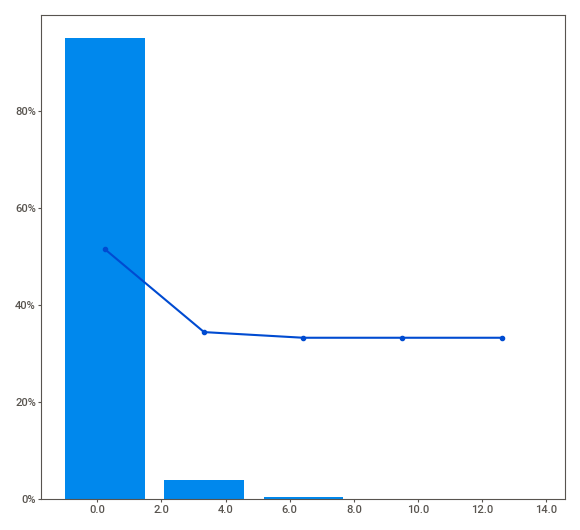
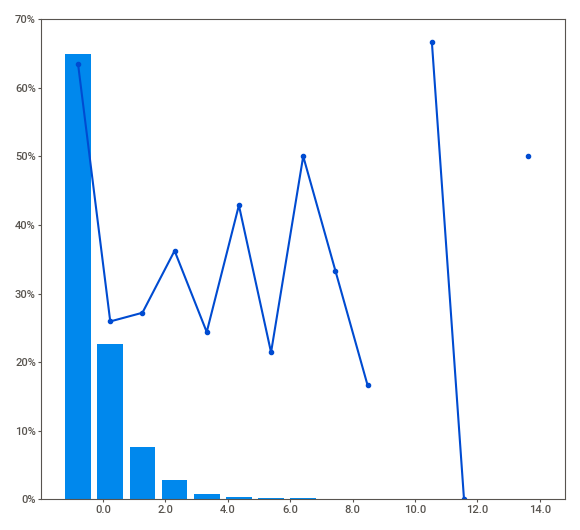
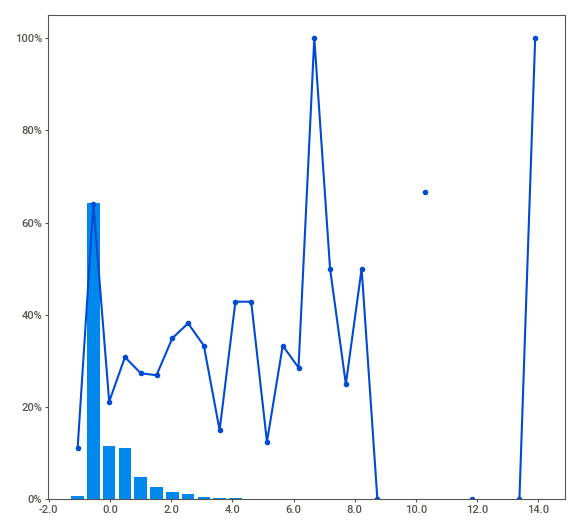
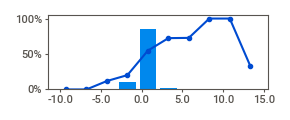
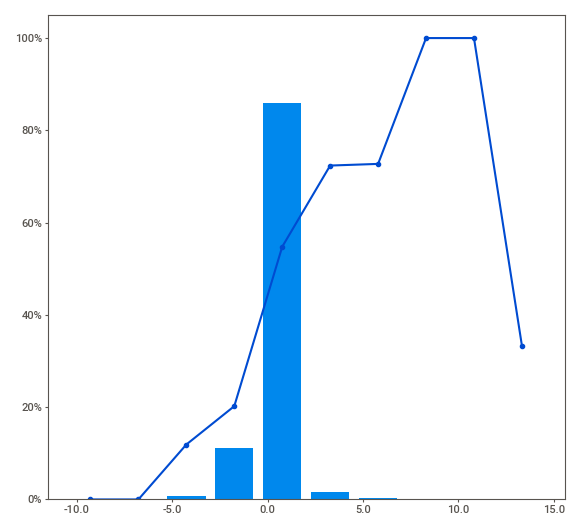
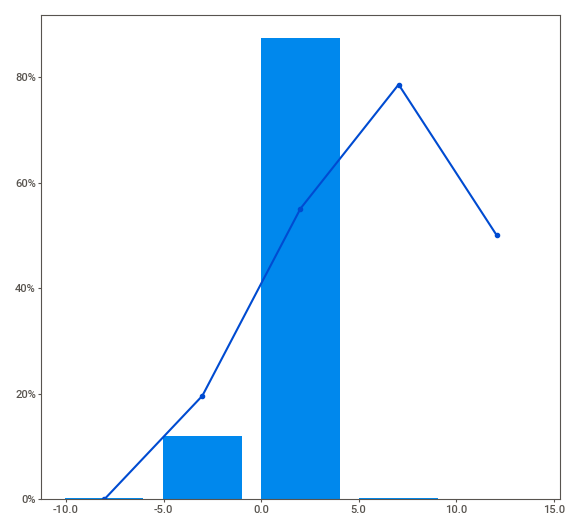
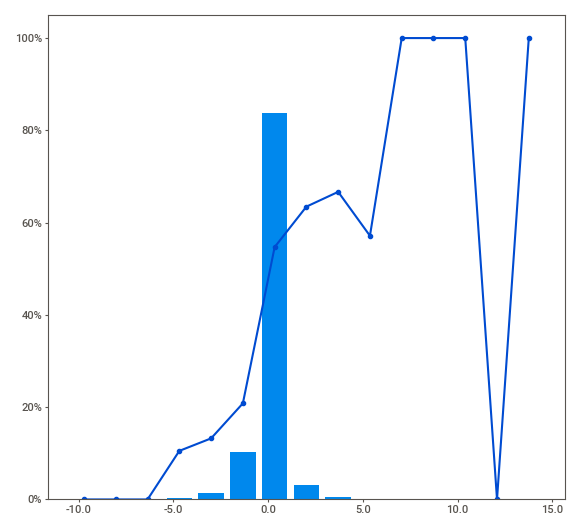
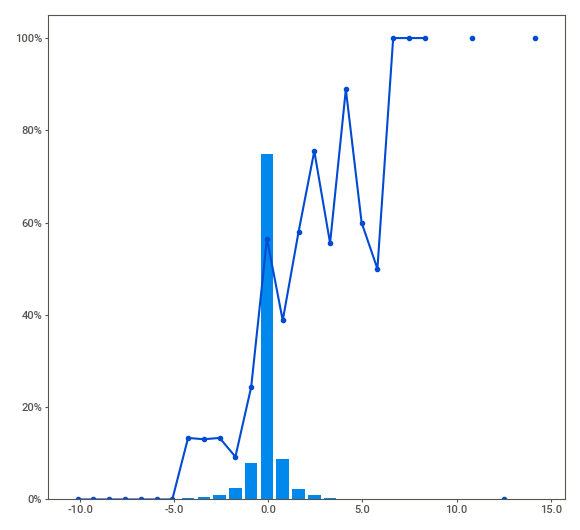
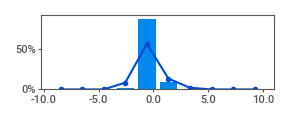
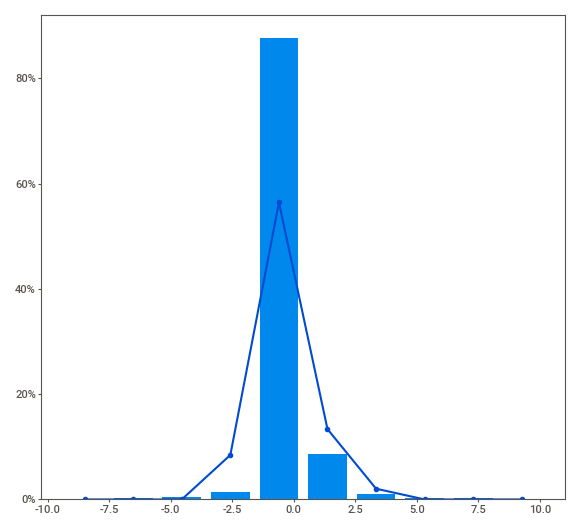
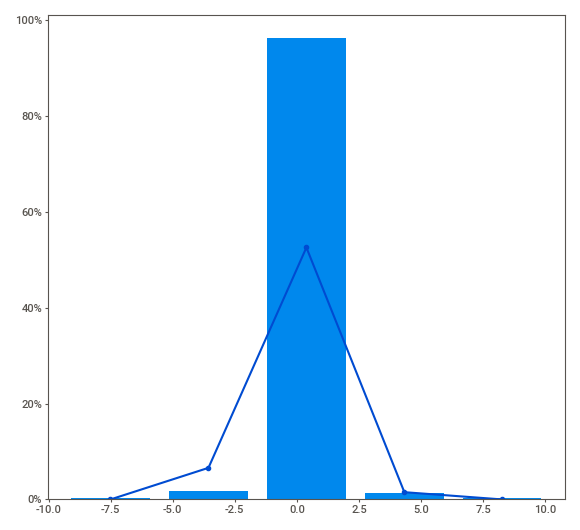
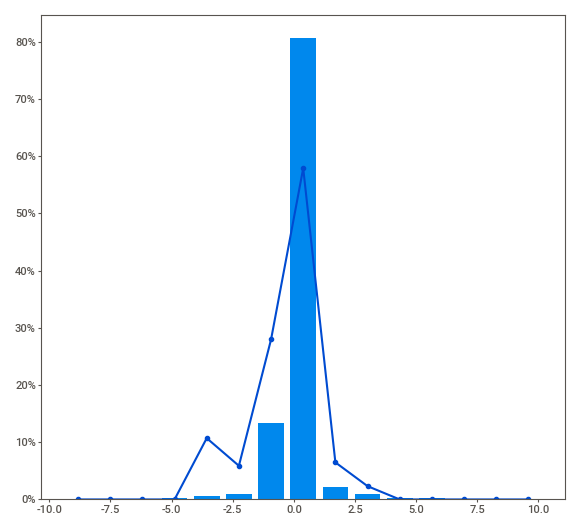
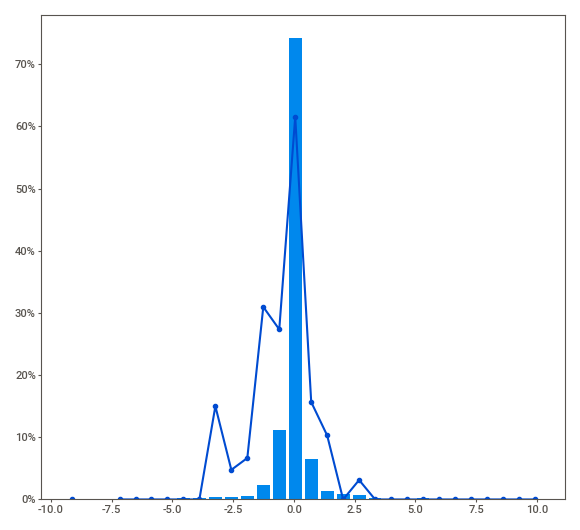
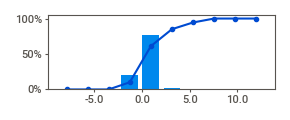
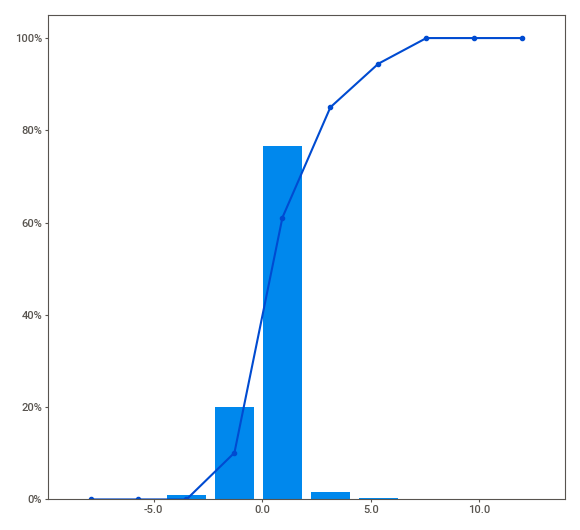
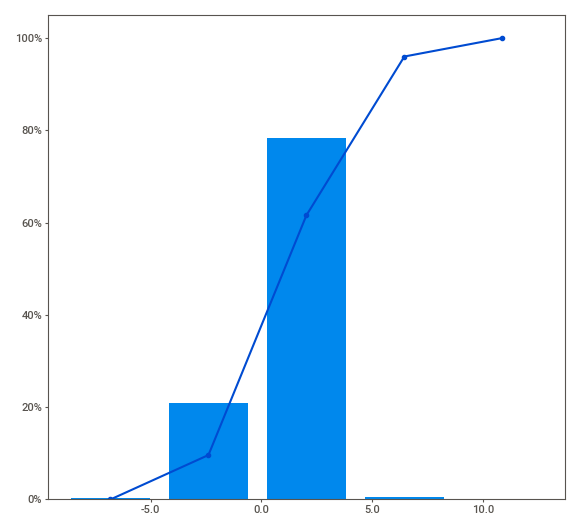
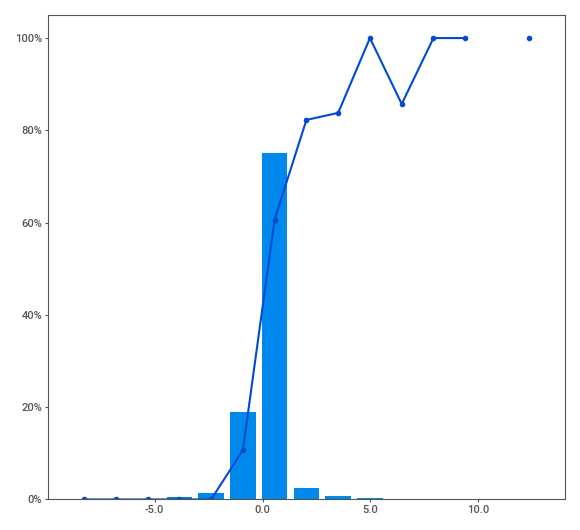
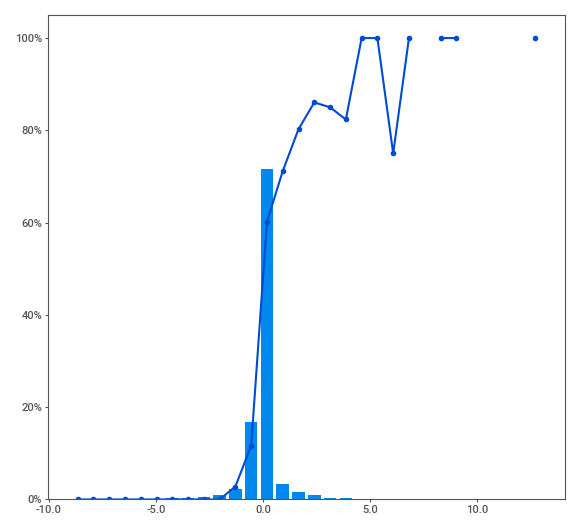
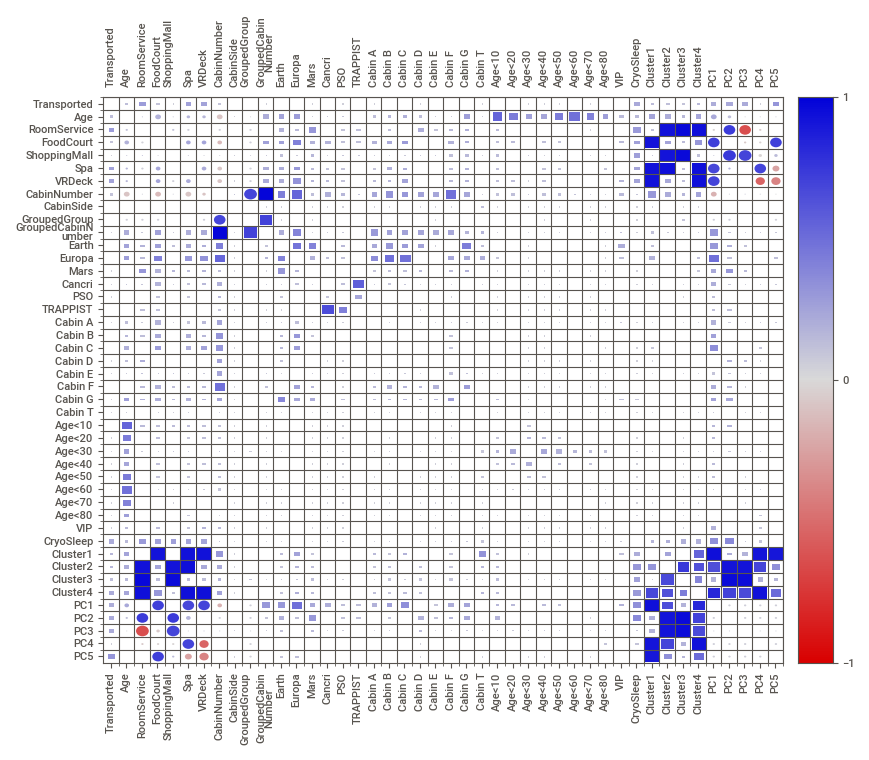
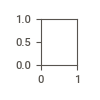

Report 'Report2.html' was saved to storage.


In [36]:
train_mi=X_train_trans.join(y_train)
my_report2 = sweetviz.analyze([train_mi, "Train"], "Transported")
#También podemos hacer lo anterior usando el método show_notebook
my_report2.show_notebook(
    w=None, #Ancho en pixeles o en porcentajes
    h=None, #Altura en pixeles o en porcentajes
    scale=None, #valor entre 0 y 1
    layout='vertical', #vertical es mucho mejor para dispositivos con pantallas pequeñas
    filepath='Report2.html')

In [37]:
modelo=CatBoostClassifier(
    iterations=300,
    eval_metric='Accuracy',
    verbose=0
)
#modelo=RandomForestClassifier(random_state=6)

#modelo.fit(X_trans,y)
modelo.fit(X_train_trans,y_train)

In [38]:
fi=modelo.feature_importances_
features_dict = dict(zip(X_train_trans.columns, list(fi)))
features_dict

{'Age': 4.314247724729835,
 'RoomService': 2.2686712858574816,
 'FoodCourt': 1.9127284677041843,
 'ShoppingMall': 1.7214725526930945,
 'Spa': 3.7360226893374295,
 'VRDeck': 4.667417924644091,
 'CabinNumber': 8.007423484925877,
 'CabinSide': 5.45212815201484,
 'GroupedGroup': 3.5967725383937093,
 'GroupedCabinNumber': 1.7982659253024726,
 'Earth': 4.6138170083651575,
 'Europa': 3.7186151553461255,
 'Mars': 2.4218761762962746,
 'Cancri': 1.0865772631997896,
 'PSO': 0.3008220960196716,
 'TRAPPIST': 1.6289895320145924,
 'Cabin A': 0.38605199194286444,
 'Cabin B': 0.8777743669587095,
 'Cabin C': 2.0731791292116717,
 'Cabin D': 0.03694930703367409,
 'Cabin E': 3.2375236754149874,
 'Cabin F': 1.2842075858365785,
 'Cabin G': 3.174590193478647,
 'Cabin T': 0.0,
 'Age<10': 0.05847990048382544,
 'Age<20': 0.36710968429467317,
 'Age<30': 0.22440071407645856,
 'Age<40': 0.8932642644398452,
 'Age<50': 0.43263799606020814,
 'Age<60': 0.10470842026818648,
 'Age<70': 0.0,
 'Age<80': 0.00806058787598465

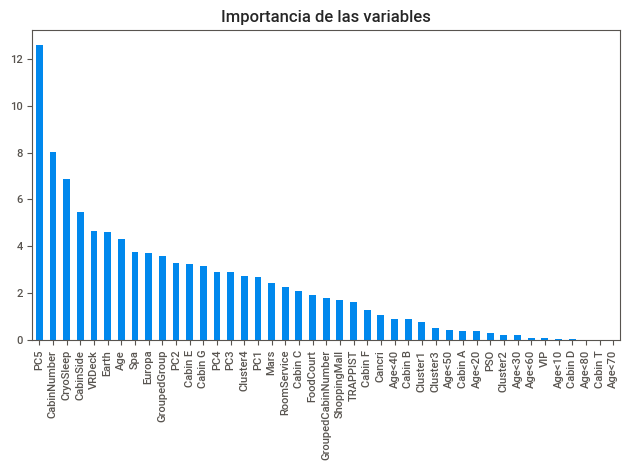

In [39]:
features_df = pd.DataFrame(features_dict, index=[0]).T.sort_values(by=[0], ascending=False).T
features_df.T.plot.bar(title="Importancia de las variables", legend=False);

In [40]:
from sklearn.metrics import accuracy_score

y_predict=modelo.predict(pipeline1.transform(X_valid))
y_valid=y_valid.reset_index().drop(['index'],axis=1)
print(pd.Series(y_predict, index=y_valid.index).astype('bool'))

accuracy_score(y_valid, pd.Series(y_predict, index=y_valid.index).astype('bool'))

0       True
1       True
2       True
3       True
4       True
        ... 
1647    True
1648    True
1649    True
1650    True
1651    True
Length: 1652, dtype: bool


0.49213075060532685

In [41]:
y_valid.apply(lambda x: str(x))

Transported    0        True\n1        True\n2        True\n3...
dtype: object

In [42]:
submit=pd.DataFrame()
submit["PassengerId"]=test.PassengerId
submit["Transported"]=pd.Series(modelo.predict(pipeline1.transform(test)))
submit
submit.to_csv('submit.csv', index=False)